# Cobalt Reporting Data

In [1]:
# Modules
from cobalt_reporting_functions import *

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from scipy import stats

import re
import copy
import datetime
from collections import defaultdict
import itertools
from itertools import cycle

import glob
import os

import psycopg2
from sqlalchemy import create_engine

# Pandas view options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('precision', 4)

# Program Parameters

# Master Data

In [2]:
# Connect to database
read_cursor,reporting_cursor = database_connect()

In [3]:
# List all Cobalt tables
query = """SELECT table_name FROM information_schema.tables WHERE table_schema='cobalt'"""
reporting_cursor.execute(query)
result = reporting_cursor.fetchall()

sorted(result)

[('account',),
 ('account_invite',),
 ('account_login_rule',),
 ('account_session',),
 ('account_session_answer',),
 ('account_session_grouping',),
 ('account_session_grouping_all',),
 ('account_source',),
 ('activity_action',),
 ('activity_tracking',),
 ('activity_type',),
 ('answer',),
 ('answer_category',),
 ('answer_content',),
 ('appointment',),
 ('appointment_reason',),
 ('appointment_reason_type',),
 ('appointment_type',),
 ('approval_status',),
 ('assessment',),
 ('assessment_type',),
 ('assessment_viewer',),
 ('attendance_status',),
 ('audit_log',),
 ('audit_log_event',),
 ('available_status',),
 ('beta_feature',),
 ('beta_feature_alert',),
 ('beta_status',),
 ('category',),
 ('category_mapping',),
 ('clinic',),
 ('content',),
 ('content_action',),
 ('content_category',),
 ('content_type',),
 ('content_type_label',),
 ('crisis_contact',),
 ('epic_appointment_filter',),
 ('epic_department',),
 ('external_group_event_type',),
 ('feedback_contact',),
 ('followup',),
 ('followup_e

## Accounts
* Note 08/25/2021: 
    * How many employees at Penn?
    * Are all employees eligible?
    * Other groups (students) eligible in future?

### Account

In [4]:
# Get account data
account = get_table_data(reporting_cursor, 'account')

# Adjust columns
account['year'] = account['created'].dt.year
account['month'] = account['created'].dt.month
account['week'] = account['created'].dt.week
account['day'] = account['created'].dt.day
account['year_month'] = account['created'].values.astype('datetime64[M]')
account['year_month_week'] = account['created'].values.astype('datetime64[W]')
account['dayofyear'] = account['created'].apply(lambda x: get_date_str(x))

# Filter for relevant data
account = account[(account['institution_id']=='PENN') & (account['role_id']=='PATIENT')]
account = account[account['phone_number']!='+12157777777'] # added 11/10/2021

# Time series data
acct_monthly_ts_data = pd.DataFrame(account.groupby(['year','month']).count().account_id)
acct_weekly_ts_data = pd.DataFrame(account.groupby(['year_month_week']).count().account_id)
acct_weekly_ts_data.index = pd.MultiIndex.from_arrays([acct_weekly_ts_data.index.year, 
                                                            acct_weekly_ts_data.index.month, 
                                                            acct_weekly_ts_data.index.day], 
                                                            names=['Year','Month','Week'])

# Time series data by account source
acct_src_ts_data = pd.DataFrame(account.groupby(['year','month','account_source_id']).count().account_id)
acct_src_ts_data = acct_src_ts_data.unstack().fillna(0).account_id

acct_src_weekly_ts_data = pd.DataFrame(account.groupby(['year_month_week', 'account_source_id']).count()).account_id
acct_src_weekly_ts_data = acct_src_weekly_ts_data.unstack().fillna(0)
acct_src_weekly_ts_data.index = pd.MultiIndex.from_arrays([acct_src_weekly_ts_data.index.year, 
                                                      acct_src_weekly_ts_data.index.month, 
                                                      acct_src_weekly_ts_data.index.day], 
                                                      names=['Year','Month','Week'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [5]:
# Save master data
account.to_csv(MASTER_DATA_PATH + 'account_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [227]:
# Display adjusted data
print(len(account))
account.head(2)

35766


account_id  role_id institution_id  \
0  afe7ff25-775e-4518-822b-a5bb56683d7d  PATIENT           PENN   
1  3115d538-f423-4618-b23b-ec6ac9e554a9  PATIENT           PENN   

  account_source_id sso_id first_name last_name display_name email_address  \
0         ANONYMOUS   None       None      None         None          None   
1         ANONYMOUS   None       None      None         None          None   

  phone_number sso_attributes  consent_form_accepted  \
0         None           None                  False   
1         None           None                  False   

  consent_form_accepted_date locale         time_zone  \
0                        NaT  en-US  America/New_York   
1                        NaT  en-US  America/New_York   

                           created                     last_updated  \
0 2021-04-08 14:08:38.598732+00:00 2021-04-08 14:08:38.598732+00:00   
1 2021-05-18 10:00:00.228881+00:00 2021-05-18 10:00:00.228881+00:00   

  epic_patient_id epic_patient_id_type  epic_patient_created_by_cobalt  \
0            None                 None                           False   
1            None                 None                           False   

  password source_system_id provider_id beta_status_id  \
0     None           COBALT        None        UNKNOWN   
1     None           COBALT        None        UNKNOWN   

   access_token_expiration_in_minutes  \
0                                 NaN   
1                                 NaN   

   access_token_short_expiration_in_minutes metadata  \
0                                       NaN     None   
1                                       NaN     None   

   scheduling_tutorial_viewed  year  month  week  day year_month  \
0                       False  2021      4    14    8 2021-04-01   
1                       False  2021      5    20   18 2021-05-01   

  year_month_week dayofyear  
0      2021-04-08  20210408  
1      2021-05-13  20210518

### Stats Accounts

In [7]:
# Get account data
accounts_for_stats = get_table_data(reporting_cursor, 'v_accounts_for_stats')

# Adjust columns
accounts_for_stats['year'] = accounts_for_stats['created'].dt.year
accounts_for_stats['month'] = accounts_for_stats['created'].dt.month
accounts_for_stats['week'] = accounts_for_stats['created'].dt.week
accounts_for_stats['day'] = accounts_for_stats['created'].dt.day
accounts_for_stats['year_month'] = accounts_for_stats['created'].values.astype('datetime64[M]')
accounts_for_stats['year_month_week'] = accounts_for_stats['created'].values.astype('datetime64[W]')
accounts_for_stats['dayofyear'] = accounts_for_stats['created'].apply(lambda x: get_date_str(x))

# Filter for relevant data
accounts_for_stats = accounts_for_stats[(accounts_for_stats['institution_id']=='PENN') & (accounts_for_stats['role_id']=='PATIENT')]

# Time series data
acct_stats_ts_data = pd.DataFrame(accounts_for_stats.groupby(['year','month']).count().account_id)
acct_stats_weekly_ts_data = pd.DataFrame(accounts_for_stats.groupby(['year_month_week']).count().account_id)
acct_stats_weekly_ts_data.index = pd.MultiIndex.from_arrays([acct_stats_weekly_ts_data.index.year, 
                                                            acct_stats_weekly_ts_data.index.month, 
                                                            acct_stats_weekly_ts_data.index.day], 
                                                            names=['Year','Month','Week'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [8]:
# Save master data
accounts_for_stats.to_csv(MASTER_DATA_PATH + 'accounts_for_stats_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [9]:
# Display adjusted data
accounts_for_stats.head(2)

account_id  role_id institution_id  \
0  afe7ff25-775e-4518-822b-a5bb56683d7d  PATIENT           PENN   
1  3115d538-f423-4618-b23b-ec6ac9e554a9  PATIENT           PENN   

  account_source_id sso_id first_name last_name display_name email_address  \
0         ANONYMOUS   None       None      None         None          None   
1         ANONYMOUS   None       None      None         None          None   

  phone_number sso_attributes  consent_form_accepted  \
0         None           None                  False   
1         None           None                  False   

  consent_form_accepted_date locale         time_zone  \
0                        NaT  en-US  America/New_York   
1                        NaT  en-US  America/New_York   

                           created                     last_updated  year  \
0 2021-04-08 14:08:38.598732+00:00 2021-04-08 14:08:38.598732+00:00  2021   
1 2021-05-18 10:00:00.228881+00:00 2021-05-18 10:00:00.228881+00:00  2021   

   month  week  day year_month year_month_week dayofyear  
0      4    14    8 2021-04-01      2021-04-08  20210408  
1      5    20   18 2021-05-01      2021-05-13  20210518

## Providers
* NOTE 08/31/2021: Removing providers with system affinity id PIC changes counts of future appts and appt availability
    * Removing these providers also drastically changes the historic availability counts 4.4k --> 2.7k
    * Why is this? and do we still want to remove these providers?

### Provider

In [10]:
# Get provider data
provider = get_table_data(reporting_cursor, 'provider')

# Adjust columns
provider['year'] = provider['created'].dt.year
provider['month'] = provider['created'].dt.month
provider['day'] = provider['created'].dt.day
provider['year_month'] = provider['created'].values.astype('datetime64[M]')
provider['year_month_week'] = provider['created'].values.astype('datetime64[W]')
provider['dayofyear'] = provider['created'].apply(lambda x: get_date_str(x))

# Filter for relevant data
provider = provider[provider['institution_id']=='PENN']
provider = provider[provider['system_affinity_id'] != 'PIC']

# Time series data
prov_ts_data = pd.DataFrame(provider.groupby(['year','month']).count().provider_id)
prov_ts_data = prov_ts_data.merge(month_index_df, how='outer', left_index=True, right_index=True) # Get missing index values
prov_ts_data = pd.DataFrame(prov_ts_data.fillna(0)['provider_id'])

prov_weekly_ts_data = pd.DataFrame(provider.groupby(['year_month_week']).count().provider_id)
prov_weekly_ts_data.index = pd.MultiIndex.from_arrays([prov_weekly_ts_data.index.year, 
                                                      prov_weekly_ts_data.index.month, 
                                                      prov_weekly_ts_data.index.day], 
                                                      names=['Year','Month','Week'])
prov_weekly_ts_data = prov_weekly_ts_data.merge(week_index_df, how='outer', left_index=True, right_index=True)# Get missing index values
prov_weekly_ts_data = pd.DataFrame(prov_weekly_ts_data.fillna(0)['provider_id'])

In [11]:
# Save master data
provider.to_csv(MASTER_DATA_PATH + 'provider_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [12]:
# Display adjusted data
provider.head(2)

provider_id institution_id  \
0  521da634-185e-4c1d-b587-cf23e8dfbe69           PENN   
1  688e0886-b776-4b95-89e6-2329a123ccfc           PENN   

                                                name  \
0                               Ayyappan Venkatraman   
1  University of Pennsylvania Employee Assistance...   

                                       title  \
0                        Psychiatry Resident   
1  EAP Intake Counselor from Health Advocate   

                      email_address  \
0  OPCCobalt@pennmedicine.upenn.edu   
1    EAP-Connect@healthadvocate.com   

                                           image_url locale         time_zone  \
0  https://penncobalt.s3.us-east-2.amazonaws.com/...  en-US  America/New_York   
1  https://penncobalt.s3.us-east-2.amazonaws.com/...  en-US  America/New_York   

   acuity_calendar_id  bluejeans_user_id      tags  \
0           3831985.0            3874544  [Year 4]   
1           4248614.0            3874544      None   

                           created                     last_updated  \
0 2020-04-12 14:54:35.680223+00:00 2022-04-20 14:42:43.066088+00:00   
1 2020-07-30 18:05:32.597044+00:00 2022-05-02 16:57:06.508559+00:00   

                                       entity  \
0  Hospital of the University of Pennsylvania   
1                                        None   

                               clinic license specialty intake_assessment_id  \
0  Outpatient Psychiatry Center (OPC)      MD      None                 None   
1                     Health Advocate    None      None                 None   

   active scheduling_system_id epic_provider_id epic_provider_id_type  \
0   False               ACUITY             None                  None   
1    True               ACUITY             None                  None   

  videoconference_platform_id videoconference_url epic_appointment_filter_id  \
0                   BLUEJEANS                None                       NONE   
1                   TELEPHONE          8667992329                       NONE   

  system_affinity_id   bio bio_url  year  month  day year_month  \
0             COBALT  None    None  2020      4   12 2020-04-01   
1             COBALT  None    None  2020      7   30 2020-07-01   

  year_month_week dayofyear  
0      2020-04-09  20200412  
1      2020-07-30  20200730

### Provider Support Role

In [13]:
# Get provider role data
provider_support_role = get_table_data(reporting_cursor, 'provider_support_role')

# Filter for relevant data
provider_support_role = provider_support_role[provider_support_role['provider_id'].isin(provider['provider_id'])]

In [14]:
# Save master data
provider_support_role.to_csv(MASTER_DATA_PATH + 'provider_role_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [15]:
# Display adjusted data
provider_support_role.head(2)

provider_id support_role_id
0  38e2bbb1-7930-40b3-ab7c-dc87eadf6444    PSYCHIATRIST
1  8f3f7c98-ce1c-42b3-9840-1b49ff83a4ce            PEER

### Provider Appointment Type

In [16]:
# Get provider appointment type data
provider_appointment_type = get_table_data(reporting_cursor, 'provider_appointment_type')

# Filter for relevant data
provider_appointment_type = provider_appointment_type[provider_appointment_type['provider_id'].isin(provider['provider_id'])]

In [17]:
# Display adjusted data
provider_appointment_type.head(2)

provider_appointment_type_id                           provider_id  \
0  02f452b0-d150-4c89-8ee7-f6600727be60  38e2bbb1-7930-40b3-ab7c-dc87eadf6444   
1  85e6ce45-07ea-4729-b7ca-c799790a246f  38e2bbb1-7930-40b3-ab7c-dc87eadf6444   

   display_order                          created  \
0              1 2020-07-18 01:38:53.757424+00:00   
1              2 2020-07-18 01:38:53.757424+00:00   

                      last_updated                   appointment_type_id  
0 2020-07-18 01:38:53.757424+00:00  367d33ad-2aad-4fea-a2a1-ea397e18fe43  
1 2020-07-18 01:38:53.757424+00:00  86b14268-96d9-45e9-9867-677b3d010385

## Appointments

### Appointment Type

In [18]:
# Get appointment type data
appointment_type = get_table_data(reporting_cursor, 'appointment_type')

appointment_type_dict = dict(zip(appointment_type.appointment_type_id, appointment_type.name))

In [19]:
# Display adjusted data
appointment_type.head(2)

appointment_type_id  acuity_appointment_type_id  \
0  2294b4f1-7fad-454f-a118-06b479356d7d                  1.3870e+07   
1  a2cab967-9dc1-4327-94dd-da4be7652542                  2.1475e+07   

                                   name description  duration_in_minutes  \
0  1:1 Appointment with Psychotherapist        None                   60   
1           1:1 CTSA Intake Appointment        None                   45   

   deleted                          created                     last_updated  \
0    False 2020-04-29 22:49:45.585841+00:00 2021-02-05 22:32:12.739208+00:00   
1    False 2021-03-23 20:43:48.450351+00:00 2021-03-23 20:58:49.167044+00:00   

  scheduling_system_id epic_visit_type_id epic_visit_type_id_type  \
0               ACUITY               None                    None   
1               ACUITY               None                    None   

  visit_type_id  hex_color  
0         OTHER    3692510  
1         OTHER    3692510

### Booked Appointments

In [20]:
# Get appointment data
appointment = get_table_data(reporting_cursor, 'appointment')

# Adjust columns
appointment['start_time'] = appointment['start_time'].dt.tz_localize(tz='US/Eastern')
appointment['created'] = appointment['created'].dt.tz_convert(tz='US/Eastern')

appointment['created_year'] = appointment['created'].dt.year
appointment['created_month'] = appointment['created'].dt.month
appointment['created_day'] = appointment['created'].dt.day
appointment['created_year_month'] = appointment['created'].values.astype('datetime64[M]')
appointment['created_year_month_week'] = appointment['created'].values.astype('datetime64[W]')
appointment['created_dayofyear'] = appointment['created'].apply(lambda x: get_date_str(x))

appointment['apt_year'] = appointment['start_time'].dt.year
appointment['apt_month'] = appointment['start_time'].dt.month
appointment['apt_day'] = appointment['start_time'].dt.day
appointment['apt_year_month'] = appointment['start_time'].values.astype('datetime64[M]')
appointment['apt_year_month_week'] = appointment['start_time'].values.astype('datetime64[W]')
appointment['apt_dayofyear'] = appointment['start_time'].apply(lambda x: get_date_str(x))

appointment['created_completed_time']=((appointment['start_time'] - appointment['created'])/np.timedelta64(1, 'D')).round()
appointment['appointment_type_name'] = appointment['appointment_type_id'].map(appointment_type_dict)
appointment = get_appt_provider_role_df(appointment, provider_support_role)

# Filter for relevant data
appointment = appointment[appointment['created'] < appointment['start_time']]
appointment = appointment.groupby(['account_id']).filter(lambda x: len(x)<50)
appointment = appointment[appointment['account_id'].isin(account['account_id'])]
appointment = appointment[appointment['provider_id'].isin(provider['provider_id'])]
appointment = appointment[appointment['acuity_class_id'].isnull()]

# Appointment Subsets
appointment_completed = appointment[appointment['canceled']==False]
appointment_canceled = appointment[appointment['canceled']==True]

appointment_future = appointment[appointment['start_time'] >= current_date]
appointment_future_30day = appointment_future[appointment_future['start_time'] <= future_30day]
appointment_future_90day = appointment_future[appointment_future['start_time'] <= future_90day]

appointment_past = appointment[appointment['start_time'] <= current_date]
appointment_past_30day = appointment_past[appointment_past['start_time'] >= past_30day]
appointment_past_90day = appointment_past[appointment_past['start_time'] >= past_90day]

# Time series data
apt_ts_data = pd.DataFrame(appointment.groupby(['apt_year','apt_month']).count().appointment_id)
apt_ts_data.index.names = ['year','month']
apt_weekly_ts_data = pd.DataFrame(appointment.groupby(['apt_year_month_week']).count().appointment_id)
apt_weekly_ts_data.index = pd.MultiIndex.from_arrays([apt_weekly_ts_data.index.year, 
                                                      apt_weekly_ts_data.index.month, 
                                                      apt_weekly_ts_data.index.day], 
                                                      names=['Year','Month','Week'])

apt_completed_ts_data = pd.DataFrame(appointment_completed.groupby(['apt_year','apt_month']).count().appointment_id)
apt_completed_ts_data.index.names = ['year','month']
apt_weekly_completed_ts_data = pd.DataFrame(appointment_completed.groupby(['apt_year_month_week']).count().appointment_id)
apt_weekly_completed_ts_data.index = pd.MultiIndex.from_arrays([apt_weekly_completed_ts_data.index.year, 
                                                                apt_weekly_completed_ts_data.index.month, 
                                                                apt_weekly_completed_ts_data.index.day],
                                                                names=['Year','Month','Week'])

apt_canceled_ts_data = pd.DataFrame(appointment_canceled.groupby(['apt_year','apt_month']).count().appointment_id)
apt_canceled_ts_data.index.names = ['year','month']
apt_weekly_canceled_ts_data = pd.DataFrame(appointment_canceled.groupby(['apt_year_month_week']).count().appointment_id)
apt_weekly_canceled_ts_data.index = pd.MultiIndex.from_arrays([apt_weekly_canceled_ts_data.index.year, 
                                                                apt_weekly_canceled_ts_data.index.month, 
                                                                apt_weekly_canceled_ts_data.index.day],
                                                                names=['Year','Month','Week'])

# Time series data by provider role
aptRole_ts_data = pd.DataFrame(appointment.groupby(['apt_year','apt_month','support_role_id']).count().appointment_id)
aptRole_ts_data = aptRole_ts_data.unstack().fillna(0).appointment_id
aptRole_ts_data.index.names = ['year','month']

aptRole_weekly_ts_data = pd.DataFrame(appointment.groupby(['apt_year_month_week', 'support_role_id']).count()).appointment_id
aptRole_weekly_ts_data = aptRole_weekly_ts_data.unstack().fillna(0)
aptRole_weekly_ts_data.index = pd.MultiIndex.from_arrays([aptRole_weekly_ts_data.index.year, 
                                                      aptRole_weekly_ts_data.index.month, 
                                                      aptRole_weekly_ts_data.index.day], 
                                                      names=['Year','Month','Week'])

In [21]:
# Save master data
appointment.to_csv(MASTER_DATA_PATH + 'appointment_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [22]:
# Display adjusted data
appointment.head(2)

appointment_id                           provider_id  \
0  98365dba-f07b-4e89-b4aa-2eca8d37e428  c236acc5-9473-457a-af51-de57bddcb8a3   
0  8e52c173-f3d4-4b9d-913c-32a5679e2387  5fc46a43-58d1-46fc-bae9-44c65e58388b   

                             account_id  acuity_appointment_id  \
0  90c9b318-a1be-4b67-b5fb-a7a68559e0e3             8.4849e+08   
0  9a64f46d-ca02-4783-9f75-d9f708a79fa9             8.0982e+08   

   acuity_appointment_type_id  acuity_class_id  bluejeans_meeting_id  \
0                         NaN              NaN            1.0494e+08   
0                         NaN              NaN            1.0305e+08   

                    videoconference_url                                 title  \
0  https://bluejeans.com/698184757/7722  1:1 Appointment with Psychotherapist   
0  https://bluejeans.com/166022552/0525                 1:1 with Care Manager   

                 start_time            end_time  duration_in_minutes  \
0 2022-07-06 16:00:00-04:00 2022-07-06 17:00:00                   60   
0 2022-04-22 11:00:00-04:00 2022-04-22 11:30:00                   30   

          time_zone  canceled canceled_at                          created  \
0  America/New_York     False         NaT 2022-06-22 16:25:35.721374-04:00   
0  America/New_York     False         NaT 2022-04-20 11:32:48.204541-04:00   

                      last_updated epic_contact_id epic_contact_id_type  \
0 2022-06-22 20:25:35.721374+00:00            None                 None   
0 2022-04-20 15:32:48.204541+00:00            None                 None   

                    appointment_type_id phone_number  \
0  2294b4f1-7fad-454f-a118-06b479356d7d         None   
0  aef3538a-73fa-40cf-8d3f-367022913b9c         None   

  videoconference_platform_id                 appointment_reason_id  \
0                   BLUEJEANS  3c34a096-2f4d-4091-a9d8-f0381ba079a1   
0                   BLUEJEANS  3c34a096-2f4d-4091-a9d8-f0381ba079a1   

                  created_by_account_id comment attendance_status_id  \
0  90c9b318-a1be-4b67-b5fb-a7a68559e0e3    None              UNKNOWN   
0  9a64f46d-ca02-4783-9f75-d9f708a79fa9    None              UNKNOWN   

  bluejeans_participant_passcode                  intake_assessment_id  \
0                           7722  5929588e-ee53-4df5-9c62-1656a43ff4cd   
0                           0525  20290377-2978-4472-b00c-6f604f25ee58   

  scheduling_system_id  canceled_for_reschedule rescheduled_appointment_id  \
0               ACUITY                    False                       None   
0               ACUITY                    False                       None   

              intake_account_session_id interaction_instance_id  created_year  \
0  b762db93-d3fd-4933-a856-c56126db5a37                    None          2022   
0  08048f29-035c-4341-82fd-b41406303114                    None          2022   

   created_month  created_day created_year_month created_year_month_week  \
0              6           22         2022-06-01              2022-06-16   
0              4           20         2022-04-01              2022-04-14   

  created_dayofyear  apt_year  apt_month  apt_day apt_year_month  \
0          20220622      2022          7        6     2022-07-01   
0          20220420      2022          4       22     2022-04-01   

  apt_year_month_week apt_dayofyear  created_completed_time  \
0          2022-06-30      20220706                    14.0   
0          2022-04-21      20220422                     2.0   

                  appointment_type_name support_role_id  
0  1:1 Appointment with Psychotherapist       CLINICIAN  
0                 1:1 with Care Manager    CARE_MANAGER

In [23]:
# Display adjusted data
appointment_future.head(2)

appointment_id                           provider_id  \
0  98365dba-f07b-4e89-b4aa-2eca8d37e428  c236acc5-9473-457a-af51-de57bddcb8a3   
1  58b9eccd-26e0-4d12-9635-988c0b942488  c236acc5-9473-457a-af51-de57bddcb8a3   

                             account_id  acuity_appointment_id  \
0  90c9b318-a1be-4b67-b5fb-a7a68559e0e3             8.4849e+08   
1  dd646488-6542-4380-a403-4122169803d2             8.4883e+08   

   acuity_appointment_type_id  acuity_class_id  bluejeans_meeting_id  \
0                         NaN              NaN            1.0494e+08   
1                         NaN              NaN            1.0496e+08   

                    videoconference_url                                 title  \
0  https://bluejeans.com/698184757/7722  1:1 Appointment with Psychotherapist   
1  https://bluejeans.com/967783232/3254  1:1 Appointment with Psychotherapist   

                 start_time            end_time  duration_in_minutes  \
0 2022-07-06 16:00:00-04:00 2022-07-06 17:00:00                   60   
1 2022-07-27 17:00:00-04:00 2022-07-27 18:00:00                   60   

          time_zone  canceled canceled_at                          created  \
0  America/New_York     False         NaT 2022-06-22 16:25:35.721374-04:00   
1  America/New_York     False         NaT 2022-06-23 08:11:29.656994-04:00   

                      last_updated epic_contact_id epic_contact_id_type  \
0 2022-06-22 20:25:35.721374+00:00            None                 None   
1 2022-06-23 12:11:29.656994+00:00            None                 None   

                    appointment_type_id phone_number  \
0  2294b4f1-7fad-454f-a118-06b479356d7d         None   
1  2294b4f1-7fad-454f-a118-06b479356d7d         None   

  videoconference_platform_id                 appointment_reason_id  \
0                   BLUEJEANS  3c34a096-2f4d-4091-a9d8-f0381ba079a1   
1                   BLUEJEANS  3c34a096-2f4d-4091-a9d8-f0381ba079a1   

                  created_by_account_id comment attendance_status_id  \
0  90c9b318-a1be-4b67-b5fb-a7a68559e0e3    None              UNKNOWN   
1  dd646488-6542-4380-a403-4122169803d2    None              UNKNOWN   

  bluejeans_participant_passcode                  intake_assessment_id  \
0                           7722  5929588e-ee53-4df5-9c62-1656a43ff4cd   
1                           3254  5929588e-ee53-4df5-9c62-1656a43ff4cd   

  scheduling_system_id  canceled_for_reschedule rescheduled_appointment_id  \
0               ACUITY                    False                       None   
1               ACUITY                    False                       None   

              intake_account_session_id interaction_instance_id  created_year  \
0  b762db93-d3fd-4933-a856-c56126db5a37                    None          2022   
1  81629494-b60f-4795-be06-5c2a02486adb                    None          2022   

   created_month  created_day created_year_month created_year_month_week  \
0              6           22         2022-06-01              2022-06-16   
1              6           23         2022-06-01              2022-06-23   

  created_dayofyear  apt_year  apt_month  apt_day apt_year_month  \
0          20220622      2022          7        6     2022-07-01   
1          20220623      2022          7       27     2022-07-01   

  apt_year_month_week apt_dayofyear  created_completed_time  \
0          2022-06-30      20220706                    14.0   
1          2022-07-21      20220727                    34.0   

                  appointment_type_name support_role_id  
0  1:1 Appointment with Psychotherapist       CLINICIAN  
1  1:1 Appointment with Psychotherapist       CLINICIAN

### Available Appointments

In [24]:
# Get provider availability data
provider_availability = get_table_data(reporting_cursor, 'provider_availability')

# Adjust columns
provider_availability['date_time'] = provider_availability['date_time'].dt.tz_localize(tz='US/Eastern')
provider_availability['created'] = provider_availability['created'].dt.tz_convert(tz='US/Eastern')

provider_availability['created_year'] = provider_availability['created'].dt.year
provider_availability['created_month'] = provider_availability['created'].dt.month
provider_availability['created_day'] = provider_availability['created'].dt.day
provider_availability['created_year_month'] = provider_availability['created'].values.astype('datetime64[M]')
provider_availability['created_year_month_week'] = provider_availability['created'].values.astype('datetime64[W]')
provider_availability['created_dayofyear'] = provider_availability['created'].apply(lambda x: get_date_str(x))

provider_availability['apt_year'] = provider_availability['date_time'].dt.year
provider_availability['apt_month'] = provider_availability['date_time'].dt.month
provider_availability['apt_day'] = provider_availability['date_time'].dt.day
provider_availability['apt_year_month'] = provider_availability['date_time'].values.astype('datetime64[M]')
provider_availability['apt_year_month_week'] = provider_availability['date_time'].values.astype('datetime64[W]')
provider_availability['apt_dayofyear'] = provider_availability['date_time'].apply(lambda x: get_date_str(x))

provider_availability['appointment_type_name'] = provider_availability['appointment_type_id'].map(appointment_type_dict)
provider_availability = get_appt_provider_role_df(provider_availability, provider_support_role)

# Filter for relevant data
provider_availability = provider_availability[provider_availability['provider_id'].isin(provider['provider_id'])]

# Provider availability subsets
provider_availability_future = provider_availability[provider_availability['date_time'] >= current_date]
provider_availability_future_30day = provider_availability_future[provider_availability_future['date_time'] <= future_30day]
provider_availability_future_90day = provider_availability_future[provider_availability_future['date_time'] <= future_90day]

provider_availability_past = provider_availability[provider_availability['date_time'] <= current_date]
provider_availability_past_30day = provider_availability_past[provider_availability_past['date_time'] >= past_30day]
provider_availability_past_90day = provider_availability_past[provider_availability_past['date_time'] >= past_90day]

# Time series data
apt_avail_ts_data = pd.DataFrame(provider_availability.groupby(['apt_year','apt_month']).count().provider_availability_id)
apt_avail_ts_data.index.names = ['year','month']
apt_avail_weekly_ts_data = pd.DataFrame(provider_availability.groupby(['apt_year_month_week']).count().provider_availability_id)
apt_avail_weekly_ts_data.index = pd.MultiIndex.from_arrays([apt_avail_weekly_ts_data.index.year, 
                                                            apt_avail_weekly_ts_data.index.month, 
                                                            apt_avail_weekly_ts_data.index.day], 
                                                            names=['Year','Month','Week'])

# Time series data by provider role
aptRole_avail_ts_data = pd.DataFrame(provider_availability.groupby(['apt_year','apt_month','support_role_id']).count().provider_availability_id)
aptRole_avail_ts_data = aptRole_avail_ts_data.unstack().fillna(0).provider_availability_id
aptRole_avail_ts_data.index.names = ['year','month']

aptRole_avail_weekly_ts_data = pd.DataFrame(provider_availability.groupby(['apt_year_month_week', 'support_role_id']).count()).provider_availability_id
aptRole_avail_weekly_ts_data = aptRole_avail_weekly_ts_data.unstack().fillna(0)
aptRole_avail_weekly_ts_data.index = pd.MultiIndex.from_arrays([aptRole_avail_weekly_ts_data.index.year, 
                                                      aptRole_avail_weekly_ts_data.index.month, 
                                                      aptRole_avail_weekly_ts_data.index.day], 
                                                      names=['Year','Month','Week'])

In [25]:
# Save master data
provider_availability.to_csv(MASTER_DATA_PATH + 'provider_availability_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [26]:
# Display adjusted data
provider_availability.head(2)

provider_availability_id                           provider_id  \
0  27155bb9-181f-47e3-be34-37fb0eebec2e  3f240a79-498c-4009-b40f-23fc4cba0c2d   
1  c9cb46a5-e11d-479b-89a6-304208d051bc  3f240a79-498c-4009-b40f-23fc4cba0c2d   

                  date_time                          created  \
0 2022-06-30 13:00:00-04:00 2022-06-29 10:23:53.768988-04:00   
1 2022-06-30 13:30:00-04:00 2022-06-29 10:23:53.768988-04:00   

                      last_updated                   appointment_type_id  \
0 2022-06-29 14:23:53.768988+00:00  16ddca7a-fea8-40b4-81bb-eb755aed0fd1   
1 2022-06-29 14:23:53.768988+00:00  16ddca7a-fea8-40b4-81bb-eb755aed0fd1   

  epic_department_id logical_availability_id  created_year  created_month  \
0               None                    None          2022              6   
1               None                    None          2022              6   

   created_day created_year_month created_year_month_week created_dayofyear  \
0           29         2022-06-01              2022-06-23          20220629   
1           29         2022-06-01              2022-06-23          20220629   

   apt_year  apt_month  apt_day apt_year_month apt_year_month_week  \
0      2022          6       30     2022-06-01          2022-06-30   
1      2022          6       30     2022-06-01          2022-06-30   

  apt_dayofyear                 appointment_type_name support_role_id  
0      20220630  1:1 Strength and Training Specialist           OTHER  
1      20220630  1:1 Strength and Training Specialist           OTHER

In [27]:
# Display adjusted data
provider_availability_future.head(2)

provider_availability_id                           provider_id  \
0  27155bb9-181f-47e3-be34-37fb0eebec2e  3f240a79-498c-4009-b40f-23fc4cba0c2d   
1  c9cb46a5-e11d-479b-89a6-304208d051bc  3f240a79-498c-4009-b40f-23fc4cba0c2d   

                  date_time                          created  \
0 2022-06-30 13:00:00-04:00 2022-06-29 10:23:53.768988-04:00   
1 2022-06-30 13:30:00-04:00 2022-06-29 10:23:53.768988-04:00   

                      last_updated                   appointment_type_id  \
0 2022-06-29 14:23:53.768988+00:00  16ddca7a-fea8-40b4-81bb-eb755aed0fd1   
1 2022-06-29 14:23:53.768988+00:00  16ddca7a-fea8-40b4-81bb-eb755aed0fd1   

  epic_department_id logical_availability_id  created_year  created_month  \
0               None                    None          2022              6   
1               None                    None          2022              6   

   created_day created_year_month created_year_month_week created_dayofyear  \
0           29         2022-06-01              2022-06-23          20220629   
1           29         2022-06-01              2022-06-23          20220629   

   apt_year  apt_month  apt_day apt_year_month apt_year_month_week  \
0      2022          6       30     2022-06-01          2022-06-30   
1      2022          6       30     2022-06-01          2022-06-30   

  apt_dayofyear                 appointment_type_name support_role_id  
0      20220630  1:1 Strength and Training Specialist           OTHER  
1      20220630  1:1 Strength and Training Specialist           OTHER

## Assessments

### Assessment

In [28]:
# Get assessment data
assessment = get_table_data(reporting_cursor, 'assessment')
assessment_dict = dict(zip(assessment.assessment_id, assessment.assessment_type_id))

# Assessment IDs
PHQ4_id = assessment[assessment['assessment_type_id']=='PHQ4'].assessment_id.values[0]
PHQ9_id = assessment[assessment['assessment_type_id']=='PHQ9'].assessment_id.values[0]
GAD7_id = assessment[assessment['assessment_type_id']=='GAD7'].assessment_id.values[0]
PCPTSD_id = assessment[assessment['assessment_type_id']=='PCPTSD'].assessment_id.values[0]
RCT_ids = assessment[(assessment['assessment_type_id']=='PHQ9') | (assessment['assessment_type_id']=='GAD7')].assessment_id.values

In [29]:
# Save master data
assessment.to_csv(MASTER_DATA_PATH + 'assessment_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [30]:
# Display adjusted data
assessment.head(2)

assessment_id assessment_type_id  \
0  8f977685-236c-4bdc-b28d-4f34167a2f1d               GAD7   
1  97d1e727-7ba2-47f9-8662-ed8b40cf69d0               PHQ9   

                                       base_question  \
0  Over the last two weeks, how often have you be...   
1  Over the last two weeks, how often have you be...   

                     next_assessment_id                          created  \
0  35efce12-dac3-4b4e-9207-84ecba44d2a4 2020-04-12 14:54:27.650335+00:00   
1  8f977685-236c-4bdc-b28d-4f34167a2f1d 2020-04-12 14:54:28.879192+00:00   

                      last_updated  minimum_eligibility_score  \
0 2020-04-12 14:54:27.650335+00:00                          0   
1 2020-04-12 14:54:28.879192+00:00                          0   

  ineligible_message  answers_may_contain_pii  
0               None                    False  
1               None                    False

### Assessment Type

In [31]:
# Get assessment type data
assessment_type = get_table_data(reporting_cursor, 'assessment_type')

In [32]:
# Save master data
assessment_type.to_csv(MASTER_DATA_PATH + 'assessment_type_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [33]:
# Display adjusted data
assessment_type.head(2)

assessment_type_id                description
0              INTRO        Introductory Survey
1               PHQ4  Evidence-Based Assessment

### Answer

In [34]:
# Get answer data
answer = get_table_data(reporting_cursor, 'answer')

In [35]:
# Save master data
answer.to_csv(MASTER_DATA_PATH + 'answer_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [36]:
# Display adjusted data
answer.head(2)

answer_id                           question_id  \
0  b3c8131a-c27f-4e1e-a028-ce605c321fc2  152784db-0962-4eaa-9e51-f54027f8b7ff   
1  0f7c098d-8b35-4ab1-819d-7cbaa86c2216  152784db-0962-4eaa-9e51-f54027f8b7ff   

  answer_text  display_order  answer_value  crisis  \
0         yes              1             0   False   
1          no              2             1   False   

                           created                     last_updated   call  \
0 2020-06-02 12:30:32.107099+00:00 2020-06-02 12:30:32.107099+00:00  False   
1 2020-06-02 12:30:32.107099+00:00 2020-06-02 12:30:32.107099+00:00  False   

  next_question_id  
0             None  
1             None

### Answer Category

In [37]:
# Get answer category data
answer_category = get_table_data(reporting_cursor, 'answer_category')

In [38]:
# Save master data
answer_category.to_csv(MASTER_DATA_PATH + 'answer_category_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [39]:
# Display adjusted data
answer_category.head(2)

answer_category_id                             answer_id  \
0  3fd34678-0612-40b1-9c9d-73e964d26b15  439285ca-45c9-4ca7-85b1-cbc0d73ea131   
1  5a4e6386-18aa-4560-a0df-a90eb2bf595c  439285ca-45c9-4ca7-85b1-cbc0d73ea131   

  category_id                          created  \
0         1.1 2020-04-12 14:54:32.764931+00:00   
1         1.7 2020-04-12 14:54:32.764931+00:00   

                      last_updated  
0 2020-04-12 14:54:32.764931+00:00  
1 2020-04-12 14:54:32.764931+00:00

### Category

In [40]:
# Get category data
category = get_table_data(reporting_cursor, 'category')

In [41]:
# Save master data
category.to_csv(MASTER_DATA_PATH + 'category_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [42]:
# Display adjusted data
category.head(2)

category_id                description
0         1.1  1.1 My mood on covid unit
1         1.2    1.2 My mood in hospital

### Question
* overlapping phq4 questions excluded from phq9 and gad7

In [43]:
# Get question data
question = get_table_data(reporting_cursor, 'question')
question_text_dict = dict(zip(question.question_id, question.question_text))


# Adjust columns
question['assessment_name'] = question['assessment_id'].map(assessment_dict)

# Get corrected assessment question lists
PHQ4_questions = question[question['assessment_id']==PHQ4_id].question_id.values

PHQ9_q1q2 = question[question['assessment_id']==PHQ4_id].loc[[20,19],'question_id'].to_list()
PHQ9_q3q9 = question[question['assessment_id']==PHQ9_id].question_id.to_list()
PHQ9_questions = PHQ9_q1q2 + PHQ9_q3q9

GAD7_q1q2 = question[question['assessment_id']==PHQ4_id].loc[[17,18],'question_id'].to_list()
GAD7_q3q7 = question[question['assessment_id']==GAD7_id].question_id.to_list()
GAD7_questions = GAD7_q1q2 + GAD7_q3q7

PCPTSD_questions = question[question['assessment_id']==PCPTSD_id].question_id.values

RCT_questions = PHQ9_questions + GAD7_questions

In [44]:
# Save master data
question.to_csv(MASTER_DATA_PATH + 'question_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [45]:
# Display adjusted data
question.head(2)

question_id                         assessment_id  \
0  cbdc2009-51d5-4935-921c-d68f82ba7370  35efce12-dac3-4b4e-9207-84ecba44d2a4   
1  7f570aa2-e4af-48d3-9707-c26f20c261f9  35efce12-dac3-4b4e-9207-84ecba44d2a4   

  question_type_id                                      question_text  \
0             QUAD  had nightmares about the events related to cov...   
1             QUAD  tried hard not to think about  events related ...   

   answer_column_count  display_order                          created  \
0                    1              1 2020-04-12 14:54:26.638161+00:00   
1                    1              2 2020-04-12 14:54:26.638161+00:00   

                      last_updated  is_root_question  answer_required  \
0 2020-04-12 14:54:26.638161+00:00             False             True   
1 2020-04-12 14:54:26.638161+00:00             False             True   

  cms_question_text font_size_id question_content_hint_id assessment_name  
0              None      DEFAULT                     NONE          PCPTSD  
1              None      DEFAULT                     NONE          PCPTSD

### Question Type

In [46]:
# Get question type data
question_type = get_table_data(reporting_cursor, 'question_type')

In [47]:
# Save master data
question_type.to_csv(MASTER_DATA_PATH + 'question_type_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [48]:
# Display adjusted data
question_type.head(2)

question_type_id  description  allow_multiple_answers  \
0            RADIO  Radio Group                   False   
1         DROPDOWN     Dropdown                   False   

   requires_text_response  
0                   False  
1                   False

## Engagment

### Content

In [49]:
# Get content data
content = get_table_data(reporting_cursor, 'content')

# Filter for relevant data
content = content[content['owner_institution_id']=='PENN']

In [50]:
# Save master data
content.to_csv(MASTER_DATA_PATH + 'content_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [51]:
# Display adjusted data
content.head(2)

content_id content_type_id  \
54  5f04272d-3f05-42c2-9535-dab5b60629ff         PODCAST   
69  a55a0b39-328e-4ccf-a8ca-ed94d1d42140           VIDEO   

                                                title  \
54  Wellfocused Podcast: Season 1, Episode 8 - Wor...   
69             Unpacking Emotions around the Holidays   

                             url               date_created  \
54  https://youtu.be/iQQcAe3vyHY  2021-08-20 00:00:00+00:00   
69   https://vimeo.com/483787244                       None   

                                            image_url  \
54  https://penncobalt.s3.us-east-2.amazonaws.com/...   
69  https://penncobalt.s3.us-east-2.amazonaws.com/...   

                                          description  \
54  This episode of The Wellfocused Podcast featur...   
69  Cobalt’s Innovation Associate, Avanti Rangneka...   

                      author                          created  \
54          Mitchell Sherman 2021-08-20 13:59:44.246723+00:00   
69  Dr. Thea Gallagher, PsyD 2020-11-25 14:26:58.779670+00:00   

                       last_updated owner_institution_id  deleted_flag  \
54 2021-08-20 14:03:31.516023+00:00                 PENN         False   
69 2021-01-21 17:13:42.753936+00:00                 PENN         False   

    archived_flag owner_institution_approval_status_id  \
54          False                             APPROVED   
69           True                             APPROVED   

   other_institution_approval_status_id visibility_id  duration_in_minutes  \
54                              PENDING       PRIVATE                 24.0   
69                             APPROVED       PRIVATE                 15.0   

   content_type_label_id  
54               PODCAST  
69                 VIDEO

### Activity Tracking
* To find the content users are consuming: activity_tracking.activity_key --> content.content_id (DEPRECATED - 01/11/2022)
* content[content['content_id']=='0e997dda-15e1-446c-bcda-bea3a2271c60']

In [52]:
# Get activity tracking data
activity_tracking = get_table_data(reporting_cursor, 'activity_tracking')

# Filter for relevant data
activity_tracking = activity_tracking[activity_tracking['account_id'].isin(account['account_id'])]

# Activity tracking subsets
activity_tracking_past = activity_tracking[activity_tracking['created'] <= current_date]
activity_tracking_past_30day = activity_tracking_past[activity_tracking_past['created'] >= past_30day]
activity_tracking_past_90day = activity_tracking_past[activity_tracking_past['created'] >= past_90day]

In [53]:
# Save master data
activity_tracking.to_csv(MASTER_DATA_PATH + 'activity_tracking_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [54]:
# Display adjusted data
activity_tracking.head(2)

activity_tracking_id                            account_id  \
0  1d373d36-07a5-4646-a97b-ff5010e29d0a  a924fd84-57c5-465a-8343-b4708535ba48   
1  57732d9a-f8df-4baf-a85e-86a6c66626fb  312aeafc-dcaf-4a1b-bf92-b3fe64328f14   

  activity_type_id activity_action_id                          created  \
0          ACCOUNT             CREATE 2021-12-14 23:51:39.516663+00:00   
1          ACCOUNT             CREATE 2021-12-14 23:52:08.878310+00:00   

                      last_updated session_tracking_id  \
0 2021-12-14 23:51:39.516663+00:00                None   
1 2021-12-14 23:52:08.878310+00:00                None   

                                             context activity_key  
0  {'accountId': 'a924fd84-57c5-465a-8343-b470853...         None  
1  {'accountId': '312aeafc-dcaf-4a1b-bf92-b3fe643...         None

### Popular Content
* Ordered by view_count for last 30 days

In [55]:
popular_content_use_cols = ['content_id','created','content_type_id','title','description','author','duration_in_minutes','view_count']

In [56]:
# Get content activity for last 30 days
content_activity_past_30day = activity_tracking_past_30day[activity_tracking_past_30day['activity_type_id']=='CONTENT'].copy()
content_activity_past_30day.loc[:,'context'] = content_activity_past_30day['context'].apply(lambda x: x['contentId']).copy()

In [57]:
# Get content view counts
popular_content_past_30day = content_activity_past_30day.groupby(['context'])[['activity_tracking_id']].count()
popular_content_past_30day = popular_content_past_30day.rename(columns={'activity_tracking_id':'view_count'})
popular_content_past_30day = content.merge(popular_content_past_30day, how='inner', left_on='content_id', right_index=True)

# popular content
popular_content_past_30day = popular_content_past_30day.sort_values(['view_count'], ascending=False)[popular_content_use_cols].reset_index(drop=True)
popular_content_past_30day.to_csv(CHART_PATH + 'popular_content_past_30day_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

# popular content grouped by type
popular_content_past_30day_grouped = popular_content_past_30day.sort_values(['content_type_id','view_count'], ascending=False)[popular_content_use_cols].reset_index(drop=True)
popular_content_past_30day_grouped.to_csv(CHART_PATH + 'popular_content_past_30day_grouped_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [58]:
popular_content_past_30day.head(2)

content_id                          created  \
0  74ca8a76-e46d-46a9-b411-77c3ca9352ca 2022-04-22 19:57:26.530582+00:00   
1  e1ce20a5-8d3f-4b41-8beb-4988f3442953 2022-06-16 17:46:54.637389+00:00   

  content_type_id                                              title  \
0         PODCAST  The Wellfocused Podcast: Sn. 3, Ep. 10 - How D...   
1         PODCAST  The Wellfocused Podcast: Sn. 4, Ep. 2 - To Ice...   

                                         description         author  \
0  Dr. Lily Brown, Director at the Center for the...  Mitch Sherman   
1  Shekhar Kodali, a physical therapist from Good...  Mitch Sherman   

   duration_in_minutes  view_count  
0                 23.0          41  
1                 27.0          41

In [59]:
popular_content_past_30day_grouped.head(2)

content_id                          created  \
0  c93a54bc-6c1f-452b-a1a2-c4bb63c310ac 2020-04-30 14:15:45.805947+00:00   
1  09ab5264-3d8f-4e8e-be15-074e38528bf1 2021-06-15 20:08:10.643692+00:00   

  content_type_id                     title  \
0       WORKSHEET  Mourner's Bill of Rights   
1           VIDEO          Tackling Burnout   

                                         description            author  \
0                     COVID Mourner's Bill of Rights  Dr. Alan Wolfelt   
1  Dr. Laura Hamill, Chief Science Officer at Lim...  Dr. Laura Hamill   

   duration_in_minutes  view_count  
0                  5.0           1  
1                 60.0           6

#### Content Summary

In [60]:
# content summary
popular_content_past_30day_summary = pd.concat([popular_content_past_30day.groupby(['content_type_id'])['view_count'].count(),
                                     popular_content_past_30day.groupby(['content_type_id'])['view_count'].sum()], axis=1)
popular_content_past_30day_summary.columns = ['content_count', 'view_count']
popular_content_past_30day_summary['views_per_content'] = popular_content_past_30day_summary['view_count']/popular_content_past_30day_summary['content_count']
popular_content_past_30day_summary.to_csv(CHART_PATH + 'popular_content_past_30day_summary' + str(datetime.datetime.now().date()).replace('-','') + '.csv')
popular_content_past_30day_summary.head()

content_count  view_count  views_per_content
content_type_id                                              
ARTICLE                     12          27             2.2500
INT_BLOG                     2           2             1.0000
PODCAST                     39         429            11.0000
VIDEO                        7          16             2.2857
WORKSHEET                    1           1             1.0000

## Sessions

### Account Session

In [61]:
# Get account session data
account_session = get_table_data(reporting_cursor, 'account_session')

# Filter for relevant data
account_session = account_session[account_session['account_id'].isin(account['account_id'])]

# Adjust columns
account_session['assessment_name'] = account_session['assessment_id'].map(assessment_dict)

In [62]:
# Save master data
account_session.to_csv(MASTER_DATA_PATH + 'account_session_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [63]:
# Display adjusted data
account_session.head(2)

account_session_id                            account_id  \
0  bc04a78f-88f2-47e5-9a10-da9218783ef0  009bc0c1-4b47-4c45-9087-a3318eb2d82e   
1  ca5a03c2-d92c-4a8c-aa37-06b66ded0b7b  69760d0b-3fd3-4194-876e-998802f36482   

                          assessment_id  current_flag  complete_flag  \
0  5fd4d04b-a121-4b47-8743-27f4400c3593         False           True   
1  5fd4d04b-a121-4b47-8743-27f4400c3593          True          False   

                           created                     last_updated  \
0 2020-04-12 14:59:19.380639+00:00 2020-04-12 21:54:03.888699+00:00   
1 2020-04-14 13:05:49.342533+00:00 2020-04-14 13:05:49.342533+00:00   

  assessment_name  
0           INTRO  
1           INTRO

### Account Session Answer

In [64]:
# Get account session answer data
account_session_answer = get_table_data(reporting_cursor, 'account_session_answer')

# Merge account session and account session answer on account_session_id
account_session_answer = account_session_answer.merge(account_session, how='inner', 
                                                             left_on='account_session_id', 
                                                             right_on='account_session_id',
                                                             suffixes=['_session_answer','_session'])
use_cols = ['account_session_answer_id','account_session_id','account_id','assessment_id','answer_id',
            'complete_flag','created_session_answer','created_session']
account_session_answer = account_session_answer[use_cols]
account_session_answer['assessment_name'] = account_session_answer['assessment_id'].map(assessment_dict)

# Merge account session answer and account account_id
use_cols = ['account_id','account_source_id','sso_id','first_name','last_name','email_address','phone_number','created']
account_merge = account[use_cols].copy()
account_merge = account_merge.rename(columns={'created':'created_account'})
account_session_answer = account_session_answer.merge(account_merge,how='inner',left_on='account_id',right_on='account_id')

# Merge account session answer and answer on answer_id
use_cols = ['answer_id','question_id','answer_text','display_order','answer_value','crisis','call']
answer_merge = answer[use_cols].copy()
account_session_answer = account_session_answer.merge(answer_merge,how='inner',left_on='answer_id', right_on='answer_id')

In [65]:
# Save master data
account_session_answer.to_csv(MASTER_DATA_PATH + 'account_session_answer_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [66]:
# Display adjusted data
account_session_answer.head(2)

account_session_answer_id                    account_session_id  \
0  ee5fa883-b0db-4200-8f5a-cfb0135f0828  bc04a78f-88f2-47e5-9a10-da9218783ef0   
1  794ab759-7e3d-4e65-bf18-1c362767d97b  7e19eda4-9c50-44ea-b4b5-624e97eef865   

                             account_id                         assessment_id  \
0  009bc0c1-4b47-4c45-9087-a3318eb2d82e  5fd4d04b-a121-4b47-8743-27f4400c3593   
1  7ec85f85-83c9-4baf-907e-dd291bfea29f  5fd4d04b-a121-4b47-8743-27f4400c3593   

                              answer_id  complete_flag  \
0  6fbf8008-ef92-4ca5-bc77-ed4566eb6003           True   
1  6fbf8008-ef92-4ca5-bc77-ed4566eb6003           True   

            created_session_answer                  created_session  \
0 2020-04-12 14:59:22.704883+00:00 2020-04-12 14:59:19.380639+00:00   
1 2020-04-12 15:16:02.977962+00:00 2020-04-12 15:15:51.085916+00:00   

  assessment_name account_source_id sso_id first_name last_name  \
0           INTRO         ANONYMOUS   None       None      None   
1           INTRO         ANONYMOUS   None       None      None   

      email_address  phone_number                  created_account  \
0      maa@xmog.com  +12156207765 2020-04-12 14:59:18.092897+00:00   
1  sataylor@mit.edu  +16128608622 2020-04-12 15:15:40.142013+00:00   

                            question_id           answer_text  display_order  \
0  1daf61cc-20e0-4aaf-81f8-6d05a84f7fa6  virtual support role              6   
1  1daf61cc-20e0-4aaf-81f8-6d05a84f7fa6  virtual support role              6   

   answer_value  crisis   call  
0             0   False  False  
1             0   False  False

# Derived Data

## Account Instances
* An **account instance** represents the set of *linked* account **session outcomes** associated with an **escalation decision**. 
    * Instances may be comprised the following session outcomes: PHQ4, PHQ9, GAD7, and PCPTSD scores
    * A complete instance has scores for all required session outcomes, according the to escalation logic
        * Complete instances will not all have the same number of session outcomes
            * Example 1: A patient scoring mild on the PHQ4 completes the instance and is assigned an escalation decision with just one session outcome score
            * Example 2: A patient scoring severe on the PHQ4 must continue the session chain with additional assessments to complete the instance and be assigned an escalation decision
        * Complete instances are assigned an **escalation decision** and a date that the escalation decision was made
    * An incomplete instance has scores for >=0 session outcomes, but has not completed all required asssessments according to the escalation logic
        * Incomplete instances may have >=0 individual session outcomes
            * Example 1: A patient may start the PHQ4 but not finish - this patient instance has no session outcomes and the escalation decision is inconclusive
            * Example 2: A patient finishes the PHQ4 with a severe score but does not complete any additional sessions required by the escalation logic - this patient instance has one session outcome but the *escalation decision is inconclusive*
        * Individual session outcomes may be used for aggregate analysis but will not be used for calculation of escalation metrics

### Define Instance Parameters

In [67]:
def get_escalation(instance_session_outcomes):
    START_SESSION_score = instance_session_outcomes[INSTANCE_START_SESSION]['score']
    PHQ4_score = instance_session_outcomes['PHQ4']['score']
    PHQ9_score = instance_session_outcomes['PHQ9']['score']
    GAD7_score = instance_session_outcomes['GAD7']['score']
    PCPTSD_score = instance_session_outcomes['PCPTSD']['score']
    
    if START_SESSION_score < START_SESSION_SCORE_THRESHOLD:
        escalation = 'mild'
        escalation_provider = 'resilience_coach'
    else:
        if PHQ9_score<10 and GAD7_score<10 and PCPTSD_score<3:
            escalation = 'mild'
            escalation_provider = 'resilience_coach'
        elif PHQ9_score>19 or GAD7_score>19:
            escalation = 'severe'
            escalation_provider = 'psychiatrist'
        else:
            escalation = 'moderate'
            escalation_provider = 'psychotherapist'
    
    return escalation,escalation_provider

In [68]:
INSTANCE_START_SESSION = 'PHQ4'
START_SESSION_SCORE_THRESHOLD = 3

PHQ4_MAX = 12
PHQ9_MAX = 27
GAD7_MAX = 21
PCPTSD_MAX = 5

PHQ4_SCORE_LABELS = ['no_symptoms']*3 + ['mild']*3 + ['moderate']*3 + ['severe']*4
PHQ9_SCORE_LABELS = ['no_symptoms']*5 + ['mild']*5 + ['moderate']*5 + ['moderately_severe']*5 + ['severe']*8
GAD7_SCORE_LABELS = ['no_symptoms']*5 + ['mild']*5 + ['moderate']*5 + ['severe']*7
PCPTSD_SCORE_LABELS = ['no_symptoms']*3 + ['followup_sensitivity']*1 + ['followup_efficiency']*2

assessment_severity_dict = {'PHQ4':{score:label for score,label in zip(range(PHQ4_MAX+1),PHQ4_SCORE_LABELS)},
                           'PHQ9':{score:label for score,label in zip(range(PHQ9_MAX+1),PHQ9_SCORE_LABELS)},
                           'GAD7':{score:label for score,label in zip(range(GAD7_MAX+1),GAD7_SCORE_LABELS)},
                           'PCPTSD':{score:label for score,label in zip(range(PCPTSD_MAX+1),PCPTSD_SCORE_LABELS)}}

In [69]:
# Instance parameters (subject to change - will go in config/param file eventually)
instance_session_names = ['PHQ4','PHQ9','GAD7','PCPTSD']
instance_session_ids = [PHQ4_id,PHQ9_id,GAD7_id,PCPTSD_id]
instance_session_questions = [PHQ4_questions,PHQ9_questions,GAD7_questions,PCPTSD_questions]
instance_session_meta = {'PHQ4':{'assessment_id':PHQ4_id,'questions':PHQ4_questions},
                         'PHQ9':{'assessment_id':PHQ9_id,'questions':PHQ9_questions,
                                 'initial_questions':PHQ9_q1q2,'continuing_questions':PHQ9_q3q9},
                         'GAD7':{'assessment_id':GAD7_id,'questions':GAD7_questions,
                                 'initial_questions':GAD7_q1q2,'continuing_questions':GAD7_q3q7},
                         'PCPTSD':{'assessment_id':PCPTSD_id,'questions':PCPTSD_questions}}

instance_session_outcomes_template = {'PHQ4':{'attempts':0,'complete':0,'score':-1,'severity':'inconclusive',
                                              'PHQ9_data':pd.DataFrame(columns=account_session_answer.columns),
                                              'GAD7_data':pd.DataFrame(columns=account_session_answer.columns)},
                                      'PHQ9':{'attempts':0,'complete':0,'score':-1,'severity':'inconclusive'},
                                      'GAD7':{'attempts':0,'complete':0,'score':-1,'severity':'inconclusive'},
                                      'PCPTSD':{'attempts':0,'complete':0,'score':-1,'severity':'inconclusive',}}

In [70]:
# Data columns (subject to change - will go in config/param file eventually)

account_cols = ['account_id','num_instances','num_sessions'] # add to account table
account_instance_cols = ['instance_id','account_id','num_instance_sessions', # cols for NEW account_instance table
                         'PHQ4_attempts','PHQ9_attempts','GAD7_attempts','PCPTSD_attempts',
                         'PHQ4_complete','PHQ9_complete','GAD7_complete','PCPTSD_complete',
                         'PHQ4_score','PHQ9_score','GAD7_score','PCPTSD_score',
                         'PHQ4_severity','PHQ9_severity','GAD7_severity','PCPTSD_severity',
                         'crisis','crisis_text','crisis_value','instance_complete','escalation','escalation_provider',
                         'start_time','complete_time','last_updated']
account_instance_session_cols = ['account_session_id','instance_id','account_id', # add to account_session table
                                 'assessment_id','assessment_name','num_questions','num_questions_answered',
                                 'complete_flag','created','outcome_complete','score','severity']

### Define Instance Datasets

#### Account Instance Sessions

In [71]:
account_instance_sessions = account_session.copy()
account_instance_sessions = account_instance_sessions[account_instance_sessions['assessment_id'].isin(instance_session_ids)]

In [72]:
print(len(account_instance_sessions))
account_instance_sessions.head(2)

17048


account_session_id  \
1124  68c9f147-0c12-4162-8ec9-1b7277319a1d   
1603  246f3d34-e076-4669-af05-b0c21fc5c68b   

                                account_id  \
1124  24878dea-5e70-472d-822b-5ffb0aefc123   
1603  aa69663a-971b-4045-9b8b-8bb4cc12ef99   

                             assessment_id  current_flag  complete_flag  \
1124  de8a8ec0-6d4a-4609-9d1f-594853de9cc5          True          False   
1603  de8a8ec0-6d4a-4609-9d1f-594853de9cc5          True          False   

                              created                     last_updated  \
1124 2022-02-24 18:47:05.980506+00:00 2022-02-24 18:47:05.980506+00:00   
1603 2022-02-24 18:47:46.793340+00:00 2022-02-24 18:47:46.793340+00:00   

     assessment_name  
1124            PHQ4  
1603            PHQ4

#### Account Instance Session Answers

In [73]:
account_instance_session_answers = account_session_answer.copy()
account_instance_session_answers = account_instance_session_answers[account_instance_session_answers['assessment_id'].isin(instance_session_ids)]

In [74]:
print(len(account_instance_session_answers))
account_instance_session_answers.head(2)

44989


account_session_answer_id  \
2803  46058ba3-6334-4722-929f-6594710e9f6c   
2804  002ecf6c-8e7c-4250-8fb1-62fe2cd5a949   

                        account_session_id  \
2803  7d86e83b-a388-427b-b511-e325309f01cb   
2804  bf4b0eff-1397-4ddb-bac6-a996db7a0b1a   

                                account_id  \
2803  009bc0c1-4b47-4c45-9087-a3318eb2d82e   
2804  009bc0c1-4b47-4c45-9087-a3318eb2d82e   

                             assessment_id  \
2803  de8a8ec0-6d4a-4609-9d1f-594853de9cc5   
2804  de8a8ec0-6d4a-4609-9d1f-594853de9cc5   

                                 answer_id  complete_flag  \
2803  efa07db0-22f3-44e3-b386-28f6c28f238d           True   
2804  efa07db0-22f3-44e3-b386-28f6c28f238d           True   

               created_session_answer                  created_session  \
2803 2020-04-12 15:13:47.666384+00:00 2020-04-12 15:02:34.184163+00:00   
2804 2020-04-12 21:49:36.458371+00:00 2020-04-12 21:49:35.499066+00:00   

     assessment_name account_source_id sso_id first_name last_name  \
2803            PHQ4         ANONYMOUS   None       None      None   
2804            PHQ4         ANONYMOUS   None       None      None   

     email_address  phone_number                  created_account  \
2803  maa@xmog.com  +12156207765 2020-04-12 14:59:18.092897+00:00   
2804  maa@xmog.com  +12156207765 2020-04-12 14:59:18.092897+00:00   

                               question_id answer_text  display_order  \
2803  fa00a724-0feb-469b-b892-7fa84f1ce48a  not at all              1   
2804  fa00a724-0feb-469b-b892-7fa84f1ce48a  not at all              1   

      answer_value  crisis   call  
2803             0   False  False  
2804             0   False  False

### Extract Instance Data

In [75]:
account_data = [] # new columns
account_instance_data = [] # new dataframe
account_instance_session_data = [] # new columns
account_session_anomaly_data = []
count=0

#### Get account-level info ####
for account_id,sessions in account_instance_sessions.groupby(['account_id']):
    sessions = sessions.sort_values(['created'])
    sessions = sessions.reset_index()
    num_sessions = len(sessions)
    
    # Find unique instances via starting session assessment
    instance_start = sessions[sessions['assessment_name']==INSTANCE_START_SESSION]
    instance_start_idx = instance_start.index.to_list() + [None]
    instance_start_idx_ranges = [[instance_start_idx[i],instance_start_idx[i+1]] for i in range(len(instance_start_idx)-1)]
    num_instances = len(instance_start)
    
    #### Get instance-level info ####
    for instance_idx_range in instance_start_idx_ranges:
        instance = sessions.iloc[instance_idx_range[0]:instance_idx_range[1],:]
        
        # Set static instance values
        instance_id = account_id + '_' + str(instance_idx_range[0])
        num_instance_sessions = len(instance)
        start_time = instance.iloc[0].created
        last_updated = instance.iloc[-1].created
        
        # Initialize conditional instance values
        instance_session_outcomes = copy.deepcopy(instance_session_outcomes_template)
        crisis = 0
        crisis_text = ''
        crisis_value = 0
        instance_complete = 0
        escalation = 'inconclusive'
        escalation_provider = 'inconclusive'
        complete_time = pd.NaT
    
        #### Get session-level info ####
        for idx,session in instance.iterrows():
            # Set static session values
            account_session_id = session.account_session_id
            assessment_id = session.assessment_id
            assessment_name = session.assessment_name
            assessment_questions = instance_session_meta[assessment_name]['questions']
            num_questions = len(assessment_questions)
            complete_flag = session.complete_flag
            created = session.created
            
            # Get session answers with session_id
            session_answers = account_instance_session_answers[account_instance_session_answers['account_session_id'] == account_session_id]
            session_answers = session_answers.drop_duplicates(['account_session_answer_id'])
            
            # Use PHQ4 answers to update PHQ9 and GAD7 answers
            if assessment_name == 'PHQ4':
                instance_session_outcomes['PHQ4']['PHQ9_data'] = session_answers[session_answers['question_id'].isin(instance_session_meta['PHQ9']['questions'])]
                instance_session_outcomes['PHQ4']['GAD7_data'] = session_answers[session_answers['question_id'].isin(instance_session_meta['GAD7']['questions'])]
            if assessment_name == 'PHQ9':
                session_answers = pd.concat([instance_session_outcomes['PHQ4']['PHQ9_data'],session_answers])
                if len(session_answers[session_answers['crisis']==True]) > 0: # check q9 answer
                    crisis = 1
                    crisis_text = session_answers[session_answers['crisis']==True]['answer_text'].values[0]
                    crisis_value = session_answers[session_answers['crisis']==True]['answer_value'].values[0]
            if assessment_name == 'GAD7':
                session_answers = pd.concat([instance_session_outcomes['PHQ4']['GAD7_data'],session_answers])
            
            # check for complete session and update values
            num_questions_answered = len(session_answers)
            instance_session_outcomes[assessment_name]['attempts'] += 1
            if sorted(session_answers.question_id.to_list()) == sorted(assessment_questions):
                # Check for duplicate completed assessment ***within the same instance***
                if instance_session_outcomes[assessment_name]['complete'] == 1:
                    print('Assessment', assessment_name, 'is already complete! Saving session info for further evaluation.')
                    account_session_anomaly_row = dict()
                    account_session_anomaly_row['account_id'] = account_id
                    account_session_anomaly_row['account_session_id'] = account_session_id
                    account_session_anomaly_row['assessment_name'] = assessment_name
                    account_session_anomaly_row['complete_flag'] = complete_flag
                    account_session_anomaly_row['created'] = created
                    account_session_anomaly_data.append(account_session_anomaly_row)
                else:
                    num_questions_answered = num_questions
                    instance_session_outcomes[assessment_name]['complete'] = 1
                    instance_session_outcomes[assessment_name]['score'] = session_answers.answer_value.sum()
                    instance_session_outcomes[assessment_name]['severity'] = assessment_severity_dict[assessment_name][instance_session_outcomes[assessment_name]['score']]
            
            # new account instance session row
            account_instance_session_row = dict()
            account_instance_session_row['account_session_id'] = account_session_id
            account_instance_session_row['instance_id'] = instance_id
            account_instance_session_row['account_id'] = account_id
            account_instance_session_row['assessment_id'] = assessment_id
            account_instance_session_row['assessment_name'] = assessment_name
            account_instance_session_row['num_questions'] = num_questions
            account_instance_session_row['num_questions_answered'] = num_questions_answered
            account_instance_session_row['complete_flag'] = complete_flag
            account_instance_session_row['created'] = created
            account_instance_session_row['outcome_complete'] = instance_session_outcomes[assessment_name]['complete']
            account_instance_session_row['score'] = instance_session_outcomes[assessment_name]['score']
            account_instance_session_row['severity'] = instance_session_outcomes[assessment_name]['severity']
            account_instance_session_data.append(account_instance_session_row)
            
        
        # Update conditional instance values from instance session info
        if instance_session_outcomes['PHQ4']['complete']==1:
            complete_count = sum([instance_session_outcomes[outcome]['complete'] for outcome in instance_session_outcomes.keys()])
            if complete_count == 4 or instance_session_outcomes['PHQ4']['score'] < START_SESSION_SCORE_THRESHOLD:
                instance_complete = 1
                escalation,escalation_provider = get_escalation(instance_session_outcomes)
                complete_time = instance.iloc[-1].created
        
        # new account instance row
        account_instance_row = dict()
        account_instance_row['instance_id'] = instance_id
        account_instance_row['account_id'] = account_id
        account_instance_row['num_instance_sessions'] = num_instance_sessions
        
        account_instance_row['PHQ4_attempts'] = instance_session_outcomes['PHQ4']['attempts']
        account_instance_row['PHQ9_attempts'] = instance_session_outcomes['PHQ9']['attempts']
        account_instance_row['GAD7_attempts'] = instance_session_outcomes['GAD7']['attempts']
        account_instance_row['PCPTSD_attempts'] = instance_session_outcomes['PCPTSD']['attempts']
        
        account_instance_row['PHQ4_complete'] = instance_session_outcomes['PHQ4']['complete']
        account_instance_row['PHQ9_complete'] = instance_session_outcomes['PHQ9']['complete']
        account_instance_row['GAD7_complete'] = instance_session_outcomes['GAD7']['complete']
        account_instance_row['PCPTSD_complete'] = instance_session_outcomes['PCPTSD']['complete']
        
        account_instance_row['PHQ4_score'] = instance_session_outcomes['PHQ4']['score']
        account_instance_row['PHQ9_score'] = instance_session_outcomes['PHQ9']['score']
        account_instance_row['GAD7_score'] = instance_session_outcomes['GAD7']['score']
        account_instance_row['PCPTSD_score'] = instance_session_outcomes['PCPTSD']['score']
        
        account_instance_row['PHQ4_severity'] = instance_session_outcomes['PHQ4']['severity']
        account_instance_row['PHQ9_severity'] = instance_session_outcomes['PHQ9']['severity']
        account_instance_row['GAD7_severity'] = instance_session_outcomes['GAD7']['severity']
        account_instance_row['PCPTSD_severity'] = instance_session_outcomes['PCPTSD']['severity']
        
        account_instance_row['crisis'] = crisis
        account_instance_row['crisis_text'] = crisis_text
        account_instance_row['crisis_value'] = crisis_value
        account_instance_row['instance_complete'] = instance_complete
        account_instance_row['escalation'] = escalation
        account_instance_row['escalation_provider'] = escalation_provider
        account_instance_row['start_time'] = start_time
        account_instance_row['complete_time'] = complete_time
        account_instance_row['last_updated'] = last_updated
        account_instance_data.append(account_instance_row)
        
    # new account row
    account_row = dict()
    account_row['account_id'] = account_id
    account_row['num_instances'] = num_instances
    account_row['num_sessions'] = num_sessions
    account_data.append(account_row)
    
    count+=1
    if count%500 == 0:
        print(count, 'accounts processed...')
        
print('Processing complete - see you next time!')

500 accounts processed...
Assessment PHQ9 is already complete! Saving session info for further evaluation.
Assessment PHQ9 is already complete! Saving session info for further evaluation.
1000 accounts processed...
1500 accounts processed...
Assessment PHQ9 is already complete! Saving session info for further evaluation.
2000 accounts processed...
2500 accounts processed...
3000 accounts processed...
3500 accounts processed...
4000 accounts processed...
Assessment PHQ9 is already complete! Saving session info for further evaluation.
4500 accounts processed...
5000 accounts processed...
Assessment PHQ9 is already complete! Saving session info for further evaluation.
Assessment GAD7 is already complete! Saving session info for further evaluation.
5500 accounts processed...
6000 accounts processed...
6500 accounts processed...
Assessment PHQ9 is already complete! Saving session info for further evaluation.
7000 accounts processed...
7500 accounts processed...
Processing complete - see you

In [76]:
# Create dataframes
account_update = pd.DataFrame(account_data)
account_update = account.merge(account_update, how='inner', left_on='account_id', right_on='account_id')

account_instance = pd.DataFrame(account_instance_data)

account_instance_session_update = pd.DataFrame(account_instance_session_data)
session_merge_cols = [col for col in account_instance_session_update.columns if col in account_instance_sessions.columns]
account_instance_session_update = account_instance_sessions.merge(account_instance_session_update, 
                                                                  how='inner', 
                                                                  left_on=session_merge_cols, 
                                                                  right_on=session_merge_cols)

account_session_anomalies = pd.DataFrame(account_session_anomaly_data)

In [77]:
# Save data 
account_update.to_csv(MASTER_DATA_PATH + 'account_update_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')
account_instance.to_csv(MASTER_DATA_PATH + 'account_instance_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')
account_instance_session_update.to_csv(MASTER_DATA_PATH + 'account_instance_session_update_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')
account_session_anomalies.to_csv(MASTER_DATA_PATH + 'account_session_anomalies_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

### Data Output and Validation

In [78]:
print(len(account_update))
account_update.head(2)

7877


account_id  role_id institution_id  \
0  afe7ff25-775e-4518-822b-a5bb56683d7d  PATIENT           PENN   
1  3115d538-f423-4618-b23b-ec6ac9e554a9  PATIENT           PENN   

  account_source_id sso_id first_name last_name display_name email_address  \
0         ANONYMOUS   None       None      None         None          None   
1         ANONYMOUS   None       None      None         None          None   

  phone_number sso_attributes  consent_form_accepted  \
0         None           None                  False   
1         None           None                  False   

  consent_form_accepted_date locale         time_zone  \
0                        NaT  en-US  America/New_York   
1                        NaT  en-US  America/New_York   

                           created                     last_updated  \
0 2021-04-08 14:08:38.598732+00:00 2021-04-08 14:08:38.598732+00:00   
1 2021-05-18 10:00:00.228881+00:00 2021-05-18 10:00:00.228881+00:00   

  epic_patient_id epic_patient_id_type  epic_patient_created_by_cobalt  \
0            None                 None                           False   
1            None                 None                           False   

  password source_system_id provider_id beta_status_id  \
0     None           COBALT        None        UNKNOWN   
1     None           COBALT        None        UNKNOWN   

   access_token_expiration_in_minutes  \
0                                 NaN   
1                                 NaN   

   access_token_short_expiration_in_minutes metadata  \
0                                       NaN     None   
1                                       NaN     None   

   scheduling_tutorial_viewed  year  month  week  day year_month  \
0                       False  2021      4    14    8 2021-04-01   
1                       False  2021      5    20   18 2021-05-01   

  year_month_week dayofyear  num_instances  num_sessions  
0      2021-04-08  20210408              1             1  
1      2021-05-13  20210518              1             1

In [79]:
print(len(account_instance))
account_instance.head(2)

10707


instance_id  \
0  000df8c8-7a8b-4060-a06a-27f65d2d2fd9_0   
1  002272e8-329d-4674-836b-c550ada83eda_0   

                             account_id  num_instance_sessions  PHQ4_attempts  \
0  000df8c8-7a8b-4060-a06a-27f65d2d2fd9                      5              1   
1  002272e8-329d-4674-836b-c550ada83eda                      1              1   

   PHQ9_attempts  GAD7_attempts  PCPTSD_attempts  PHQ4_complete  \
0              2              1                1              1   
1              0              0                0              0   

   PHQ9_complete  GAD7_complete  PCPTSD_complete  PHQ4_score  PHQ9_score  \
0              1              1                1          10          12   
1              0              0                0          -1          -1   

   GAD7_score  PCPTSD_score PHQ4_severity PHQ9_severity GAD7_severity  \
0          16             2        severe      moderate        severe   
1          -1            -1  inconclusive  inconclusive  inconclusive   

  PCPTSD_severity  crisis crisis_text  crisis_value  instance_complete  \
0     no_symptoms       0                         0                  1   
1    inconclusive       0                         0                  0   

     escalation escalation_provider                       start_time  \
0      moderate     psychotherapist 2022-02-20 01:52:12.942990+00:00   
1  inconclusive        inconclusive 2021-07-21 10:15:01.319903+00:00   

                     complete_time                     last_updated  
0 2022-02-20 01:58:59.671561+00:00 2022-02-20 01:58:59.671561+00:00  
1                              NaT 2021-07-21 10:15:01.319903+00:00

In [80]:
print(len(account_instance_session_update))
account_instance_session_update.head(2)

17048


account_session_id                            account_id  \
0  68c9f147-0c12-4162-8ec9-1b7277319a1d  24878dea-5e70-472d-822b-5ffb0aefc123   
1  246f3d34-e076-4669-af05-b0c21fc5c68b  aa69663a-971b-4045-9b8b-8bb4cc12ef99   

                          assessment_id  current_flag  complete_flag  \
0  de8a8ec0-6d4a-4609-9d1f-594853de9cc5          True          False   
1  de8a8ec0-6d4a-4609-9d1f-594853de9cc5          True          False   

                           created                     last_updated  \
0 2022-02-24 18:47:05.980506+00:00 2022-02-24 18:47:05.980506+00:00   
1 2022-02-24 18:47:46.793340+00:00 2022-02-24 18:47:46.793340+00:00   

  assessment_name                             instance_id  num_questions  \
0            PHQ4  24878dea-5e70-472d-822b-5ffb0aefc123_0              4   
1            PHQ4  aa69663a-971b-4045-9b8b-8bb4cc12ef99_0              4   

   num_questions_answered  outcome_complete  score      severity  
0                       0                 0     -1  inconclusive  
1                       0                 0     -1  inconclusive

In [81]:
print(len(account_session_anomalies))
account_session_anomalies.head(2)

7


account_id                    account_session_id  \
0  103d2a3a-f819-47a3-8e21-fa97c5b67db1  967e72fe-d157-495b-944e-5a112558fe94   
1  137eb919-d3f7-4561-bc9a-3e701aec8d98  421acf97-0125-4429-b171-56733d54bf58   

  assessment_name  complete_flag                          created  
0            PHQ9          False 2020-08-05 20:44:01.922354+00:00  
1            PHQ9          False 2020-08-11 20:32:50.923475+00:00

### Instance Summary

In [82]:
sum_cols = ['num_instance_sessions',
            'PHQ4_attempts','PHQ9_attempts','GAD7_attempts','PCPTSD_attempts',
            'PHQ4_complete','PHQ9_complete','GAD7_complete','PCPTSD_complete',
            'crisis','instance_complete']
stat_cols = ['PHQ4_score','PHQ9_score','GAD7_score','PCPTSD_score']
cat_cols = ['PHQ4_severity','PHQ9_severity','GAD7_severity','PCPTSD_severity']

In [83]:
incomplete_instance = account_instance[account_instance['instance_complete']==0]
complete_instance = account_instance[account_instance['instance_complete']==1]
mild_instance = complete_instance[complete_instance['escalation']=='mild']
moderate_instance = complete_instance[complete_instance['escalation']=='moderate']
severe_instance = complete_instance[complete_instance['escalation']=='severe']

In [84]:
print('Instances Initiated:', len(account_instance))
print()
print('Incomplete Instances:',len(incomplete_instance))
print()
print('Complete Instances:',len(complete_instance))
print('\tMild (resilience_coach):',len(mild_instance))
print('\tModerate (psychotherapist):',len(moderate_instance))
print('\tSevere (psychiatrist):',len(severe_instance))

Instances Initiated: 10707

Incomplete Instances: 8242

Complete Instances: 2465
	Mild (resilience_coach): 1111
	Moderate (psychotherapist): 1141
	Severe (psychiatrist): 213


#### Instances with Complete PHQ4
* Note: PHQ4 is the initial assessment

In [85]:
account_phq4 = account_instance[account_instance['PHQ4_complete']==1][['PHQ4_complete','PHQ9_complete','GAD7_complete','PCPTSD_complete']].sum(axis=1).value_counts().sort_index()
print('All Instances')
print(account_instance[sum_cols].sum(),'\n')
print('All Instances - Complete PHQ4')
print(account_phq4.sum(),'\n')
print('All Instances - Complete PHQ4 by number of complete assessments')
print(account_phq4)

All Instances
num_instance_sessions    17048
PHQ4_attempts            10707
PHQ9_attempts             2214
GAD7_attempts             2139
PCPTSD_attempts           1988
PHQ4_complete             2677
PHQ9_complete             2015
GAD7_complete             1946
PCPTSD_complete           1910
crisis                     335
instance_complete         2465
dtype: int64 

All Instances - Complete PHQ4
2677 

All Instances - Complete PHQ4 by number of complete assessments
1     659
2      72
3      39
4    1907
dtype: int64


In [86]:
incomplete_phq4 = incomplete_instance[incomplete_instance['PHQ4_complete']==1][['PHQ4_complete','PHQ9_complete','GAD7_complete','PCPTSD_complete']].sum(axis=1).value_counts().sort_index()
print('Incomplete Instances')
print(incomplete_instance[sum_cols].sum(),'\n')
print('Incomplete Instances - Complete PHQ4')
print(incomplete_phq4.sum(),'\n')
print('Incomplete Instances - Complete PHQ4 by number of complete assessments')
print(incomplete_phq4)

Incomplete Instances
num_instance_sessions    8657
PHQ4_attempts            8242
PHQ9_attempts             237
GAD7_attempts             136
PCPTSD_attempts            42
PHQ4_complete             212
PHQ9_complete             106
GAD7_complete              39
PCPTSD_complete             3
crisis                     44
instance_complete           0
dtype: int64 

Incomplete Instances - Complete PHQ4
212 

Incomplete Instances - Complete PHQ4 by number of complete assessments
1    103
2     70
3     39
dtype: int64


In [87]:
complete_phq4 = complete_instance[complete_instance['PHQ4_complete']==1][['PHQ4_complete','PHQ9_complete','GAD7_complete','PCPTSD_complete']].sum(axis=1).value_counts().sort_index()
print('Complete Instances')
print(complete_instance[sum_cols].sum(),'\n')
print('Complete Instances - Complete PHQ4')
print(complete_phq4.sum(),'\n')
print('Complete Instances - Complete PHQ4 by number of complete assessments')
print(complete_phq4)

Complete Instances
num_instance_sessions    8391
PHQ4_attempts            2465
PHQ9_attempts            1977
GAD7_attempts            2003
PCPTSD_attempts          1946
PHQ4_complete            2465
PHQ9_complete            1909
GAD7_complete            1907
PCPTSD_complete          1907
crisis                    291
instance_complete        2465
dtype: int64 

Complete Instances - Complete PHQ4
2465 

Complete Instances - Complete PHQ4 by number of complete assessments
1     556
2       2
4    1907
dtype: int64


### Assessment Summary

#### All Scores

Complete assessments:
Assessment score count: PHQ4_score      2677
PHQ9_score      2015
GAD7_score      1946
PCPTSD_score    1910
dtype: int64
Assessment score mean: PHQ4_score       5.4427
PHQ9_score      10.7042
GAD7_score      10.5797
PCPTSD_score     1.9052
dtype: float64
Assessment score median: PHQ4_score       5.0
PHQ9_score      10.0
GAD7_score      10.0
PCPTSD_score     2.0
dtype: float64
Assessment score std. dev.: PHQ4_score      3.2804
PHQ9_score      5.7018
GAD7_score      4.8997
PCPTSD_score    1.4569
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b273b50>,
      dtype=object)

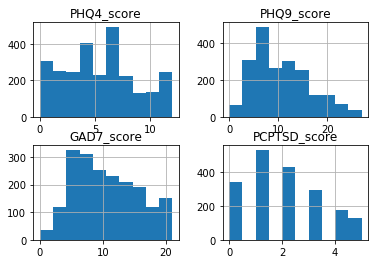

In [88]:
data = account_instance[stat_cols]
data = data[data!=-1]
print('Complete assessments:')
print('Assessment score count:',data.count())
print('Assessment score mean:',data.mean())
print('Assessment score median:',data.median())
print('Assessment score std. dev.:',data.std())
data.hist()

Complete assessments associated with a complete instance:
Assessment score count: PHQ4_score      2465
PHQ9_score      1909
GAD7_score      1907
PCPTSD_score    1907
dtype: int64
Assessment score mean: PHQ4_score       5.3189
PHQ9_score      10.6045
GAD7_score      10.5826
PCPTSD_score     1.9067
dtype: float64
Assessment score median: PHQ4_score       5.0
PHQ9_score       9.0
GAD7_score      10.0
PCPTSD_score     2.0
dtype: float64
Assessment score std. dev.: PHQ4_score      3.2888
PHQ9_score      5.6465
GAD7_score      4.8988
PCPTSD_score    1.4572
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b37f790>,
      dtype=object)

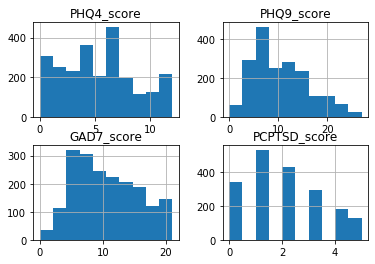

In [89]:
data = account_instance[account_instance['instance_complete']==1][stat_cols]
data = data[data!=-1]
print('Complete assessments associated with a complete instance:')
print('Assessment score count:',data.count())
print('Assessment score mean:',data.mean())
print('Assessment score median:',data.median())
print('Assessment score std. dev.:',data.std())
data.hist()

#### All Severities

In [90]:
instance_data = account_instance[account_instance['PHQ4_complete']==1]
instance_data_noSymptoms = instance_data[instance_data['PHQ4_severity']!= 'no_symptoms']

In [91]:
instance_data.head(2)

instance_id  \
0  000df8c8-7a8b-4060-a06a-27f65d2d2fd9_0   
2  00242b81-b10b-4425-84cf-21aa4da6e18d_0   

                             account_id  num_instance_sessions  PHQ4_attempts  \
0  000df8c8-7a8b-4060-a06a-27f65d2d2fd9                      5              1   
2  00242b81-b10b-4425-84cf-21aa4da6e18d                      4              1   

   PHQ9_attempts  GAD7_attempts  PCPTSD_attempts  PHQ4_complete  \
0              2              1                1              1   
2              1              1                1              1   

   PHQ9_complete  GAD7_complete  PCPTSD_complete  PHQ4_score  PHQ9_score  \
0              1              1                1          10          12   
2              1              1                1           3           4   

   GAD7_score  PCPTSD_score PHQ4_severity PHQ9_severity GAD7_severity  \
0          16             2        severe      moderate        severe   
2           5             2          mild   no_symptoms          mild   

  PCPTSD_severity  crisis crisis_text  crisis_value  instance_complete  \
0     no_symptoms       0                         0                  1   
2     no_symptoms       0                         0                  1   

  escalation escalation_provider                       start_time  \
0   moderate     psychotherapist 2022-02-20 01:52:12.942990+00:00   
2       mild    resilience_coach 2021-01-04 16:35:12.603321+00:00   

                     complete_time                     last_updated  
0 2022-02-20 01:58:59.671561+00:00 2022-02-20 01:58:59.671561+00:00  
2 2021-01-04 16:41:38.151380+00:00 2021-01-04 16:41:38.151380+00:00

In [92]:
PHQ4_summary = pd.concat([instance_data['PHQ4_severity'].value_counts(0),instance_data['PHQ4_severity'].value_counts(1)], axis=1)
PHQ9_summary = pd.concat([instance_data_noSymptoms['PHQ9_severity'].value_counts(0),instance_data_noSymptoms['PHQ9_severity'].value_counts(1)], axis=1)
GAD7_summary = pd.concat([instance_data_noSymptoms['GAD7_severity'].value_counts(0),instance_data_noSymptoms['GAD7_severity'].value_counts(1)], axis=1)
PCPTSD_summary = pd.concat([instance_data_noSymptoms['PCPTSD_severity'].value_counts(0),instance_data_noSymptoms['PCPTSD_severity'].value_counts(1)], axis=1)
escalation_summary = pd.concat([instance_data['escalation'].value_counts(0),instance_data['escalation'].value_counts(1)], axis=1)

In [93]:
assessment_summary = pd.concat([PHQ4_summary,PHQ9_summary,GAD7_summary,PCPTSD_summary,escalation_summary],axis=1)
assessment_summary.columns = ['_'.join(item) for item in list(zip(assessment_summary.columns,['count','pct']*5))]

In [94]:
assessment_summary

PHQ4_severity_count  PHQ4_severity_pct  \
mild                                886.0             0.3310   
moderate                            718.0             0.2682   
no_symptoms                         558.0             0.2084   
severe                              515.0             0.1924   
moderately_severe                     NaN                NaN   
inconclusive                          NaN                NaN   
followup_efficiency                   NaN                NaN   
followup_sensitivity                  NaN                NaN   

                      PHQ9_severity_count  PHQ9_severity_pct  \
mild                                755.0             0.3563   
moderate                            522.0             0.2463   
no_symptoms                         241.0             0.1137   
severe                              179.0             0.0845   
moderately_severe                   316.0             0.1491   
inconclusive                        106.0             0.0500   
followup_efficiency                   NaN                NaN   
followup_sensitivity                  NaN                NaN   

                      GAD7_severity_count  GAD7_severity_pct  \
mild                                756.0             0.3568   
moderate                            572.0             0.2699   
no_symptoms                         155.0             0.0731   
severe                              463.0             0.2185   
moderately_severe                     NaN                NaN   
inconclusive                        173.0             0.0816   
followup_efficiency                   NaN                NaN   
followup_sensitivity                  NaN                NaN   

                      PCPTSD_severity_count  PCPTSD_severity_pct  \
mild                                    NaN                  NaN   
moderate                                NaN                  NaN   
no_symptoms                          1308.0               0.6173   
severe                                  NaN                  NaN   
moderately_severe                       NaN                  NaN   
inconclusive                          209.0               0.0986   
followup_efficiency                   308.0               0.1454   
followup_sensitivity                  294.0               0.1387   

                      escalation_count  escalation_pct  
mild                            1111.0          0.4150  
moderate                        1141.0          0.4262  
no_symptoms                        NaN             NaN  
severe                           213.0          0.0796  
moderately_severe                  NaN             NaN  
inconclusive                     212.0          0.0792  
followup_efficiency                NaN             NaN  
followup_sensitivity               NaN             NaN

In [95]:
assessment_summary.sum()

PHQ4_severity_count      2677.0
PHQ4_severity_pct           1.0
PHQ9_severity_count      2119.0
PHQ9_severity_pct           1.0
GAD7_severity_count      2119.0
GAD7_severity_pct           1.0
PCPTSD_severity_count    2119.0
PCPTSD_severity_pct         1.0
escalation_count         2677.0
escalation_pct              1.0
dtype: float64

In [96]:
assessment_summary.to_csv(CHART_PATH + 'assessment_severity_summary_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

#### PHQ4

In [97]:
data = account_instance[account_instance['PHQ4_complete']==1]
print('Complete PHQ4:')
print('Scores:') 
print(data.PHQ4_score.value_counts().sort_index())
print('Severity:')
print(data.PHQ4_severity.value_counts())

Complete PHQ4:
Scores:
0     146
1     161
2     251
3     246
4     408
5     232
6     285
7     209
8     224
9     130
10    138
11    102
12    145
Name: PHQ4_score, dtype: int64
Severity:
mild           886
moderate       718
no_symptoms    558
severe         515
Name: PHQ4_severity, dtype: int64


In [98]:
data = account_instance[account_instance['instance_complete']==1]
print('Complete PHQ4 associated with a complete instance:')
print('Scores:')
print(data.PHQ4_score.value_counts().sort_index())
print('Severity:')
print(data.PHQ4_severity.value_counts())

Complete PHQ4 associated with a complete instance:
Scores:
0     146
1     161
2     251
3     229
4     364
5     208
6     265
7     189
8     197
9     115
10    125
11     89
12    126
Name: PHQ4_score, dtype: int64
Severity:
mild           801
moderate       651
no_symptoms    558
severe         455
Name: PHQ4_severity, dtype: int64


#### PHQ4 --> PHQ9

In [99]:
print(account_instance[account_instance['PHQ4_severity']=='mild']['PHQ9_severity'].value_counts())
print(account_instance[account_instance['PHQ4_severity']=='moderate']['PHQ9_severity'].value_counts())
print(account_instance[account_instance['PHQ4_severity']=='severe']['PHQ9_severity'].value_counts())

mild                 476
no_symptoms          205
moderate             133
inconclusive          49
moderately_severe     23
Name: PHQ9_severity, dtype: int64
moderate             270
mild                 252
moderately_severe    112
no_symptoms           36
inconclusive          32
severe                16
Name: PHQ9_severity, dtype: int64
moderately_severe    181
severe               163
moderate             119
mild                  27
inconclusive          25
Name: PHQ9_severity, dtype: int64


## Instance Flow
* **All Instances**
    * Comprehensive Flow Diagram: start-->PHQ4-->PHQ9-->GAD7-->PCPTSD-->escalation-->recommendation-->booking
        * phq4-->severity[no_symptoms]-->escalation[mild]
        * phq4-->severity[!no_symptoms]-->phq9-->severity[...]-->severity[...]-->gad7-->severity[...]-->pcptsd-->escalation[mild,moderate,severe]
        * phq9-->q9[>0]-->crisis[True]
        * phq9-->q9[==0]-->crisis[False]
    
* **Analysis Ideas - Last Updated 12/10/2021**
    * look at attempts and scores
    * unstack and/or aggregate at different levels
    * explore heatmaps / clustermaps
    * Frequent itemset could be interesting here
    * correlation of assessment severities/scores with escalation
        * can predict escalation?
        * can predict escalation from individual question level?
    * Similar severity/score rows
        * jaccard dist; cosine dist
        * clustering and looking at cluster agreement / properties

    * crisis (**COMPLETE 12/08/2021**)
        * crisis ratio: crisis/count 
        * crisis value group mean: q9_value_sum/count
        * crisis value flag mean: q9_value_sum/crisis
    * other session/instance/account columns: session_attempts, instance_complete, etc.
    * account- and appointment-level info
        * num appointments 
        * num appointments by provider
        * recommendation provider vs first-appointment-provider match (binary)
            * low availability recommendation?
            * can check for actual availability with historic supply data (may help identify demand)
        * recommendation-provider appointment-provider alignment 
            * ordinal based on distance +-1 from reccommendation
            * can be one time, sum of all deviations, avg. of deviations, median deviation, etc.
                * can weight by availability level

In [100]:
# Note 12/07/2021: 
    # add assessment scores to dataframe
    # sort severity labels via pandas categorical datatype (see tab)

In [101]:
# Instance flow parameters
subset_cols = ['PHQ4_severity','PHQ9_severity','GAD7_severity','PCPTSD_severity','escalation','crisis','crisis_value']
group_cols = ['PHQ4_severity','PHQ9_severity','GAD7_severity','PCPTSD_severity','escalation']
agg_dict= {'count':'sum','crisis':'sum','crisis_value':'sum'}

# Categorical index custom sort order
PHQ4_cat_order = ['no_symptoms', 'mild', 'moderate', 'severe','inconclusive']
PHQ9_cat_order = ['no_symptoms', 'mild', 'moderate', 'moderately_severe', 'severe','inconclusive']
GAD7_cat_order = ['no_symptoms', 'mild', 'moderate', 'severe','inconclusive']
PCPTSD_cat_order = ['no_symptoms', 'followup_sensitivity', 'followup_efficiency', 'inconclusive']
ESC_cat_order = ['mild', 'moderate', 'severe','inconclusive']

cat_order_dict = {0:PHQ4_cat_order, 1:PHQ9_cat_order, 2:GAD7_cat_order, 3:PCPTSD_cat_order, 4:ESC_cat_order}

In [102]:
# Get instance flow via grouping by severity
def get_instance_flow(subset_cols, group_cols, agg_dict):
    instance_subset = account_instance[subset_cols].copy()
    instance_subset['count'] = 1

    instance_flow = instance_subset.groupby(group_cols, sort=False).agg(agg_dict)
    instance_flow = instance_flow.rename(columns={'crisis_value':'crisis_value_sum'})
    instance_flow['crisis_value_group_mean'] = instance_flow['crisis_value_sum']/instance_flow['count']
    instance_flow['crisis_value_flag_mean'] = instance_flow['crisis_value_sum']/instance_flow['crisis']
    instance_flow['crisis_ratio'] = instance_flow['crisis']/instance_flow['count']
    
    for idx_level in range(len(group_cols)):
        level_cat_idx = pd.CategoricalIndex(instance_flow.index.levels[idx_level].values, 
                                            categories=cat_order_dict[idx_level], 
                                            ordered=True)
        instance_flow.index = instance_flow.index.set_levels(level_cat_idx, level=idx_level)
    
    instance_flow = instance_flow.sort_index()
    
    return instance_subset,instance_flow

In [103]:
instance_subset,instance_flow = get_instance_flow(subset_cols, group_cols, agg_dict)

instance_subset.to_csv(MASTER_DATA_PATH + 'instance_subset_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')
instance_flow.to_csv(MASTER_DATA_PATH + 'instance_flow_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [104]:
print(len(instance_flow))
print(instance_flow[['count','crisis']].sum())
instance_flow.head()

172
count     10707
crisis      335
dtype: int64


count  \
PHQ4_severity PHQ9_severity     GAD7_severity PCPTSD_severity      escalation          
no_symptoms   mild              inconclusive  inconclusive         mild            1   
              moderately_severe inconclusive  inconclusive         mild            1   
              inconclusive      inconclusive  inconclusive         mild          556   
mild          no_symptoms       no_symptoms   no_symptoms          mild           45   
                                              followup_sensitivity moderate        2   

                                                                               crisis  \
PHQ4_severity PHQ9_severity     GAD7_severity PCPTSD_severity      escalation           
no_symptoms   mild              inconclusive  inconclusive         mild             1   
              moderately_severe inconclusive  inconclusive         mild             0   
              inconclusive      inconclusive  inconclusive         mild             0   
mild          no_symptoms       no_symptoms   no_symptoms          mild             2   
                                              followup_sensitivity moderate         0   

                                                                               crisis_value_sum  \
PHQ4_severity PHQ9_severity     GAD7_severity PCPTSD_severity      escalation                     
no_symptoms   mild              inconclusive  inconclusive         mild                       1   
              moderately_severe inconclusive  inconclusive         mild                       0   
              inconclusive      inconclusive  inconclusive         mild                       0   
mild          no_symptoms       no_symptoms   no_symptoms          mild                       2   
                                              followup_sensitivity moderate                   0   

                                                                               crisis_value_group_mean  \
PHQ4_severity PHQ9_severity     GAD7_severity PCPTSD_severity      escalation                            
no_symptoms   mild              inconclusive  inconclusive         mild                         1.0000   
              moderately_severe inconclusive  inconclusive         mild                         0.0000   
              inconclusive      inconclusive  inconclusive         mild                         0.0000   
mild          no_symptoms       no_symptoms   no_symptoms          mild                         0.0444   
                                              followup_sensitivity moderate                     0.0000   

                                                                               crisis_value_flag_mean  \
PHQ4_severity PHQ9_severity     GAD7_severity PCPTSD_severity      escalation                           
no_symptoms   mild              inconclusive  inconclusive         mild                           1.0   
              moderately_severe inconclusive  inconclusive         mild                           NaN   
              inconclusive      inconclusive  inconclusive         mild                           NaN   
mild          no_symptoms       no_symptoms   no_symptoms          mild                           1.0   
                                              followup_sensitivity moderate                       NaN   

                                                                               crisis_ratio  
PHQ4_severity PHQ9_severity     GAD7_severity PCPTSD_severity      escalation                
no_symptoms   mild              inconclusive  inconclusive         mild              1.0000  
              moderately_severe inconclusive  inconclusive         mild              0.0000  
              inconclusive      inconclusive  inconclusive         mild              0.0000  
mild          no_symptoms       no_symptoms   no_symptoms          mild              0.0444  
                                              followup_sensitivity moderate          0.0000

## Sankey: Nodes and Links
* Development tasks:
    * add new level 0 index to clean up node code
    * make node and link separate functions
    * rewrite links function to handle phq4 = no symptoms
    * set node position in function (as separate function) by flow_data.sum() at each level
    * make nodes selectable to filter pathway highlighting
        * highliht **all** paths going through selected/hovered node
    * add edge color modes (crisis flag only, labels/colors for esc estimate at each level - might make groups larger)
    
* Custom Filtering:
    * **account_instance:** 
        * add filtering cols: account_source_id, dayofweek, timeofday, yearmonth, etc.
        * rows represent individual **instances** attempted/completed by *individual patients*
            * use **indicator cols** (pd.get_dummies) to allow for aggregation to instance_flow data
            * each **filtering col** corresponds to an **indicator col group**
            * each **indicator col** in an indicator col group corresponds to a specific **filtering criteria**
            * Example: filtering col: dayofweek; indicator col group: [mon,tue,wed,thu,fri,sat,sun]; indicator col=fri: filter for instances occurring on Friday
    * **instance_flow:** 
        * extract assessment pathways by grouping account_instance data by assessment severities; aggregate count and indicator columns
        * rows represent individual **assessment pathways** flowed through by *groups of patients*
            * **instances** correspond to specific **assessment pathways** (sequences of assessment severities)
            * each **assessment pathway** (row) will have **values** for all indicator cols
            * indicator col **values** represent the number of *individual patients* flowing through that **assessment pathway** 
            * indicator col **groups** (for example, all dayofweek cols) should sum to the total count for that **assessment pathway**
    * **sankey_data (nodes, links):** 
        * extract node and link data at each level of instance_flow; each level will have the same number of links and the same link values
        * rows represent individual **nodes** or **links** corresponding to one or more *assessment pathways*
            * each **link** will have the same indicator col values as its **assessment pathway**
            * indicator col **values** represent the number of *individual patients* flowing through that **link** in the **assessment pathway**
            
    * Notes:
        * single col filtering cn be done at the instance_flow or node/link level
        * multi-col filtering must be done at the account_instance level
        * code needs to be able to handle account_instance level filtering (i.e. functions must work together in one call)
        

In [105]:
import plotly.graph_objects as go

In [106]:
NODE_ALPHA = '0.8'
LINK_ALPHA = '0.2'
DEFAULT_ALPHA = '0.5'

RGB_GREY = '192,192,192'
RGB_RED = '255,0,0'
RGB_GREEN = '0,255,0'
RGB_BLUE = '0,0,255'
RGB_ORANGE = '255,128,0'
RGB_MAGENTA = '204,0,102'

In [107]:
color_dict = {'start':RGB_GREY,'no_symptoms':RGB_BLUE,'mild':RGB_GREEN,
              'moderate':RGB_ORANGE,'moderately_severe':RGB_MAGENTA,'severe':RGB_RED,
              'inconclusive':RGB_GREY,'followup_sensitivity':RGB_ORANGE,'followup_efficiency':RGB_RED}
link_label_dict = {'path':1, 'escalation':1, 'cohort':1}

In [108]:
def get_element_color(data, element):
    # Get element type
    if element == 'node':
        alpha = NODE_ALPHA
    elif element == 'link':
        alpha = LINK_ALPHA
    else:
        print('Invalid element type! Accepted types are node or link - setting default alpha value.')
        alpha = DEFAULT_ALPHA
        
    # get color string    
    if type(data) == str:
        color = 'rgba(' + color_dict[data] + ',' + alpha + ')'
    elif type(data) == list:
        color = ['rgba(' + color_dict[item] + ',' + alpha + ')' for item in data]
    else:
        print('Invalid data type! Accepted types are string or list - setting default color.')
        color = ''
    
    return color

In [109]:
def get_link_labels(flow_data, link_paths, link_label):
    # Check for valid label
    try:
        link_label_dict[link_label]
        
        if link_label == 'path':
            link_labels = link_paths
        elif link_label == 'escalation':
            link_labels = flow_data.index.get_level_values('escalation').to_list()
        elif link_label == 'cohort':
            link_labels = link_paths #UPDATE TO PT COHORTS VIA COS SIMILARITY OF ASSESSMENT SCORES
    except:
        print('Invalid link label mode - using default path labeling')
        link_labels = link_paths
        
    return link_labels

In [110]:
#### NOTE: MAKE PATH LABELING DEFAULT (TO HANDLE NO_SYMPTOMS) AND ADD COL TO DATAFRAME LINKS['PATH']
#### NOTE: IN DATAFRAME, LINKS['LABEL'] WILL BE ASSIGNED BASED ON LINK_LABEL PARAM VALUE

In [111]:
"""
# Description:  Column-wise node and link extraction from multi-index dataframe
# Pros: Faster, vectorized implementation compared to row-wise extraction
# Limitations: Assumes nodes are grouped into levels (flow can only pass through one node per level); levels have a strict, global order (flow is directed); each level must have a value (flow can not skip a level by default)
# Notes: a row-wise extraction can relax any/all of the above assumptions 

"""


def get_sankey_data(flow_data, complete_PHQ4=True, link_label='path', link_color='target'):
    # Initialize data structures
    node_idx_dict = dict()
    node_dict = {'severity':[],'label':[],'color':[],'idx':[],'level':[]}
    link_dict = {'source':[],'target':[],'color':[],'path':[],'label':[],'value':[],'level':[]}
    
    # Filter PHQ4
    if complete_PHQ4:
        flow_data = flow_data[flow_data.index.get_level_values(0) !='inconclusive']
    # Static flow data
    link_paths = ['-->'.join(item) for item in flow_data.index.to_list()]
    link_labels = get_link_labels(flow_data, link_paths, link_label)   
    link_values = flow_data['count'].to_list()

    # Process each level to extract nodes and links
    num_levels = len(flow_data.index.levels)
    for level in range(num_levels):
        assessment = flow_data.index.levels[level].name.split('_')[0]

        # Nodes
        if level == 0:
            node_dict['severity'].append('start')
            node_dict['label'].append('Assessment Start')
            node_dict['color'].append(get_element_color('start','node'))
            node_dict['idx'].append(0)
            node_dict['level'].append(level)
            node_idx_dict['Assessment Start'] = 0

        node_severity = flow_data.index.levels[level].categories.to_list()
        node_label = [assessment + ': ' + item for item in node_severity]
        node_color = get_element_color(node_severity, 'node')
        node_idx = [item + len(node_dict['idx']) for item in range(len(node_severity))]
        node_levels = [level]*len(node_severity)

        node_dict['severity'] += node_severity
        node_dict['label'] += node_label
        node_dict['color'] += node_color
        node_dict['idx'] += node_idx
        node_dict['level'] += node_levels
        node_idx_dict.update(dict(zip(node_label,node_idx)))


        # Links
        link_data = flow_data.index.get_level_values(level).to_list()
        link_node_labels = [assessment + ': ' + item for item in link_data]
        link_levels = [level]*len(link_data)

        if level == 0:
            # Assessment start --> PHQ4
            link_dict['source'] += [node_idx_dict[item] for item in ['Assessment Start']*len(link_node_labels)]
        if level != num_levels - 1:
            # current assessment --> next assessment
            link_dict['source'] += [node_idx_dict[item] for item in link_node_labels]

        link_dict['target'] += [node_idx_dict[item] for item in link_node_labels]
        link_dict['color'] += get_element_color(link_data,'link')
        link_dict['path'] += link_paths
        link_dict['label'] += link_labels
        link_dict['value'] += link_values
        link_dict['level'] += link_levels

    # Create dataframes to hold node and link data
    nodes = pd.DataFrame(node_dict)
    links = pd.DataFrame(link_dict)

    # shorten no_symptoms PHQ4 path (skip "inconclusive" labels for intermediate assessments)
    links_no_symptoms = links[links['path'].str.startswith('no_symptoms')]
    links_other = links[~links['path'].str.startswith('no_symptoms')]
    num_unique_pathways = len(links_no_symptoms.path.unique())

    links_no_symptoms_start = links_no_symptoms.iloc[:num_unique_pathways].copy()
    links_no_symptoms_end = links_no_symptoms.iloc[-num_unique_pathways:].copy()
    links_no_symptoms_end.loc[:,'source'] = links_no_symptoms_start.loc[:,'target'].values
    links_no_symptoms = pd.concat([links_no_symptoms_start,links_no_symptoms_end])
    #links_no_symptoms['path'] = 'no_symptoms-->mild'

    # Get final links
    links = pd.concat([links_no_symptoms,links_other]).reset_index(drop=True)

    return nodes,links

In [112]:
def get_sankey_diagram(nodes, links, title):
    fig = go.Figure(
        data = [go.Sankey(
            valueformat = "4d",
            valuesuffix = " Patients",
            # Define nodes
            node = dict(
              pad = 15,
              thickness = 15,
              line = dict(color = "black", width = 0.5),
              label =  nodes['label'].to_list(),
              color =  nodes['color'].to_list()
            ),
            # Add links
            link = dict(
              source = links['source'].to_list(),
              target = links['target'].to_list(),
              value = links['value'].to_list(),
              label = links['label'].to_list(),
              color = links['color'].to_list()))],
        layout = dict(
            height = 800,
            width = 1000
        )
    )

    fig.update_layout(title_text=title,
                      font_size=10)
    fig.show()

### Sankey Diagrams

#### Diagram 1
* link labels: full path
* link colors: target node

In [113]:
# Get sankey data
nodes,links = get_sankey_data(instance_flow,complete_PHQ4=True,link_label='path',link_color='target')

# Save data
nodes.to_csv(SANKEY_DATA_PATH + 'nodes_path_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')
links.to_csv(SANKEY_DATA_PATH + 'links_path_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [114]:
print(len(nodes))
nodes.head()

25


severity              label                  color  idx  level
0        start   Assessment Start  rgba(192,192,192,0.8)    0      0
1  no_symptoms  PHQ4: no_symptoms      rgba(0,0,255,0.8)    1      0
2         mild         PHQ4: mild      rgba(0,255,0,0.8)    2      0
3     moderate     PHQ4: moderate    rgba(255,128,0,0.8)    3      0
4       severe       PHQ4: severe      rgba(255,0,0,0.8)    4      0

In [115]:
print(len(links))
links.head()

846


source  target              color  \
0       0       1  rgba(0,0,255,0.2)   
1       0       1  rgba(0,0,255,0.2)   
2       0       1  rgba(0,0,255,0.2)   
3       1      21  rgba(0,255,0,0.2)   
4       1      21  rgba(0,255,0,0.2)   

                                                path  \
0  no_symptoms-->mild-->inconclusive-->inconclusi...   
1  no_symptoms-->moderately_severe-->inconclusive...   
2  no_symptoms-->inconclusive-->inconclusive-->in...   
3  no_symptoms-->mild-->inconclusive-->inconclusi...   
4  no_symptoms-->moderately_severe-->inconclusive...   

                                               label  value  level  
0  no_symptoms-->mild-->inconclusive-->inconclusi...      1      0  
1  no_symptoms-->moderately_severe-->inconclusive...      1      0  
2  no_symptoms-->inconclusive-->inconclusive-->in...    556      0  
3  no_symptoms-->mild-->inconclusive-->inconclusi...      1      4  
4  no_symptoms-->moderately_severe-->inconclusive...      1      4

In [116]:
title = "Cobalt: Patient Assessment Flow and Escalation"
get_sankey_diagram(nodes, links, title)

#### Diagram 2
* link labels: escalation
* link colors: target node

In [117]:
# Get sankey data
nodes,links = get_sankey_data(instance_flow,complete_PHQ4=True,link_label='escalation',link_color='target')

# Save data
nodes.to_csv(SANKEY_DATA_PATH + 'nodes_esc_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')
links.to_csv(SANKEY_DATA_PATH + 'links_esc_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [118]:
print(len(nodes))
nodes.head()

25


severity              label                  color  idx  level
0        start   Assessment Start  rgba(192,192,192,0.8)    0      0
1  no_symptoms  PHQ4: no_symptoms      rgba(0,0,255,0.8)    1      0
2         mild         PHQ4: mild      rgba(0,255,0,0.8)    2      0
3     moderate     PHQ4: moderate    rgba(255,128,0,0.8)    3      0
4       severe       PHQ4: severe      rgba(255,0,0,0.8)    4      0

In [119]:
print(len(links))
links.head()

846


source  target              color  \
0       0       1  rgba(0,0,255,0.2)   
1       0       1  rgba(0,0,255,0.2)   
2       0       1  rgba(0,0,255,0.2)   
3       1      21  rgba(0,255,0,0.2)   
4       1      21  rgba(0,255,0,0.2)   

                                                path label  value  level  
0  no_symptoms-->mild-->inconclusive-->inconclusi...  mild      1      0  
1  no_symptoms-->moderately_severe-->inconclusive...  mild      1      0  
2  no_symptoms-->inconclusive-->inconclusive-->in...  mild    556      0  
3  no_symptoms-->mild-->inconclusive-->inconclusi...  mild      1      4  
4  no_symptoms-->moderately_severe-->inconclusive...  mild      1      4

In [120]:
title = "Cobalt: Patient Assessment Flow and Escalation"
get_sankey_diagram(nodes, links, title)

#### Sankey Summary Stats
* Instances and included data, instance flow and link properties, account source distribution

In [121]:
# Account instance data (account_instance-->instance_flow-->sankey[nodes,links])
print('All instances:',len(account_instance.account_id))
print('\tUnique accounts associated with all instances:',len(account_instance.account_id.unique()))

print('Instances with complete PHQ4',len(account_instance[account_instance['PHQ4_complete']==1].account_id))
print('\tUnique accounts associated with complete PHQ4',len(account_instance[account_instance['PHQ4_complete']==1].account_id.unique()))

print('Instances with escalation:',len(account_instance[account_instance['instance_complete']==1].account_id))
print('\tUnique accounts associated with instances with escalations:',len(account_instance[account_instance['instance_complete']==1].account_id.unique()))

All instances: 10707
	Unique accounts associated with all instances: 7877
Instances with complete PHQ4 2677
	Unique accounts associated with complete PHQ4 2541
Instances with escalation: 2465
	Unique accounts associated with instances with escalations: 2422


In [122]:
# Instance flow and Sankey data
print('Total flow volume (patients):',instance_flow[instance_flow.index.get_level_values(0) != 'inconclusive']['count'].sum())
print('Total link wieght per level (patients):',links[links['source']==0]['value'].sum())
print('\tTotal links per level (unique assessment pathways):',len(links[links['source']==0]['value']))

Total flow volume (patients): 2677
Total link wieght per level (patients): 2677
	Total links per level (unique assessment pathways): 171


## Session Outcomes
* A session outcome is a score on a **completed** session assessment. 

### PHQ4

#### Score Distribution

In [123]:
# Score distribution
PHQ4_data = account_instance[account_instance['PHQ4_score']!= -1]['PHQ4_score'].value_counts().sort_index()
PHQ4_data.to_csv(MASTER_DATA_PATH + 'PHQ4_hist_allTime_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [124]:
print(len(PHQ4_data))
PHQ4_data.head(2)

13


0    146
1    161
Name: PHQ4_score, dtype: int64

#### Time Series

In [125]:
# Get score dates
PHQ4_scores_dates = account_instance[account_instance['PHQ4_score']!= -1][['account_id','PHQ4_score','crisis','last_updated']].copy()
PHQ4_scores_dates = PHQ4_scores_dates.rename(columns={'PHQ4_score':'answer_value','last_updated':'created_session_answer',})

# Adjust columns
PHQ4_scores_dates['year'] = PHQ4_scores_dates['created_session_answer'].dt.year
PHQ4_scores_dates['month'] = PHQ4_scores_dates['created_session_answer'].dt.month
PHQ4_scores_dates['week'] = PHQ4_scores_dates['created_session_answer'].dt.week
PHQ4_scores_dates['day'] = PHQ4_scores_dates['created_session_answer'].dt.day
PHQ4_scores_dates['year_month'] = PHQ4_scores_dates['created_session_answer'].values.astype('datetime64[M]')
PHQ4_scores_dates['year_month_week'] = PHQ4_scores_dates['created_session_answer'].values.astype('datetime64[W]')
PHQ4_scores_dates['dayofyear'] = PHQ4_scores_dates['created_session_answer'].apply(lambda x: get_date_str(x))

# Save data
PHQ4_scores_dates.to_csv(MASTER_DATA_PATH + 'PHQ4_scores_dates_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [126]:
# Monthly time series data
PHQ4_ts_count = pd.DataFrame(PHQ4_scores_dates.groupby(['year','month']).count().answer_value)
PHQ4_ts_mean = pd.DataFrame(PHQ4_scores_dates.groupby(['year','month']).mean().answer_value)
PHQ4_ts_median = pd.DataFrame(PHQ4_scores_dates.groupby(['year','month']).median().answer_value)
PHQ4_ts_sum = pd.DataFrame(PHQ4_scores_dates.groupby(['year','month']).sum().crisis)
PHQ4_ts_data = PHQ4_ts_count.merge(
    PHQ4_ts_mean, how='inner', left_index=True, right_index=True).merge(
    PHQ4_ts_median, how='inner', left_index=True, right_index=True).merge(
    PHQ4_ts_sum, how='inner', left_index=True, right_index=True)
PHQ4_ts_data.columns = ['PHQ4_score_count', 'PHQ4_score_mean', 'PHQ4_score_median', 'PHQ4_crisis_count']

# Save data
PHQ4_ts_data.to_csv(MASTER_DATA_PATH + 'PHQ4_monthly_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [127]:
# Weekly time series data
PHQ4_weekly_ts_count = pd.DataFrame(PHQ4_scores_dates.groupby(['year_month_week']).count().answer_value)
PHQ4_weekly_ts_count.index = pd.MultiIndex.from_arrays([PHQ4_weekly_ts_count.index.year, 
                                                            PHQ4_weekly_ts_count.index.month, 
                                                            PHQ4_weekly_ts_count.index.day], 
                                                            names=['Year','Month','Week'])
PHQ4_weekly_ts_mean = pd.DataFrame(PHQ4_scores_dates.groupby(['year_month_week']).mean().answer_value)
PHQ4_weekly_ts_mean.index = pd.MultiIndex.from_arrays([PHQ4_weekly_ts_mean.index.year, 
                                                            PHQ4_weekly_ts_mean.index.month, 
                                                            PHQ4_weekly_ts_mean.index.day], 
                                                            names=['Year','Month','Week'])
PHQ4_weekly_ts_median = pd.DataFrame(PHQ4_scores_dates.groupby(['year_month_week']).median().answer_value)
PHQ4_weekly_ts_median.index = pd.MultiIndex.from_arrays([PHQ4_weekly_ts_median.index.year, 
                                                            PHQ4_weekly_ts_median.index.month, 
                                                            PHQ4_weekly_ts_median.index.day], 
                                                            names=['Year','Month','Week'])
PHQ4_weekly_ts_sum = pd.DataFrame(PHQ4_scores_dates.groupby(['year_month_week']).sum().crisis)
PHQ4_weekly_ts_sum.index = pd.MultiIndex.from_arrays([PHQ4_weekly_ts_sum.index.year, 
                                                            PHQ4_weekly_ts_sum.index.month, 
                                                            PHQ4_weekly_ts_sum.index.day], 
                                                            names=['Year','Month','Week'])

PHQ4_weekly_ts_data = PHQ4_weekly_ts_count.merge(
    PHQ4_weekly_ts_mean, how='inner', left_index=True, right_index=True).merge(
    PHQ4_weekly_ts_median, how='inner', left_index=True, right_index=True).merge(
    PHQ4_weekly_ts_sum, how='inner', left_index=True, right_index=True)
PHQ4_weekly_ts_data.columns = ['PHQ4_score_count', 'PHQ4_score_mean', 'PHQ4_score_median', 'PHQ4_crisis_count']

# Save data
PHQ4_weekly_ts_data.to_csv(MASTER_DATA_PATH + 'PHQ4_weekly_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [128]:
print(len(PHQ4_ts_data))
PHQ4_ts_data.head(2)

27


PHQ4_score_count  PHQ4_score_mean  PHQ4_score_median  \
year month                                                         
2020 4                   153           5.3791                5.0   
     5                   130           5.7615                5.0   

            PHQ4_crisis_count  
year month                     
2020 4                     23  
     5                     12

In [129]:
print(len(PHQ4_weekly_ts_data))
PHQ4_weekly_ts_data.head(2)

115


PHQ4_score_count  PHQ4_score_mean  PHQ4_score_median  \
Year Month Week                                                         
2020 4     9                   70           5.4571                6.0   
           16                  49           5.2857                5.0   

                 PHQ4_crisis_count  
Year Month Week                     
2020 4     9                    16  
           16                    6

### PHQ9

In [130]:
# Crisis question
PHQ9_crisis_response = account_session_answer[account_session_answer['crisis']==True].answer_text.value_counts()

#### Score Distribution

In [131]:
# Score distribution
PHQ9_data = account_instance[account_instance['PHQ9_score']!= -1]['PHQ9_score'].value_counts().sort_index()
PHQ9_data.to_csv(MASTER_DATA_PATH + 'PHQ9_hist_allTime_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [132]:
print(len(PHQ9_data))
PHQ9_data.head(2)

28


0     8
1    15
Name: PHQ9_score, dtype: int64

#### Time Series

In [133]:
# Get score dates
PHQ9_scores_dates = account_instance[account_instance['PHQ9_score']!= -1][['account_id','PHQ9_score','crisis','last_updated']].copy()
PHQ9_scores_dates = PHQ9_scores_dates.rename(columns={'PHQ9_score':'answer_value','last_updated':'created_session_answer',})

# Adjust columns
PHQ9_scores_dates['year'] = PHQ9_scores_dates['created_session_answer'].dt.year
PHQ9_scores_dates['month'] = PHQ9_scores_dates['created_session_answer'].dt.month
PHQ9_scores_dates['week'] = PHQ9_scores_dates['created_session_answer'].dt.week
PHQ9_scores_dates['day'] = PHQ9_scores_dates['created_session_answer'].dt.day
PHQ9_scores_dates['year_month'] = PHQ9_scores_dates['created_session_answer'].values.astype('datetime64[M]')
PHQ9_scores_dates['year_month_week'] = PHQ9_scores_dates['created_session_answer'].values.astype('datetime64[W]')
PHQ9_scores_dates['dayofyear'] = PHQ9_scores_dates['created_session_answer'].apply(lambda x: get_date_str(x))

# Save data
PHQ9_scores_dates.to_csv(MASTER_DATA_PATH + 'PHQ9_scores_dates_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [134]:
# Monthly time series data
PHQ9_ts_count = pd.DataFrame(PHQ9_scores_dates.groupby(['year','month']).count().answer_value)
PHQ9_ts_mean = pd.DataFrame(PHQ9_scores_dates.groupby(['year','month']).mean().answer_value)
PHQ9_ts_median = pd.DataFrame(PHQ9_scores_dates.groupby(['year','month']).median().answer_value)
PHQ9_ts_sum = pd.DataFrame(PHQ9_scores_dates.groupby(['year','month']).sum().crisis)
PHQ9_ts_data = PHQ9_ts_count.merge(
    PHQ9_ts_mean, how='inner', left_index=True, right_index=True).merge(
    PHQ9_ts_median, how='inner', left_index=True, right_index=True).merge(
    PHQ9_ts_sum, how='inner', left_index=True, right_index=True)
PHQ9_ts_data.columns = ['PHQ9_score_count', 'PHQ9_score_mean', 'PHQ9_score_median', 'PHQ9_crisis_count']

# Save data
PHQ9_ts_data.to_csv(MASTER_DATA_PATH + 'PHQ9_monthly_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [135]:
# Weekly time series data
PHQ9_weekly_ts_count = pd.DataFrame(PHQ9_scores_dates.groupby(['year_month_week']).count().answer_value)
PHQ9_weekly_ts_count.index = pd.MultiIndex.from_arrays([PHQ9_weekly_ts_count.index.year, 
                                                            PHQ9_weekly_ts_count.index.month, 
                                                            PHQ9_weekly_ts_count.index.day], 
                                                            names=['Year','Month','Week'])
PHQ9_weekly_ts_mean = pd.DataFrame(PHQ9_scores_dates.groupby(['year_month_week']).mean().answer_value)
PHQ9_weekly_ts_mean.index = pd.MultiIndex.from_arrays([PHQ9_weekly_ts_mean.index.year, 
                                                            PHQ9_weekly_ts_mean.index.month, 
                                                            PHQ9_weekly_ts_mean.index.day], 
                                                            names=['Year','Month','Week'])
PHQ9_weekly_ts_median = pd.DataFrame(PHQ9_scores_dates.groupby(['year_month_week']).median().answer_value)
PHQ9_weekly_ts_median.index = pd.MultiIndex.from_arrays([PHQ9_weekly_ts_median.index.year, 
                                                            PHQ9_weekly_ts_median.index.month, 
                                                            PHQ9_weekly_ts_median.index.day], 
                                                            names=['Year','Month','Week'])
PHQ9_weekly_ts_sum = pd.DataFrame(PHQ9_scores_dates.groupby(['year_month_week']).sum().crisis)
PHQ9_weekly_ts_sum.index = pd.MultiIndex.from_arrays([PHQ9_weekly_ts_sum.index.year, 
                                                            PHQ9_weekly_ts_sum.index.month, 
                                                            PHQ9_weekly_ts_sum.index.day], 
                                                            names=['Year','Month','Week'])

PHQ9_weekly_ts_data = PHQ9_weekly_ts_count.merge(
    PHQ9_weekly_ts_mean, how='inner', left_index=True, right_index=True).merge(
    PHQ9_weekly_ts_median, how='inner', left_index=True, right_index=True).merge(
    PHQ9_weekly_ts_sum, how='inner', left_index=True, right_index=True)
PHQ9_weekly_ts_data.columns = ['PHQ9_score_count', 'PHQ9_score_mean', 'PHQ9_score_median', 'PHQ9_crisis_count']

# Save data
PHQ9_weekly_ts_data.to_csv(MASTER_DATA_PATH + 'PHQ9_weekly_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [136]:
print(len(PHQ9_ts_data))
PHQ9_ts_data.head(2)

27


PHQ9_score_count  PHQ9_score_mean  PHQ9_score_median  \
year month                                                         
2020 4                   109          11.2661               10.0   
     5                    93          11.5914               10.0   

            PHQ9_crisis_count  
year month                     
2020 4                     23  
     5                     12

In [137]:
print(len(PHQ9_weekly_ts_data))
PHQ9_weekly_ts_data.head(2)

115


PHQ9_score_count  PHQ9_score_mean  PHQ9_score_median  \
Year Month Week                                                         
2020 4     9                   49          12.3265               10.0   
           16                  37          10.4865                9.0   

                 PHQ9_crisis_count  
Year Month Week                     
2020 4     9                    16  
           16                    6

### GAD7

#### Score Distribution

In [138]:
# Score distribution
GAD7_data = account_instance[account_instance['GAD7_score']!= -1]['GAD7_score'].value_counts().sort_index()
GAD7_data.to_csv(MASTER_DATA_PATH + 'GAD7_hist_allTime_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [139]:
print(len(GAD7_data))
GAD7_data.head(2)

22


0    1
1    8
Name: GAD7_score, dtype: int64

#### Time Series

In [140]:
# Get score dates
GAD7_scores_dates = account_instance[account_instance['GAD7_score']!= -1][['account_id','GAD7_score','crisis','last_updated']].copy()
GAD7_scores_dates = GAD7_scores_dates.rename(columns={'GAD7_score':'answer_value','last_updated':'created_session_answer',})

# Adjust columns
GAD7_scores_dates['year'] = GAD7_scores_dates['created_session_answer'].dt.year
GAD7_scores_dates['month'] = GAD7_scores_dates['created_session_answer'].dt.month
GAD7_scores_dates['week'] = GAD7_scores_dates['created_session_answer'].dt.week
GAD7_scores_dates['day'] = GAD7_scores_dates['created_session_answer'].dt.day
GAD7_scores_dates['year_month'] = GAD7_scores_dates['created_session_answer'].values.astype('datetime64[M]')
GAD7_scores_dates['year_month_week'] = GAD7_scores_dates['created_session_answer'].values.astype('datetime64[W]')
GAD7_scores_dates['dayofyear'] = GAD7_scores_dates['created_session_answer'].apply(lambda x: get_date_str(x))

# Save data
GAD7_scores_dates.to_csv(MASTER_DATA_PATH + 'GAD7_scores_dates_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [141]:
# Monthly time series data
GAD7_ts_count = pd.DataFrame(GAD7_scores_dates.groupby(['year','month']).count().answer_value)
GAD7_ts_mean = pd.DataFrame(GAD7_scores_dates.groupby(['year','month']).mean().answer_value)
GAD7_ts_median = pd.DataFrame(GAD7_scores_dates.groupby(['year','month']).median().answer_value)
GAD7_ts_sum = pd.DataFrame(GAD7_scores_dates.groupby(['year','month']).sum().crisis)
GAD7_ts_data = GAD7_ts_count.merge(
    GAD7_ts_mean, how='inner', left_index=True, right_index=True).merge(
    GAD7_ts_median, how='inner', left_index=True, right_index=True).merge(
    GAD7_ts_sum, how='inner', left_index=True, right_index=True)
GAD7_ts_data.columns = ['GAD7_score_count', 'GAD7_score_mean', 'GAD7_score_median', 'GAD7_crisis_count']

# Save data
GAD7_ts_data.to_csv(MASTER_DATA_PATH + 'GAD7_monthly_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [142]:
# Weekly time series data
GAD7_weekly_ts_count = pd.DataFrame(GAD7_scores_dates.groupby(['year_month_week']).count().answer_value)
GAD7_weekly_ts_count.index = pd.MultiIndex.from_arrays([GAD7_weekly_ts_count.index.year, 
                                                            GAD7_weekly_ts_count.index.month, 
                                                            GAD7_weekly_ts_count.index.day], 
                                                            names=['Year','Month','Week'])
GAD7_weekly_ts_mean = pd.DataFrame(GAD7_scores_dates.groupby(['year_month_week']).mean().answer_value)
GAD7_weekly_ts_mean.index = pd.MultiIndex.from_arrays([GAD7_weekly_ts_mean.index.year, 
                                                            GAD7_weekly_ts_mean.index.month, 
                                                            GAD7_weekly_ts_mean.index.day], 
                                                            names=['Year','Month','Week'])
GAD7_weekly_ts_median = pd.DataFrame(GAD7_scores_dates.groupby(['year_month_week']).median().answer_value)
GAD7_weekly_ts_median.index = pd.MultiIndex.from_arrays([GAD7_weekly_ts_median.index.year, 
                                                            GAD7_weekly_ts_median.index.month, 
                                                            GAD7_weekly_ts_median.index.day], 
                                                            names=['Year','Month','Week'])
GAD7_weekly_ts_sum = pd.DataFrame(GAD7_scores_dates.groupby(['year_month_week']).sum().crisis)
GAD7_weekly_ts_sum.index = pd.MultiIndex.from_arrays([GAD7_weekly_ts_sum.index.year, 
                                                            GAD7_weekly_ts_sum.index.month, 
                                                            GAD7_weekly_ts_sum.index.day], 
                                                            names=['Year','Month','Week'])

GAD7_weekly_ts_data = GAD7_weekly_ts_count.merge(
    GAD7_weekly_ts_mean, how='inner', left_index=True, right_index=True).merge(
    GAD7_weekly_ts_median, how='inner', left_index=True, right_index=True).merge(
    GAD7_weekly_ts_sum, how='inner', left_index=True, right_index=True)
GAD7_weekly_ts_data.columns = ['GAD7_score_count', 'GAD7_score_mean', 'GAD7_score_median', 'GAD7_crisis_count']

# Save data
GAD7_weekly_ts_data.to_csv(MASTER_DATA_PATH + 'GAD7_weekly_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [143]:
print(len(GAD7_ts_data))
GAD7_ts_data.head(2)

27


GAD7_score_count  GAD7_score_mean  GAD7_score_median  \
year month                                                         
2020 4                   100          11.3600               12.0   
     5                    90          11.6111               11.0   

            GAD7_crisis_count  
year month                     
2020 4                     18  
     5                     11

In [144]:
print(len(GAD7_weekly_ts_data))
GAD7_weekly_ts_data.head(2)

115


GAD7_score_count  GAD7_score_mean  GAD7_score_median  \
Year Month Week                                                         
2020 4     9                   41          12.0000               12.0   
           16                  36           9.8889                9.5   

                 GAD7_crisis_count  
Year Month Week                     
2020 4     9                    12  
           16                    5

### PC-PTSD

#### Score Distribution

In [145]:
# Score distribution
PCPTSD_data = account_instance[account_instance['PCPTSD_score']!= -1]['PCPTSD_score'].value_counts().sort_index()
PCPTSD_data.to_csv(MASTER_DATA_PATH + 'PCPTSD_hist_allTime_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [146]:
print(len(PCPTSD_data))
PCPTSD_data.head(2)

6


0    342
1    535
Name: PCPTSD_score, dtype: int64

#### Time Series

In [147]:
# Get score dates
PCPTSD_scores_dates = account_instance[account_instance['PCPTSD_score']!= -1][['account_id','PCPTSD_score','crisis','last_updated']].copy()
PCPTSD_scores_dates = PCPTSD_scores_dates.rename(columns={'PCPTSD_score':'answer_value','last_updated':'created_session_answer',})

# Adjust columns
PCPTSD_scores_dates['year'] = PCPTSD_scores_dates['created_session_answer'].dt.year
PCPTSD_scores_dates['month'] = PCPTSD_scores_dates['created_session_answer'].dt.month
PCPTSD_scores_dates['week'] = PCPTSD_scores_dates['created_session_answer'].dt.week
PCPTSD_scores_dates['day'] = PCPTSD_scores_dates['created_session_answer'].dt.day
PCPTSD_scores_dates['year_month'] = PCPTSD_scores_dates['created_session_answer'].values.astype('datetime64[M]')
PCPTSD_scores_dates['year_month_week'] = PCPTSD_scores_dates['created_session_answer'].values.astype('datetime64[W]')
PCPTSD_scores_dates['dayofyear'] = PCPTSD_scores_dates['created_session_answer'].apply(lambda x: get_date_str(x))

# Save data
PCPTSD_scores_dates.to_csv(MASTER_DATA_PATH + 'PCPTSD_scores_dates_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [148]:
# Monthly time series data
PCPTSD_ts_count = pd.DataFrame(PCPTSD_scores_dates.groupby(['year','month']).count().answer_value)
PCPTSD_ts_mean = pd.DataFrame(PCPTSD_scores_dates.groupby(['year','month']).mean().answer_value)
PCPTSD_ts_median = pd.DataFrame(PCPTSD_scores_dates.groupby(['year','month']).median().answer_value)
PCPTSD_ts_sum = pd.DataFrame(PCPTSD_scores_dates.groupby(['year','month']).sum().crisis)
PCPTSD_ts_data = PCPTSD_ts_count.merge(
    PCPTSD_ts_mean, how='inner', left_index=True, right_index=True).merge(
    PCPTSD_ts_median, how='inner', left_index=True, right_index=True).merge(
    PCPTSD_ts_sum, how='inner', left_index=True, right_index=True)
PCPTSD_ts_data.columns = ['PCPTSD_score_count', 'PCPTSD_score_mean', 'PCPTSD_score_median', 'PCPTSD_crisis_count']

# Save data
PCPTSD_ts_data.to_csv(MASTER_DATA_PATH + 'PCPTSD_monthly_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [149]:
# Weekly time series data
PCPTSD_weekly_ts_count = pd.DataFrame(PCPTSD_scores_dates.groupby(['year_month_week']).count().answer_value)
PCPTSD_weekly_ts_count.index = pd.MultiIndex.from_arrays([PCPTSD_weekly_ts_count.index.year, 
                                                            PCPTSD_weekly_ts_count.index.month, 
                                                            PCPTSD_weekly_ts_count.index.day], 
                                                            names=['Year','Month','Week'])
PCPTSD_weekly_ts_mean = pd.DataFrame(PCPTSD_scores_dates.groupby(['year_month_week']).mean().answer_value)
PCPTSD_weekly_ts_mean.index = pd.MultiIndex.from_arrays([PCPTSD_weekly_ts_mean.index.year, 
                                                            PCPTSD_weekly_ts_mean.index.month, 
                                                            PCPTSD_weekly_ts_mean.index.day], 
                                                            names=['Year','Month','Week'])
PCPTSD_weekly_ts_median = pd.DataFrame(PCPTSD_scores_dates.groupby(['year_month_week']).median().answer_value)
PCPTSD_weekly_ts_median.index = pd.MultiIndex.from_arrays([PCPTSD_weekly_ts_median.index.year, 
                                                            PCPTSD_weekly_ts_median.index.month, 
                                                            PCPTSD_weekly_ts_median.index.day], 
                                                            names=['Year','Month','Week'])
PCPTSD_weekly_ts_sum = pd.DataFrame(PCPTSD_scores_dates.groupby(['year_month_week']).sum().crisis)
PCPTSD_weekly_ts_sum.index = pd.MultiIndex.from_arrays([PCPTSD_weekly_ts_sum.index.year, 
                                                            PCPTSD_weekly_ts_sum.index.month, 
                                                            PCPTSD_weekly_ts_sum.index.day], 
                                                            names=['Year','Month','Week'])

PCPTSD_weekly_ts_data = PCPTSD_weekly_ts_count.merge(
    PCPTSD_weekly_ts_mean, how='inner', left_index=True, right_index=True).merge(
    PCPTSD_weekly_ts_median, how='inner', left_index=True, right_index=True).merge(
    PCPTSD_weekly_ts_sum, how='inner', left_index=True, right_index=True)
PCPTSD_weekly_ts_data.columns = ['PCPTSD_score_count', 'PCPTSD_score_mean', 'PCPTSD_score_median', 'PCPTSD_crisis_count']

# Save data
PCPTSD_weekly_ts_data.to_csv(MASTER_DATA_PATH + 'PCPTSD_weekly_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [150]:
print(len(PCPTSD_ts_data))
PCPTSD_ts_data.head(2)

27


PCPTSD_score_count  PCPTSD_score_mean  PCPTSD_score_median  \
year month                                                               
2020 4                     100             2.3100                  2.0   
     5                      87             2.3218                  2.0   

            PCPTSD_crisis_count  
year month                       
2020 4                       18  
     5                       11

In [151]:
print(len(PCPTSD_weekly_ts_data))
PCPTSD_weekly_ts_data.head(2)

115


PCPTSD_score_count  PCPTSD_score_mean  PCPTSD_score_median  \
Year Month Week                                                               
2020 4     9                     41             2.1951                  2.0   
           16                    36             2.3056                  2.0   

                 PCPTSD_crisis_count  
Year Month Week                       
2020 4     9                      12  
           16                      5

## Escalation Outcomes
* Develop platform-specific constructs: 
    * "treatment inertia": time to initiate treatment events 
    * "treatment density/spread": time between treatment events
    * "treatment scope/breadth": modalities of treatment events
    * "treatment endurance/longevity": lifetime of treatment events
    * "treatment journey/flow": evolution of treatment behavior 
    * "treatment efficacy"

In [152]:
# Pie chart
def get_pie_chart(data, title, save_name, explode_str=''):
    def format_text(pct, counts):
        absolute = int(np.round(pct/100.*np.sum(counts)))
        return "{:d}\n({:.1f}%)".format(absolute,pct)
    
    labels = data.index
    pie_data = data.iloc[:,0]
    explode = [0 if item!=explode_str else 0.1 for item in data.index.values]

    fig, ax = plt.subplots(figsize=(8,8), facecolor='whitesmoke')
    ax.pie(pie_data, explode=explode, labels=labels, autopct=lambda pct: format_text(pct, pie_data), 
           textprops=dict(color="black",size=14), shadow=False, startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    fig.suptitle(title, fontsize=18)

    save_figure(fig,FIGURE_PATH,save_name)
    plt.show()

In [153]:
# Get instance data
instance_data = account_instance[account_instance['instance_complete']==1].copy()

# Adjust columns
instance_data['year'] = instance_data['complete_time'].dt.year.copy()
instance_data['month'] = instance_data['complete_time'].dt.month
instance_data['week'] = instance_data['complete_time'].dt.week
instance_data['day'] = instance_data['complete_time'].dt.day
instance_data['year_month'] = instance_data['complete_time'].values.astype('datetime64[M]')
instance_data['year_month_week'] = instance_data['complete_time'].values.astype('datetime64[W]')
instance_data['dayofyear'] = instance_data['complete_time'].apply(lambda x: get_date_str(x))

# Time series data
instance_monthly_ts_data = pd.DataFrame(instance_data.groupby(['year','month']).count().instance_id)
instance_weekly_ts_data = pd.DataFrame(instance_data.groupby(['year_month_week']).count().instance_id)
instance_weekly_ts_data.index = pd.MultiIndex.from_arrays([instance_weekly_ts_data.index.year, 
                                                            instance_weekly_ts_data.index.month, 
                                                            instance_weekly_ts_data.index.day], 
                                                            names=['Year','Month','Week'])

# Time series data by escalation
instance_esc_monthly_ts_data = pd.DataFrame(instance_data.groupby(['year','month','escalation']).count().instance_id)
instance_esc_monthly_ts_data = instance_esc_monthly_ts_data.unstack().fillna(0).instance_id
instance_esc_monthly_ts_data.to_csv(CHART_PATH + 'instance_esc_monthly_ts_data_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

instance_esc_weekly_ts_data = pd.DataFrame(instance_data.groupby(['year_month_week', 'escalation']).count()).instance_id
instance_esc_weekly_ts_data = instance_esc_weekly_ts_data.unstack().fillna(0)
instance_esc_weekly_ts_data.index = pd.MultiIndex.from_arrays([instance_esc_weekly_ts_data.index.year, 
                                                      instance_esc_weekly_ts_data.index.month, 
                                                      instance_esc_weekly_ts_data.index.day], 
                                                      names=['Year','Month','Week'])
instance_esc_weekly_ts_data.to_csv(CHART_PATH + 'instance_esc_weekly_ts_data' + str(datetime.datetime.now().date()).replace('-','') + '.csv')


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [154]:
print(len(instance_data))
instance_data.head(2)

2465


instance_id  \
0  000df8c8-7a8b-4060-a06a-27f65d2d2fd9_0   
2  00242b81-b10b-4425-84cf-21aa4da6e18d_0   

                             account_id  num_instance_sessions  PHQ4_attempts  \
0  000df8c8-7a8b-4060-a06a-27f65d2d2fd9                      5              1   
2  00242b81-b10b-4425-84cf-21aa4da6e18d                      4              1   

   PHQ9_attempts  GAD7_attempts  PCPTSD_attempts  PHQ4_complete  \
0              2              1                1              1   
2              1              1                1              1   

   PHQ9_complete  GAD7_complete  PCPTSD_complete  PHQ4_score  PHQ9_score  \
0              1              1                1          10          12   
2              1              1                1           3           4   

   GAD7_score  PCPTSD_score PHQ4_severity PHQ9_severity GAD7_severity  \
0          16             2        severe      moderate        severe   
2           5             2          mild   no_symptoms          mild   

  PCPTSD_severity  crisis crisis_text  crisis_value  instance_complete  \
0     no_symptoms       0                         0                  1   
2     no_symptoms       0                         0                  1   

  escalation escalation_provider                       start_time  \
0   moderate     psychotherapist 2022-02-20 01:52:12.942990+00:00   
2       mild    resilience_coach 2021-01-04 16:35:12.603321+00:00   

                     complete_time                     last_updated  year  \
0 2022-02-20 01:58:59.671561+00:00 2022-02-20 01:58:59.671561+00:00  2022   
2 2021-01-04 16:41:38.151380+00:00 2021-01-04 16:41:38.151380+00:00  2021   

   month  week  day year_month year_month_week dayofyear  
0      2     7   20 2022-02-01      2022-02-17  20220220  
2      1     1    4 2021-01-01      2020-12-31  20210104

In [155]:
print(len(instance_monthly_ts_data))
instance_monthly_ts_data.head(2)

27


instance_id
year month             
2020 4              130
     5              116

In [156]:
print(len(instance_weekly_ts_data))
instance_weekly_ts_data.head(2)

115


instance_id
Year Month Week             
2020 4     9              54
           16             44

In [157]:
print(len(instance_esc_monthly_ts_data))
instance_esc_monthly_ts_data.head(2)

27


escalation  mild  moderate  severe
year month                        
2020 4        53        63      14
     5        51        51      14

In [158]:
print(len(instance_esc_weekly_ts_data))
instance_esc_weekly_ts_data.head(2)

115


escalation       mild  moderate  severe
Year Month Week                        
2020 4     9     19.0      24.0    11.0
           16    22.0      19.0     3.0

### Escalation Distribution

In [159]:
esc_dist = pd.concat([instance_data['escalation'].value_counts(0), 
                      instance_data['escalation'].value_counts(1)], axis=1)
esc_dist.columns = ['esc_count', 'esc_pct']
esc_dist = esc_dist.sort_index()
esc_dist

esc_count  esc_pct
mild           1111   0.4507
moderate       1141   0.4629
severe          213   0.0864

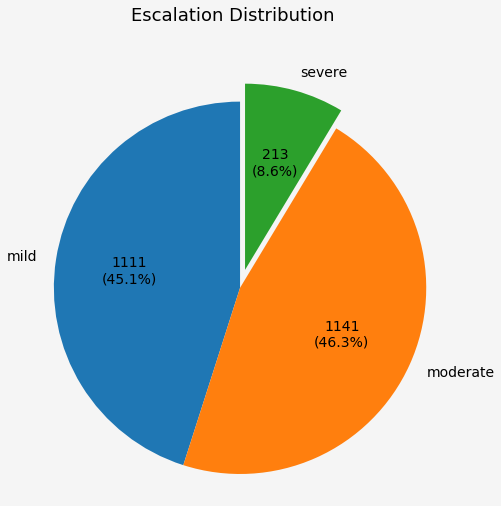

In [160]:
get_pie_chart(esc_dist, 'Escalation Distribution', 'esc_dist_', 'severe')

### Escalation-Account Distribution

#### All Accounts for All Time

In [161]:
# Account source data
account_source = pd.concat([account['account_source_id'].value_counts(0), 
                                 account['account_source_id'].value_counts(1)], axis=1)
account_source.columns = ['user_count', 'user_pct']
account_source = account_source.iloc[0:3]
account_source = account_source.sort_index()
account_source

user_count  user_pct
ANONYMOUS          26889    0.7518
PENN_KEY_SSO        3611    0.1010
PENN_SSO            5177    0.1447

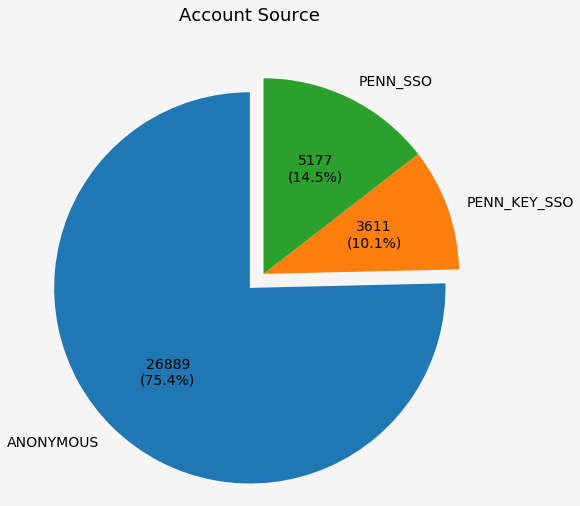

In [162]:
get_pie_chart(account_source, 'Account Source', 'account_source_', 'ANONYMOUS')

#### All Accounts in January 2022

In [163]:
# Account source data - jan2022
temp_account = account[(account['year']==2022)&(account['month']==1)]

temp_account_source = pd.concat([temp_account['account_source_id'].value_counts(0), 
                                 temp_account['account_source_id'].value_counts(1)], axis=1)
temp_account_source.columns = ['user_count', 'user_pct']
temp_account_source = temp_account_source.sort_index()
temp_account_source

user_count  user_pct
ANONYMOUS           1400    0.7071
PENN_KEY_SSO         467    0.2359
PENN_SSO             113    0.0571

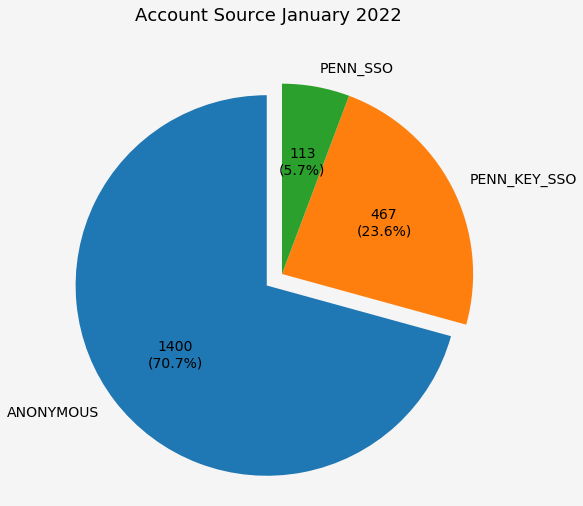

In [164]:
get_pie_chart(temp_account_source, 'Account Source January 2022', 'account_source_jan2022_', 'ANONYMOUS')

#### Accounts with Escalation in January 2022

In [165]:
# Account source data, complete escalation - jan2022
temp_ids = instance_data[(instance_data['year']==2022)&(instance_data['month']==1)].account_id.unique()
temp_account = account[account['account_id'].isin(temp_ids)]

temp_account_source = pd.concat([temp_account['account_source_id'].value_counts(0), 
                                 temp_account['account_source_id'].value_counts(1)], axis=1)
temp_account_source.columns = ['user_count', 'user_pct']
temp_account_source = temp_account_source.sort_index()
temp_account_source

user_count  user_pct
ANONYMOUS             57    0.2969
PENN_KEY_SSO          95    0.4948
PENN_SSO              40    0.2083

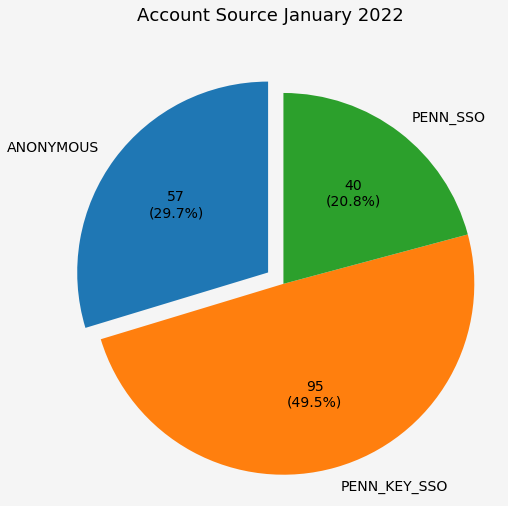

In [166]:
get_pie_chart(temp_account_source, 'Account Source January 2022', 'account_source_esc_jan2022_', 'ANONYMOUS')

### Escalation-Account Time Series

In [167]:
# Get relative proportions
esc_monthly_ts_data = instance_esc_monthly_ts_data.copy()
esc_monthly_ts_data['total'] = esc_monthly_ts_data[['mild','moderate','severe']].sum(axis=1).values
esc_monthly_ts_data[['mild_rel_prop','moderate_rel_prop','severe_rel_prop']] = esc_monthly_ts_data[['mild','moderate','severe']].div(esc_monthly_ts_data['total'], axis=0)

# Get rates based on different "denominators"
esc_monthly_ts_data = esc_monthly_ts_data.merge(acct_monthly_ts_data, how='inner', left_index=True, right_index=True)
esc_monthly_ts_data[['mild_acct_rate', 'moderate_acct_rate', 'severe_acct_rate','total_acct_rate']] = esc_monthly_ts_data[['mild','moderate','severe','total']].div(esc_monthly_ts_data['account_id'], axis=0)
esc_monthly_ts_data[['mild_acct_rate100', 'moderate_acct_rate100', 'severe_acct_rate100','total_acct_rate100']] = esc_monthly_ts_data[['mild_acct_rate', 'moderate_acct_rate', 'severe_acct_rate','total_acct_rate']]*100

# Save data
esc_monthly_ts_data.to_csv(CHART_PATH + 'esc_monthly_ts_data_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')
esc_monthly_ts_data.describe().to_csv(CHART_PATH + 'esc_monthly_ts_stats_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [168]:
# Get relative proportions
esc_weekly_ts_data = instance_esc_weekly_ts_data.copy()
esc_weekly_ts_data['total'] = esc_weekly_ts_data[['mild','moderate','severe']].sum(axis=1).values
esc_weekly_ts_data[['mild_rel_prop','moderate_rel_prop','severe_rel_prop']] = esc_weekly_ts_data[['mild','moderate','severe']].div(esc_weekly_ts_data['total'], axis=0)

# Get rates based on different "denominators"
esc_weekly_ts_data = esc_weekly_ts_data.merge(acct_weekly_ts_data, how='inner', left_index=True, right_index=True)
esc_weekly_ts_data[['mild_acct_rate', 'moderate_acct_rate', 'severe_acct_rate','total_acct_rate']] = esc_weekly_ts_data[['mild','moderate','severe','total']].div(esc_weekly_ts_data['account_id'], axis=0)
esc_weekly_ts_data[['mild_acct_rate100', 'moderate_acct_rate100', 'severe_acct_rate100','total_acct_rate100']] = esc_weekly_ts_data[['mild_acct_rate', 'moderate_acct_rate', 'severe_acct_rate','total_acct_rate']]*100

# Save data
esc_weekly_ts_data.to_csv(CHART_PATH + 'esc_weekly_ts_data_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')
esc_weekly_ts_data.describe().to_csv(CHART_PATH + 'esc_weekly_ts_stats_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [169]:
# Time from account creation to escalation
acct_esc_time = instance_data.merge(account[['account_id', 'created']], 
                                    how='inner', 
                                    left_on='account_id', 
                                    right_on='account_id')
acct_esc_time['acct_esc_tdelta'] = (acct_esc_time['complete_time'] - acct_esc_time['created'])
acct_esc_time_data = acct_esc_time['acct_esc_tdelta']
acct_esc_time_dist = pd.concat([acct_esc_time_data.value_counts(0,bins=100),
                                acct_esc_time_data.value_counts(1,bins=100)], 
                               axis=1).sort_index()

# Format dist data
new_idx = [str(abs(left))+'-'+str(right)+' days' for left,right in zip(acct_esc_time_dist.index.left.days,acct_esc_time_dist.index.right.days)]
acct_esc_time_dist.index = new_idx
acct_esc_time_dist.columns = ['acct_esc_time_count','acct_esc_time_pct']

In [170]:
print(len(esc_monthly_ts_data))
esc_monthly_ts_data.head(2)

27


mild  moderate  severe  total  mild_rel_prop  moderate_rel_prop  \
year month                                                                    
2020 4        53        63      14    130         0.4077             0.4846   
     5        51        51      14    116         0.4397             0.4397   

            severe_rel_prop  account_id  mild_acct_rate  moderate_acct_rate  \
year month                                                                    
2020 4               0.1077        3006          0.0176              0.0210   
     5               0.1207        1920          0.0266              0.0266   

            severe_acct_rate  total_acct_rate  mild_acct_rate100  \
year month                                                         
2020 4                0.0047           0.0432             1.7631   
     5                0.0073           0.0604             2.6562   

            moderate_acct_rate100  severe_acct_rate100  total_acct_rate100  
year month                                                                  
2020 4                     2.0958               0.4657              4.3247  
     5                     2.6562               0.7292              6.0417

In [171]:
print(len(esc_weekly_ts_data))
esc_weekly_ts_data.head(2)

115


mild  moderate  severe  total  mild_rel_prop  \
Year Month Week                                                 
2020 4     9     19.0      24.0    11.0   54.0         0.3519   
           16    22.0      19.0     3.0   44.0         0.5000   

                 moderate_rel_prop  severe_rel_prop  account_id  \
Year Month Week                                                   
2020 4     9                0.4444           0.2037        1456   
           16               0.4318           0.0682         948   

                 mild_acct_rate  moderate_acct_rate  severe_acct_rate  \
Year Month Week                                                         
2020 4     9             0.0130              0.0165            0.0076   
           16            0.0232              0.0200            0.0032   

                 total_acct_rate  mild_acct_rate100  moderate_acct_rate100  \
Year Month Week                                                              
2020 4     9              0.0371             1.3049                 1.6484   
           16             0.0464             2.3207                 2.0042   

                 severe_acct_rate100  total_acct_rate100  
Year Month Week                                           
2020 4     9                  0.7555              3.7088  
           16                 0.3165              4.6414

In [172]:
print(len(acct_esc_time))
acct_esc_time.head(2)

2465


instance_id  \
0  000df8c8-7a8b-4060-a06a-27f65d2d2fd9_0   
1  00242b81-b10b-4425-84cf-21aa4da6e18d_0   

                             account_id  num_instance_sessions  PHQ4_attempts  \
0  000df8c8-7a8b-4060-a06a-27f65d2d2fd9                      5              1   
1  00242b81-b10b-4425-84cf-21aa4da6e18d                      4              1   

   PHQ9_attempts  GAD7_attempts  PCPTSD_attempts  PHQ4_complete  \
0              2              1                1              1   
1              1              1                1              1   

   PHQ9_complete  GAD7_complete  PCPTSD_complete  PHQ4_score  PHQ9_score  \
0              1              1                1          10          12   
1              1              1                1           3           4   

   GAD7_score  PCPTSD_score PHQ4_severity PHQ9_severity GAD7_severity  \
0          16             2        severe      moderate        severe   
1           5             2          mild   no_symptoms          mild   

  PCPTSD_severity  crisis crisis_text  crisis_value  instance_complete  \
0     no_symptoms       0                         0                  1   
1     no_symptoms       0                         0                  1   

  escalation escalation_provider                       start_time  \
0   moderate     psychotherapist 2022-02-20 01:52:12.942990+00:00   
1       mild    resilience_coach 2021-01-04 16:35:12.603321+00:00   

                     complete_time                     last_updated  year  \
0 2022-02-20 01:58:59.671561+00:00 2022-02-20 01:58:59.671561+00:00  2022   
1 2021-01-04 16:41:38.151380+00:00 2021-01-04 16:41:38.151380+00:00  2021   

   month  week  day year_month year_month_week dayofyear  \
0      2     7   20 2022-02-01      2022-02-17  20220220   
1      1     1    4 2021-01-01      2020-12-31  20210104   

                           created        acct_esc_tdelta  
0 2022-02-20 01:51:45.690950+00:00 0 days 00:07:13.980611  
1 2021-01-04 16:31:04.786432+00:00 0 days 00:10:33.364948

In [173]:
print(len(acct_esc_time_dist),'\n')
print(acct_esc_time_dist.sum(),'\n')
print(acct_esc_time_dist.iloc[0:2].sum(),'\n')
print(acct_esc_time_dist.iloc[0:4].sum())
acct_esc_time_dist.head(2)

100 

acct_esc_time_count    2465.0
acct_esc_time_pct         1.0
dtype: float64 

acct_esc_time_count    1932.0000
acct_esc_time_pct         0.7838
dtype: float64 

acct_esc_time_count    2006.0000
acct_esc_time_pct         0.8138
dtype: float64


acct_esc_time_count  acct_esc_time_pct
1-7 days                  1867             0.7574
7-15 days                   65             0.0264

#### Monthly

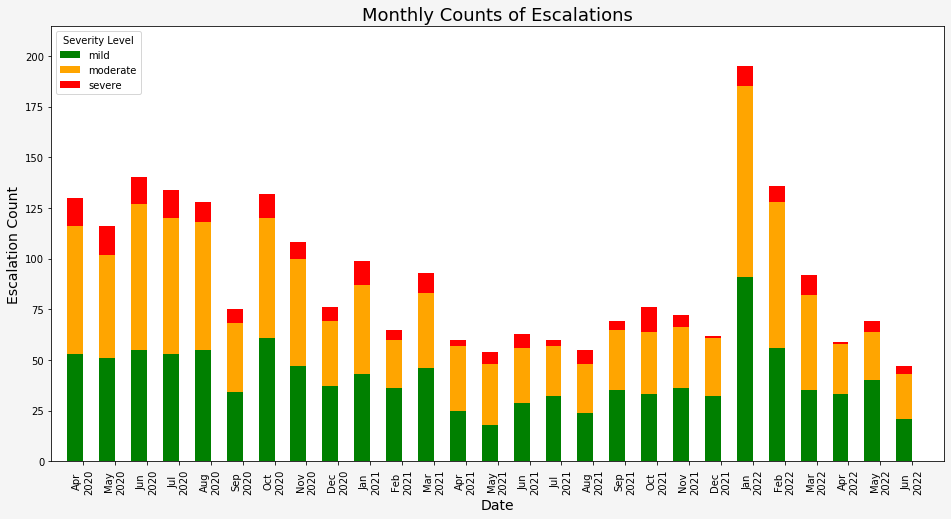

In [174]:
text_pad = 8
bar_width = 0.5
xlabels = get_ts_xlabels(index=esc_monthly_ts_data.index, time='monthly')

fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
plt.grid(True, linestyle='--')

use_cols = ['mild','moderate','severe']
plt_main = esc_monthly_ts_data[use_cols].plot(ax=ax, kind='bar', width=bar_width, stacked=True, color=['green','orange','red'], position=1)
ax.set_title('Monthly Counts of Escalations', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_xticks(np.arange(len(esc_monthly_ts_data)))
ax.set_xticklabels(xlabels, rotation=90)
ax.set_ylabel('Escalation Count', fontsize=14)
ax.set_xlim(-1,len(esc_monthly_ts_data))
ax.set_ylim(0,esc_monthly_ts_data[use_cols].sum(axis=1).max()*1.1)
ax.legend(esc_monthly_ts_data[use_cols].columns, title='Severity Level', loc='upper left')

save_figure(fig,FIGURE_PATH,'esc_dist_monthly_')

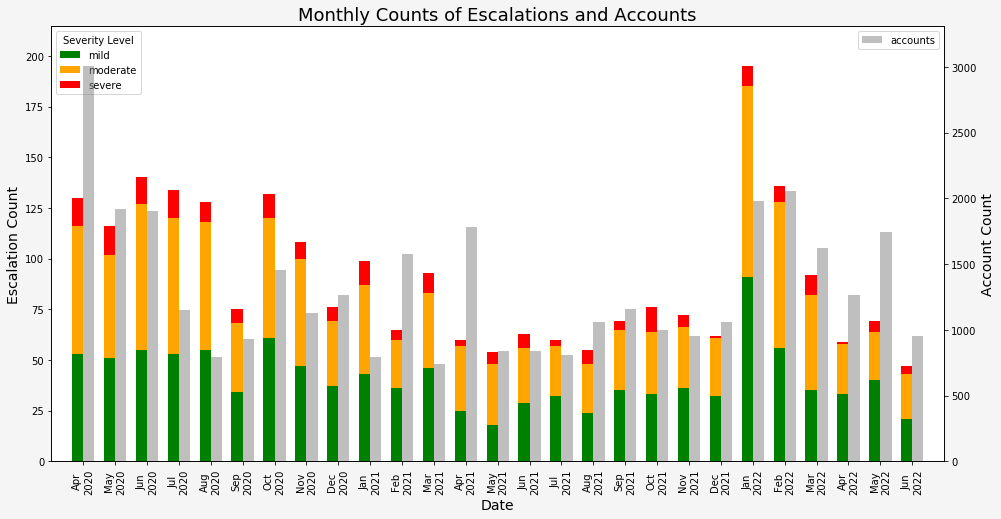

In [175]:
text_pad = 8
bar_width = 0.35
xlabels = get_ts_xlabels(index=esc_monthly_ts_data.index, time='monthly')

fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
plt.grid(True, linestyle='--')

ax_temp = ax.twinx()
plt_twin = esc_monthly_ts_data['account_id'].plot(ax=ax_temp, kind='bar', width=bar_width, color='grey', alpha=0.5, position=0)
ax_temp.set_ylabel('Account Count', fontsize=14)
ax_temp.set_ylim(0,esc_monthly_ts_data['account_id'].max()*1.1)
ax_temp.legend(['accounts'], loc='upper right')

use_cols = ['mild','moderate','severe']
plt_main = esc_monthly_ts_data[use_cols].plot(ax=ax, kind='bar', width=bar_width, stacked=True, color=['green','orange','red'], position=1)
ax.set_title('Monthly Counts of Escalations and Accounts', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_xticks(np.arange(len(esc_monthly_ts_data)))
ax.set_xticklabels(xlabels, rotation=90)
ax.set_ylabel('Escalation Count', fontsize=14)
ax.set_xlim(-1,len(esc_monthly_ts_data))
ax.set_ylim(0,esc_monthly_ts_data[use_cols].sum(axis=1).max()*1.1)
ax.legend(esc_monthly_ts_data[use_cols].columns, title='Severity Level', loc='upper left')

save_figure(fig,FIGURE_PATH,'esc_dist_acct_monthly_')

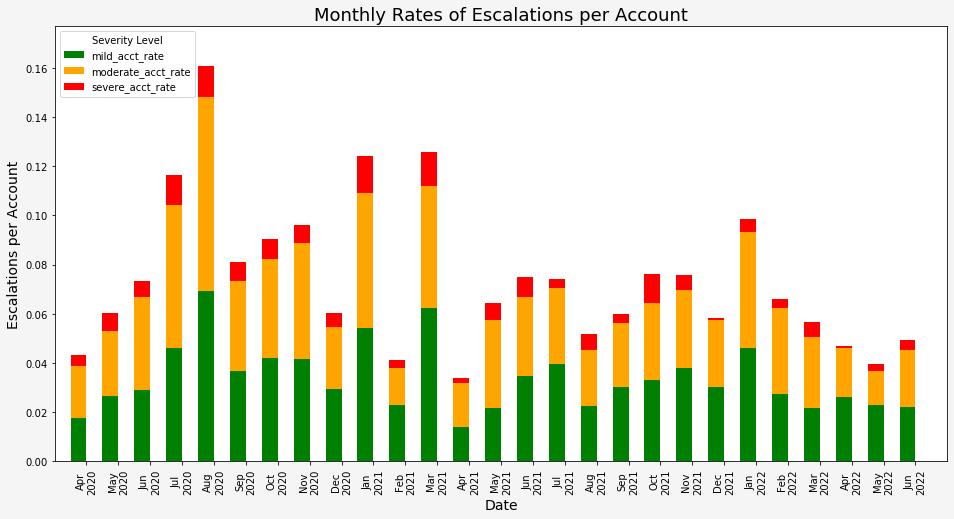

In [176]:
text_pad = 8
bar_width = 0.5
xlabels = get_ts_xlabels(index=esc_monthly_ts_data.index, time='monthly')

fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
plt.grid(True, linestyle='--')

use_cols = ['mild_acct_rate','moderate_acct_rate','severe_acct_rate']
plt_main = esc_monthly_ts_data[use_cols].plot(ax=ax, kind='bar', width=bar_width, stacked=True, color=['green','orange','red'], position=1)
ax.set_title('Monthly Rates of Escalations per Account', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_xticks(np.arange(len(esc_monthly_ts_data)))
ax.set_xticklabels(xlabels, rotation=90)
ax.set_ylabel('Escalations per Account', fontsize=14)
ax.set_xlim(-1,len(esc_monthly_ts_data))
ax.set_ylim(0,esc_monthly_ts_data[use_cols].sum(axis=1).max()*1.1)
ax.legend(esc_monthly_ts_data[use_cols].columns, title='Severity Level', loc='upper left')

save_figure(fig,FIGURE_PATH,'esc_acct_rate_monthly_')

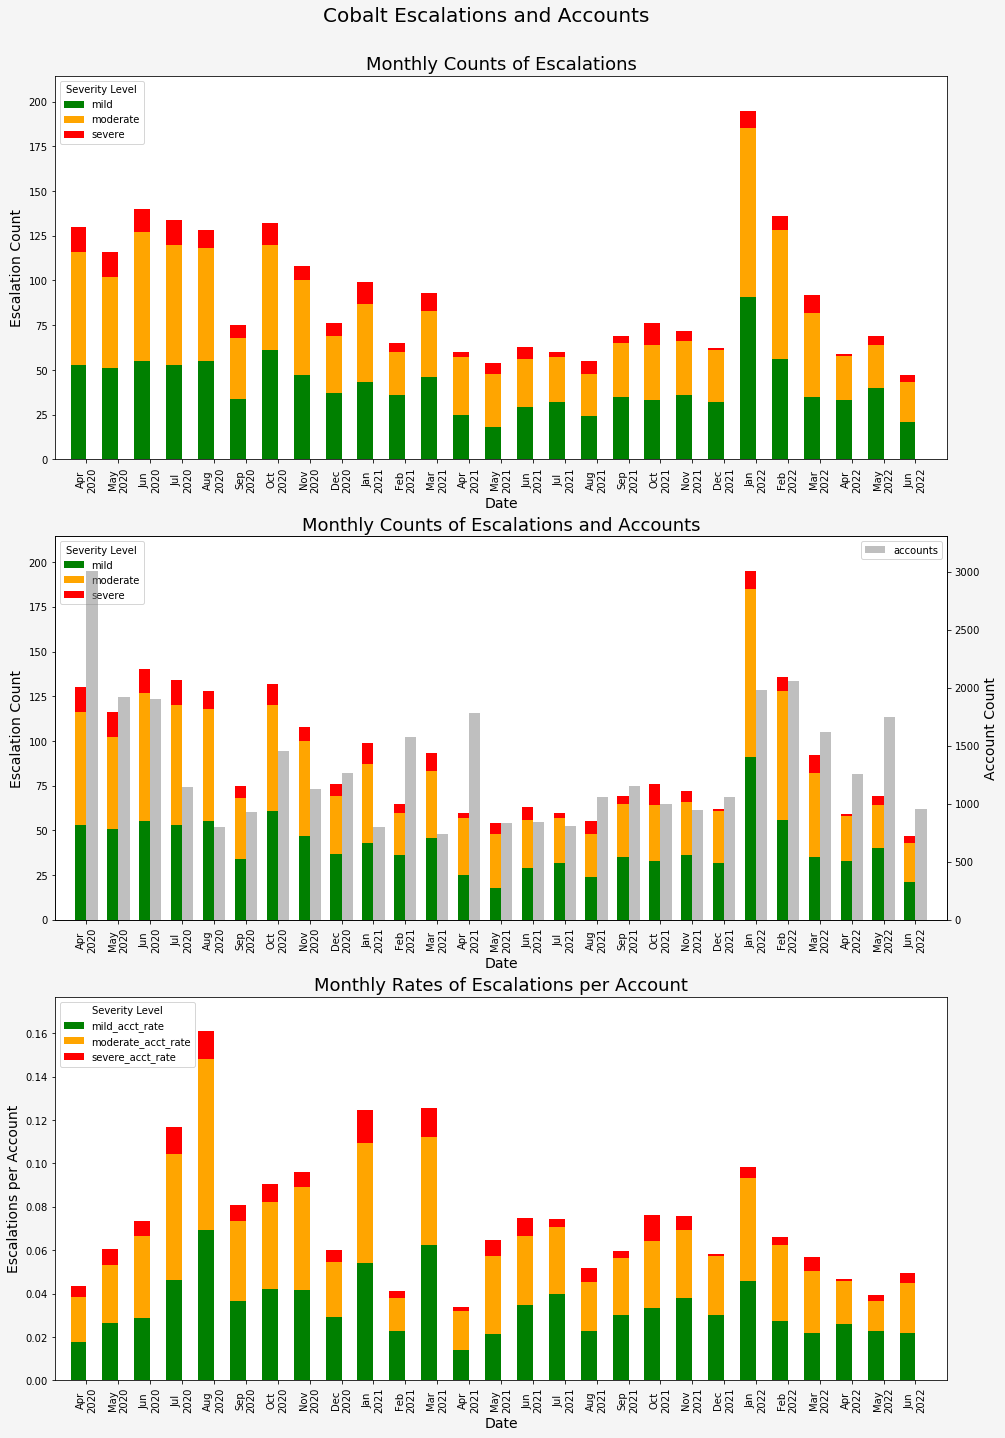

In [177]:
# Define fig
suptitle = 'Cobalt Escalations and Accounts'
fig, axes = plt.subplots(3,1,figsize=(16,24), facecolor='whitesmoke')
fig.suptitle(suptitle, fontsize=20, y=0.92)
plt.grid(True, linestyle='--')

# Plot 1: Escalation counts
bar_width = 0.5
xlabels = get_ts_xlabels(index=esc_monthly_ts_data.index, time='monthly')

use_cols = ['mild','moderate','severe']
plt1 = esc_monthly_ts_data[use_cols].plot(ax=axes[0], kind='bar', width=bar_width, stacked=True, color=['green','orange','red'], position=1)
axes[0].set_title('Monthly Counts of Escalations', fontsize=18)
axes[0].set_xlabel('Date', fontsize=14)
axes[0].set_xticks(np.arange(len(esc_monthly_ts_data)))
axes[0].set_xticklabels(xlabels, rotation=90)
axes[0].set_ylabel('Escalation Count', fontsize=14)
axes[0].set_xlim(-1,len(esc_monthly_ts_data))
axes[0].set_ylim(0,esc_monthly_ts_data[use_cols].sum(axis=1).max()*1.1)
axes[0].legend(esc_monthly_ts_data[use_cols].columns, title='Severity Level', loc='upper left')

# Plot 2: Escalation and account counts
bar_width = 0.35
xlabels = get_ts_xlabels(index=esc_monthly_ts_data.index, time='monthly')

ax2_twin = axes[1].twinx()
plt2_twin = esc_monthly_ts_data['account_id'].plot(ax=ax2_twin, kind='bar', width=bar_width, color='grey', alpha=0.5, position=0)
ax2_twin.set_ylabel('Account Count', fontsize=14)
ax2_twin.set_ylim(0,esc_monthly_ts_data['account_id'].max()*1.1)
ax2_twin.legend(['accounts'], loc='upper right')

use_cols = ['mild','moderate','severe']
plt2 = esc_monthly_ts_data[use_cols].plot(ax=axes[1], kind='bar', width=bar_width, stacked=True, color=['green','orange','red'], position=1)
axes[1].set_title('Monthly Counts of Escalations and Accounts', fontsize=18)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_xticks(np.arange(len(esc_monthly_ts_data)))
axes[1].set_xticklabels(xlabels, rotation=90)
axes[1].set_ylabel('Escalation Count', fontsize=14)
axes[1].set_xlim(-1,len(esc_monthly_ts_data))
axes[1].set_ylim(0,esc_monthly_ts_data[use_cols].sum(axis=1).max()*1.1)
axes[1].legend(esc_monthly_ts_data[use_cols].columns, title='Severity Level', loc='upper left')

# Plot 3: Escalation per account rates
bar_width = 0.5
xlabels = get_ts_xlabels(index=esc_monthly_ts_data.index, time='monthly')

use_cols = ['mild_acct_rate','moderate_acct_rate','severe_acct_rate']
plt_main = esc_monthly_ts_data[use_cols].plot(ax=axes[2], kind='bar', width=bar_width, stacked=True, color=['green','orange','red'], position=1)
axes[2].set_title('Monthly Rates of Escalations per Account', fontsize=18)
axes[2].set_xlabel('Date', fontsize=14)
axes[2].set_xticks(np.arange(len(esc_monthly_ts_data)))
axes[2].set_xticklabels(xlabels, rotation=90)
axes[2].set_ylabel('Escalations per Account', fontsize=14)
axes[2].set_xlim(-1,len(esc_monthly_ts_data))
axes[2].set_ylim(0,esc_monthly_ts_data[use_cols].sum(axis=1).max()*1.1)
axes[2].legend(esc_monthly_ts_data[use_cols].columns, title='Severity Level', loc='upper left')

save_figure(fig,FIGURE_PATH,'esc_acct_comb_monthly_')

##### By Account Source

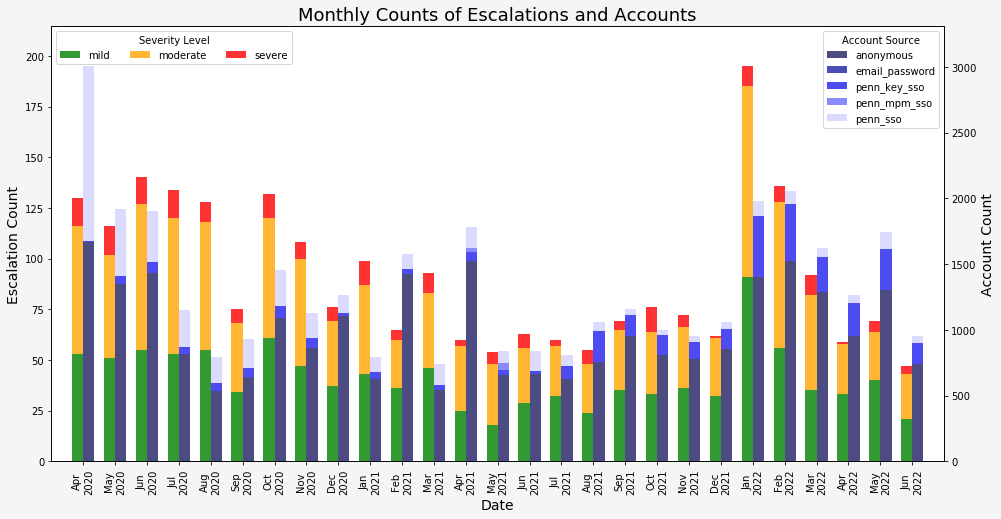

In [178]:
text_pad = 8
bar_width = 0.35
xlabels = get_ts_xlabels(index=esc_monthly_ts_data.index, time='monthly')

fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
plt.grid(True, linestyle='--')

ax_temp = ax.twinx()
colors = plt.cm.seismic(np.linspace(0, 0.45, 5))
plt_twin = acct_src_ts_data.plot(ax=ax_temp, kind='bar', width=bar_width, stacked=True, color=colors, alpha=0.7, position=0)
ax_temp.set_ylabel('Account Count', fontsize=14)
ax_temp.set_ylim(0,esc_monthly_ts_data['account_id'].max()*1.1)
ax_temp.legend([item.lower() for item in acct_src_ts_data.columns], title="Account Source", loc='upper right')

use_cols = ['mild','moderate','severe']
plt_main = esc_monthly_ts_data[use_cols].plot(ax=ax, kind='bar', width=bar_width, stacked=True, color=['green','orange','red'], alpha=0.8, position=1)
ax.set_title('Monthly Counts of Escalations and Accounts', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_xticks(np.arange(len(esc_monthly_ts_data)))
ax.set_xticklabels(xlabels, rotation=90)
ax.set_ylabel('Escalation Count', fontsize=14)
ax.set_xlim(-1,len(esc_monthly_ts_data))
ax.set_ylim(0,esc_monthly_ts_data[use_cols].sum(axis=1).max()*1.1)
ax.legend(esc_monthly_ts_data[use_cols].columns, title='Severity Level', ncol=3, loc='upper left')

save_figure(fig,FIGURE_PATH,'escDist_acctSrc_monthly_')

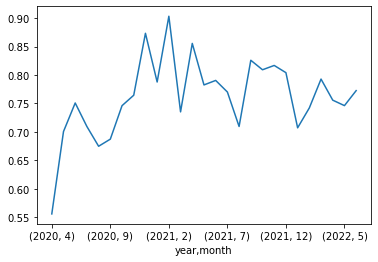

In [179]:
(acct_src_ts_data['ANONYMOUS']/acct_src_ts_data.sum(axis=1)).plot()

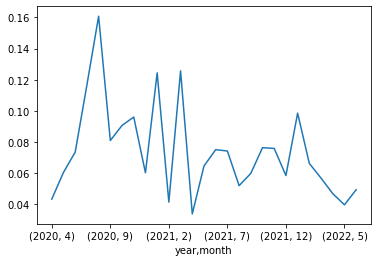

In [180]:
(esc_monthly_ts_data['total']/acct_src_ts_data.sum(axis=1)).plot()

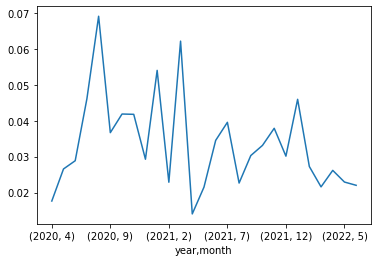

In [181]:
(esc_monthly_ts_data['mild']/acct_src_ts_data.sum(axis=1)).plot()

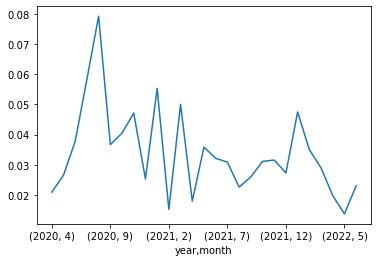

In [182]:
(esc_monthly_ts_data['moderate']/acct_src_ts_data.sum(axis=1)).plot()

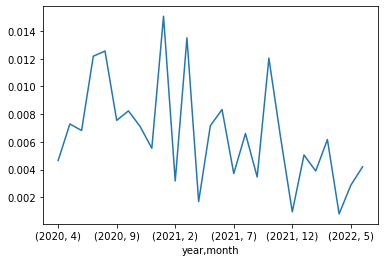

In [183]:
(esc_monthly_ts_data['severe']/acct_src_ts_data.sum(axis=1)).plot()

#### Weekly

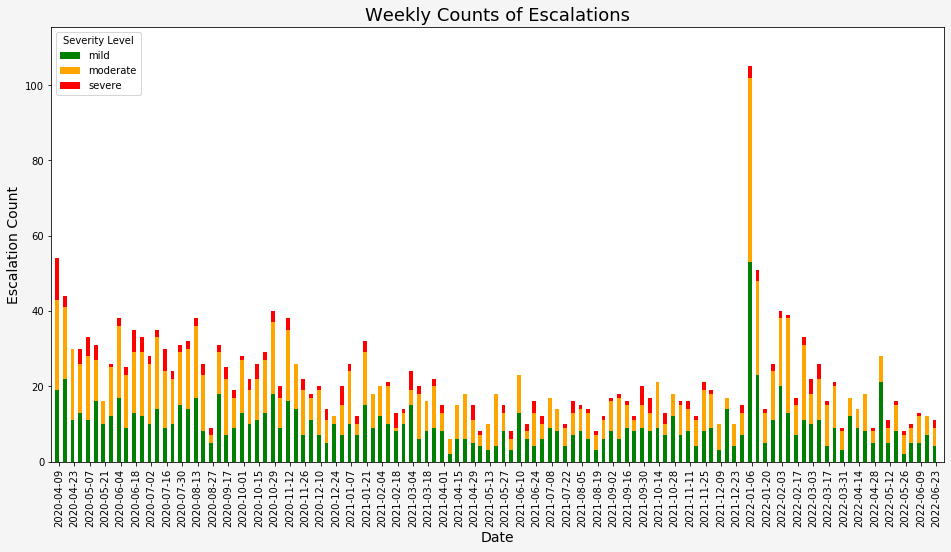

In [184]:
text_pad = 8
bar_width = 0.5
xlabels = get_ts_xlabels(index=esc_weekly_ts_data.index, time='weekly')

fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
plt.grid(True, linestyle='--')

use_cols = ['mild','moderate','severe']
plt_main = esc_weekly_ts_data[use_cols].plot(ax=ax, kind='bar', width=bar_width, stacked=True, color=['green','orange','red'], position=1)
ax.set_title('Weekly Counts of Escalations', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_xticks(np.arange(0,len(esc_weekly_ts_data),2))
ax.set_xticklabels(xlabels[::2], rotation=90)
ax.set_ylabel('Escalation Count', fontsize=14)
ax.set_xlim(-1,len(esc_weekly_ts_data))
ax.set_ylim(0,esc_weekly_ts_data[use_cols].sum(axis=1).max()*1.1)
ax.legend(esc_weekly_ts_data[use_cols].columns, title='Severity Level', loc='upper left')

save_figure(fig,FIGURE_PATH,'esc_dist_weekly_')

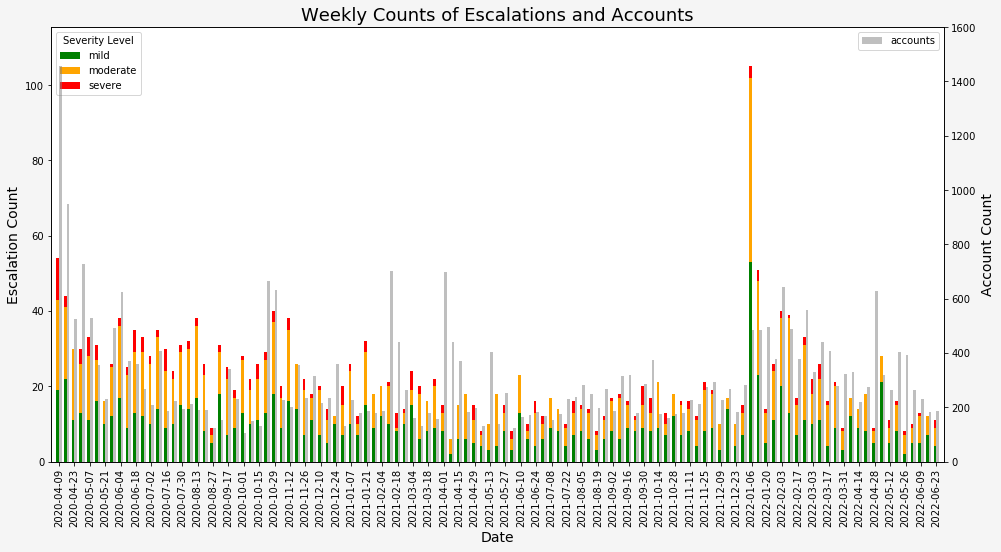

In [185]:
text_pad = 8
bar_width = 0.35
xlabels = get_ts_xlabels(index=esc_weekly_ts_data.index, time='weekly')

fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
plt.grid(True, linestyle='--')

ax_temp = ax.twinx()
plt_twin = esc_weekly_ts_data['account_id'].plot(ax=ax_temp, kind='bar', width=bar_width, color='grey', alpha=0.5, position=0)
ax_temp.set_ylabel('Account Count', fontsize=14)
ax_temp.set_ylim(0,esc_weekly_ts_data['account_id'].max()*1.1)
ax_temp.legend(['accounts'], loc='upper right')

use_cols = ['mild','moderate','severe']
plt_main = esc_weekly_ts_data[use_cols].plot(ax=ax, kind='bar', width=bar_width, stacked=True, color=['green','orange','red'], position=1)
ax.set_title('Weekly Counts of Escalations and Accounts', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_xticks(np.arange(0,len(esc_weekly_ts_data),2))
ax.set_xticklabels(xlabels[::2], rotation=90)
ax.set_ylabel('Escalation Count', fontsize=14)
ax.set_xlim(-1,len(esc_weekly_ts_data))
ax.set_ylim(0,esc_weekly_ts_data[use_cols].sum(axis=1).max()*1.1)
ax.legend(esc_weekly_ts_data[use_cols].columns, title='Severity Level', loc='upper left')

save_figure(fig,FIGURE_PATH,'esc_dist_acct_weekly_')

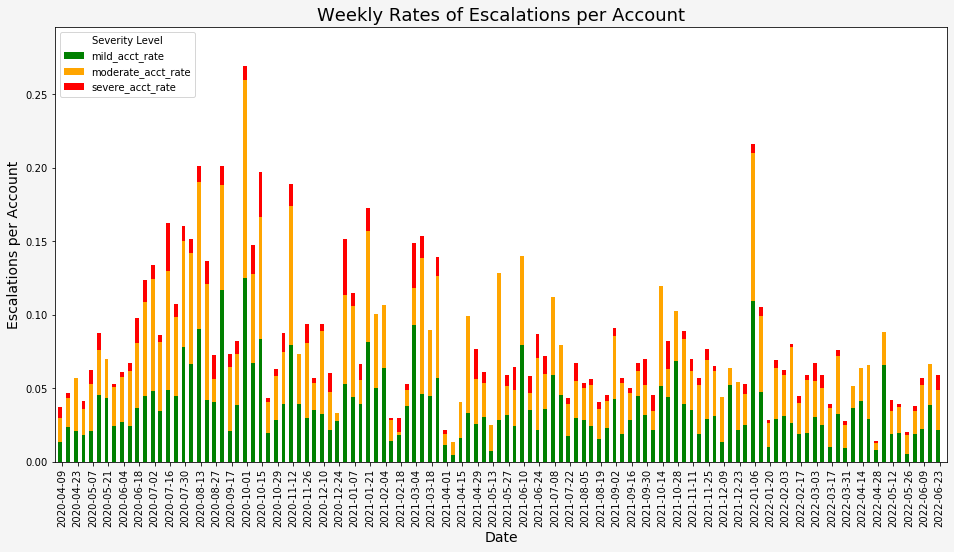

In [186]:
text_pad = 8
bar_width = 0.5
xlabels = get_ts_xlabels(index=esc_weekly_ts_data.index, time='weekly')

fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
plt.grid(True, linestyle='--')

use_cols = ['mild_acct_rate','moderate_acct_rate','severe_acct_rate']
plt_main = esc_weekly_ts_data[use_cols].plot(ax=ax, kind='bar', width=bar_width, stacked=True, color=['green','orange','red'], position=1)
ax.set_title('Weekly Rates of Escalations per Account', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_xticks(np.arange(0,len(esc_weekly_ts_data),2))
ax.set_xticklabels(xlabels[::2], rotation=90)
ax.set_ylabel('Escalations per Account', fontsize=14)
ax.set_xlim(-1,len(esc_weekly_ts_data))
ax.set_ylim(0,esc_weekly_ts_data[use_cols].sum(axis=1).max()*1.1)
ax.legend(esc_weekly_ts_data[use_cols].columns, title='Severity Level', loc='upper left')

save_figure(fig,FIGURE_PATH,'esc_acct_rate_weekly_')

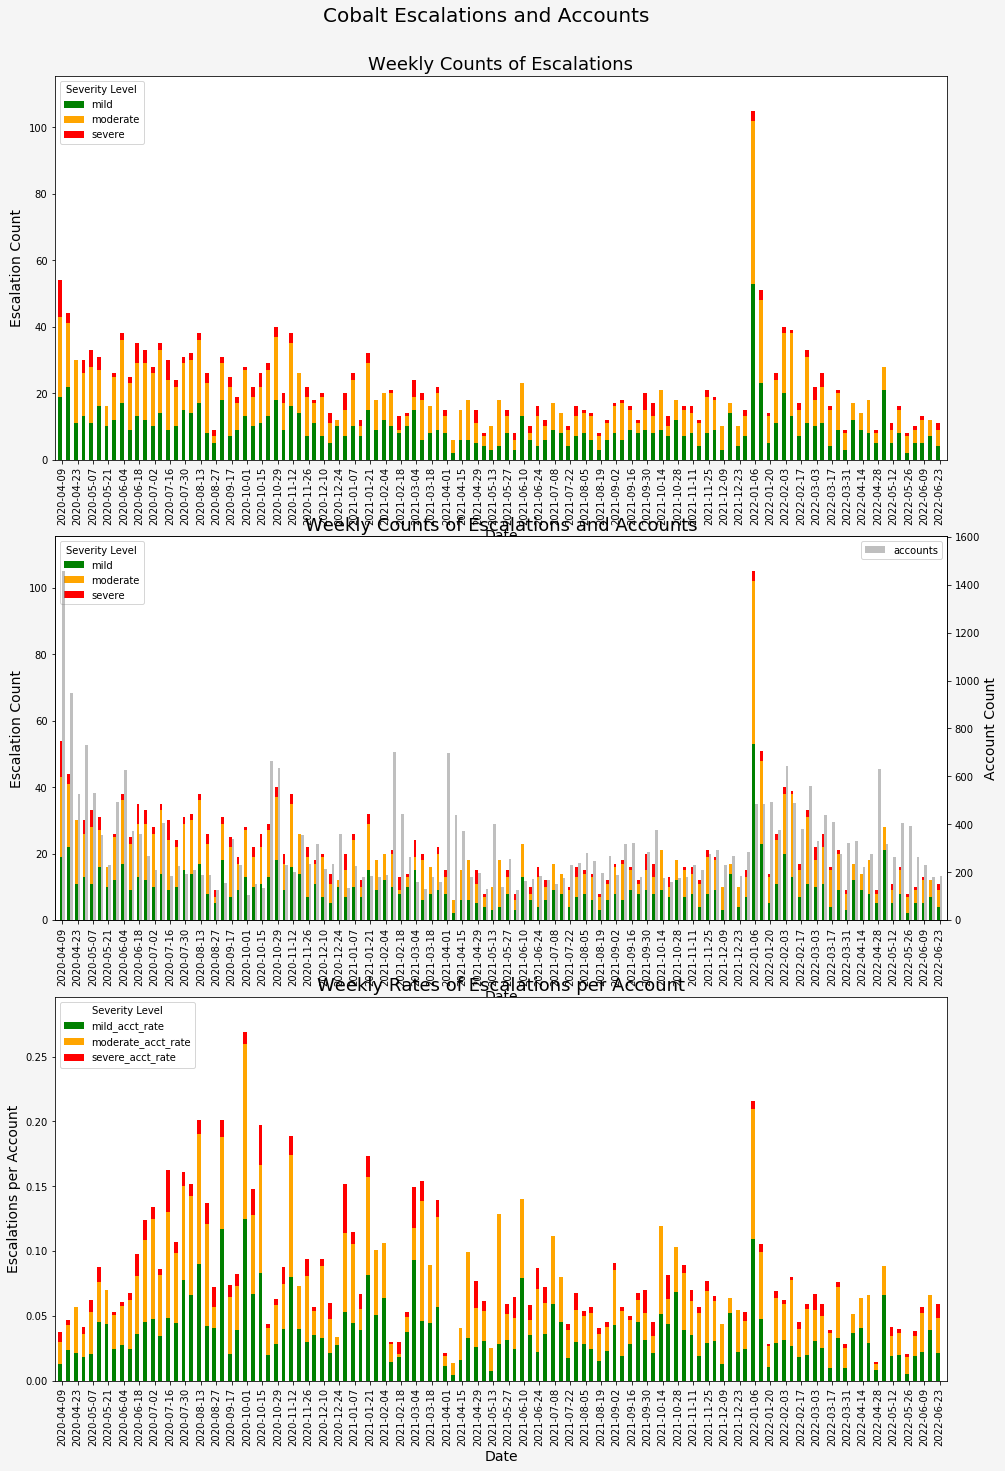

In [187]:
# Define fig
suptitle = 'Cobalt Escalations and Accounts'
fig, axes = plt.subplots(3,1,figsize=(16,24), facecolor='whitesmoke')
fig.suptitle(suptitle, fontsize=20, y=0.92)
plt.grid(True, linestyle='--')

# Plot 1: Escalation counts
bar_width = 0.5
xlabels = get_ts_xlabels(index=esc_weekly_ts_data.index, time='weekly')

use_cols = ['mild','moderate','severe']
plt1 = esc_weekly_ts_data[use_cols].plot(ax=axes[0], kind='bar', width=bar_width, stacked=True, color=['green','orange','red'], position=1)
axes[0].set_title('Weekly Counts of Escalations', fontsize=18)
axes[0].set_xlabel('Date', fontsize=14)
axes[0].set_xticks(np.arange(0,len(esc_weekly_ts_data),2))
axes[0].set_xticklabels(xlabels[::2], rotation=90)
axes[0].set_ylabel('Escalation Count', fontsize=14)
axes[0].set_xlim(-1,len(esc_weekly_ts_data))
axes[0].set_ylim(0,esc_weekly_ts_data[use_cols].sum(axis=1).max()*1.1)
axes[0].legend(esc_weekly_ts_data[use_cols].columns, title='Severity Level', loc='upper left')

# Plot 2: Escalation and account counts
bar_width = 0.35
xlabels = get_ts_xlabels(index=esc_weekly_ts_data.index, time='weekly')

ax2_twin = axes[1].twinx()
plt2_twin = esc_weekly_ts_data['account_id'].plot(ax=ax2_twin, kind='bar', width=bar_width, color='grey', alpha=0.5, position=0)
ax2_twin.set_ylabel('Account Count', fontsize=14)
ax2_twin.set_ylim(0,esc_weekly_ts_data['account_id'].max()*1.1)
ax2_twin.legend(['accounts'], loc='upper right')

use_cols = ['mild','moderate','severe']
plt2 = esc_weekly_ts_data[use_cols].plot(ax=axes[1], kind='bar', width=bar_width, stacked=True, color=['green','orange','red'], position=1)
axes[1].set_title('Weekly Counts of Escalations and Accounts', fontsize=18)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_xticks(np.arange(0,len(esc_weekly_ts_data),2))
axes[1].set_xticklabels(xlabels[::2], rotation=90)
axes[1].set_ylabel('Escalation Count', fontsize=14)
axes[1].set_xlim(-1,len(esc_weekly_ts_data))
axes[1].set_ylim(0,esc_weekly_ts_data[use_cols].sum(axis=1).max()*1.1)
axes[1].legend(esc_weekly_ts_data[use_cols].columns, title='Severity Level', loc='upper left')

# Plot 3: Escalation per account rates
bar_width = 0.5
xlabels = get_ts_xlabels(index=esc_weekly_ts_data.index, time='weekly')

use_cols = ['mild_acct_rate','moderate_acct_rate','severe_acct_rate']
plt_main = esc_weekly_ts_data[use_cols].plot(ax=axes[2], kind='bar', width=bar_width, stacked=True, color=['green','orange','red'], position=1)
axes[2].set_title('Weekly Rates of Escalations per Account', fontsize=18)
axes[2].set_xlabel('Date', fontsize=14)
axes[2].set_xticks(np.arange(0,len(esc_weekly_ts_data),2))
axes[2].set_xticklabels(xlabels[::2], rotation=90)
axes[2].set_ylabel('Escalations per Account', fontsize=14)
axes[2].set_xlim(-1,len(esc_weekly_ts_data))
axes[2].set_ylim(0,esc_weekly_ts_data[use_cols].sum(axis=1).max()*1.1)
axes[2].legend(esc_weekly_ts_data[use_cols].columns, title='Severity Level', loc='upper left')

save_figure(fig,FIGURE_PATH,'esc_acct_comb_weekly_')

### Escalation Appointment Distribution

#### All Appointments

##### All Time

In [188]:
aptRole_dist = pd.concat([appointment['support_role_id'].value_counts(0), 
                                 appointment['support_role_id'].value_counts(1)], axis=1)
aptRole_dist.columns = ['appt_count', 'appt_pct']
aptRole_dist = aptRole_dist.sort_index()
aptRole_dist

appt_count  appt_pct
CARE_MANAGER        1107    0.3002
CHAPLAIN              31    0.0084
CLINICIAN           1293    0.3507
COACH                776    0.2105
OTHER                 22    0.0060
PEER                  11    0.0030
PSYCHIATRIST         447    0.1212

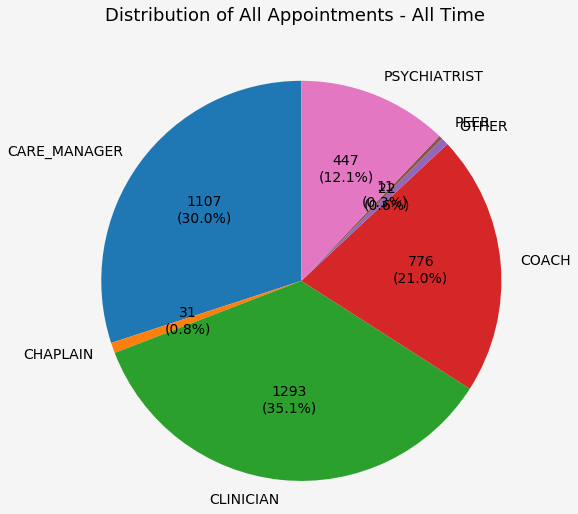

In [189]:
get_pie_chart(aptRole_dist, 'Distribution of All Appointments - All Time', 
              'aptRole_dist_', '')

##### Last 90 Days

In [190]:
aptRole_dist_past90 = pd.concat([appointment_past_90day['support_role_id'].value_counts(0), 
                                 appointment_past_90day['support_role_id'].value_counts(1)], axis=1)
aptRole_dist_past90.columns = ['appt_count', 'appt_pct']
aptRole_dist_past90 = aptRole_dist_past90.sort_index()
aptRole_dist_past90

appt_count  appt_pct
CARE_MANAGER         168    0.5545
CHAPLAIN               2    0.0066
CLINICIAN             47    0.1551
COACH                 83    0.2739
OTHER                  1    0.0033
PSYCHIATRIST           2    0.0066

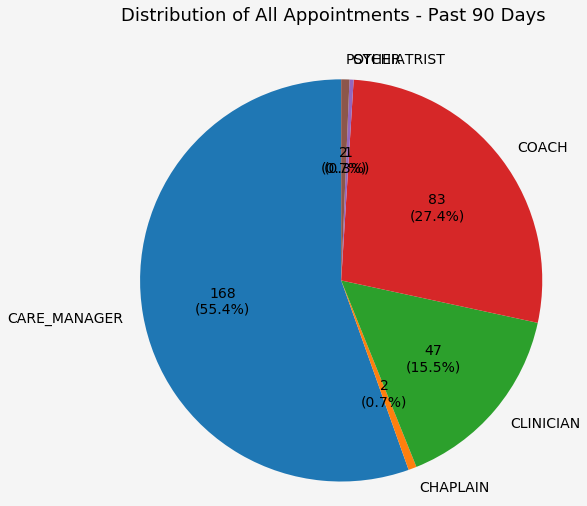

In [191]:
get_pie_chart(aptRole_dist_past90, 'Distribution of All Appointments - Past 90 Days', 
              'aptRole_dist_past90_', '')

#### Appointments With Escalation

In [192]:
# Appointments by escalation bracket
# Note: 1-2 patients have two escalations (somehow) and one apt that is being double counted
# need escalation datetimes to connect appointments to the appropriate escalation event
# this will be common once repeat assessment sequences (instances leanding to escalations) are implemented
instance_all = instance_data.copy()
account_id_all = instance_all['account_id'].unique()
appointment_all = appointment[appointment['account_id'].isin(account_id_all)]

instance_mild = instance_data[instance_data['escalation']=='mild']
account_id_mild = instance_mild['account_id'].unique()
appointment_mild = appointment[appointment['account_id'].isin(account_id_mild)]

instance_moderate = instance_data[instance_data['escalation']=='moderate']
account_id_moderate = instance_moderate['account_id'].unique()
appointment_moderate = appointment[appointment['account_id'].isin(account_id_moderate)]

instance_severe = instance_data[instance_data['escalation']=='severe']
account_id_severe = instance_severe['account_id'].unique()
appointment_severe = appointment[appointment['account_id'].isin(account_id_severe)]

##### All Time

In [193]:
aptRole_dist_escAll = pd.concat([appointment_all['support_role_id'].value_counts(0), 
                                 appointment_all['support_role_id'].value_counts(1)], axis=1)
aptRole_dist_escAll.columns = ['appt_count', 'appt_pct']
aptRole_dist_escAll = aptRole_dist_escAll.sort_index()
aptRole_dist_escAll

appt_count  appt_pct
CARE_MANAGER         329    0.1547
CHAPLAIN              14    0.0066
CLINICIAN           1004    0.4720
COACH                401    0.1885
OTHER                 10    0.0047
PEER                   6    0.0028
PSYCHIATRIST         363    0.1707

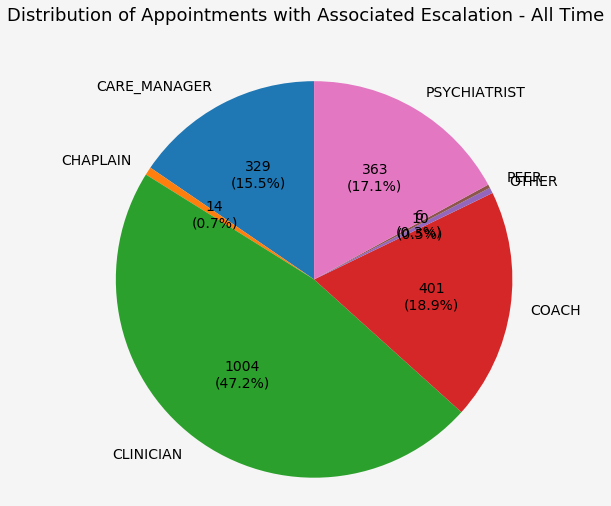

In [194]:
get_pie_chart(aptRole_dist_escAll, 'Distribution of Appointments with Associated Escalation - All Time', 
              'aptRole_dist_escAll_', '')

##### Last 90 Days

In [195]:
appointment_all_past90 = appointment_past_90day[appointment_past_90day['account_id'].isin(account_id_all)]

aptRole_dist_escAll_past90 = pd.concat([appointment_all_past90['support_role_id'].value_counts(0), 
                                 appointment_all_past90['support_role_id'].value_counts(1)], axis=1)
aptRole_dist_escAll_past90.columns = ['appt_count', 'appt_pct']
aptRole_dist_escAll_past90 = aptRole_dist_escAll_past90.sort_index()
aptRole_dist_escAll_past90

appt_count  appt_pct
CARE_MANAGER          64    0.5203
CHAPLAIN               1    0.0081
CLINICIAN             23    0.1870
COACH                 33    0.2683
PSYCHIATRIST           2    0.0163

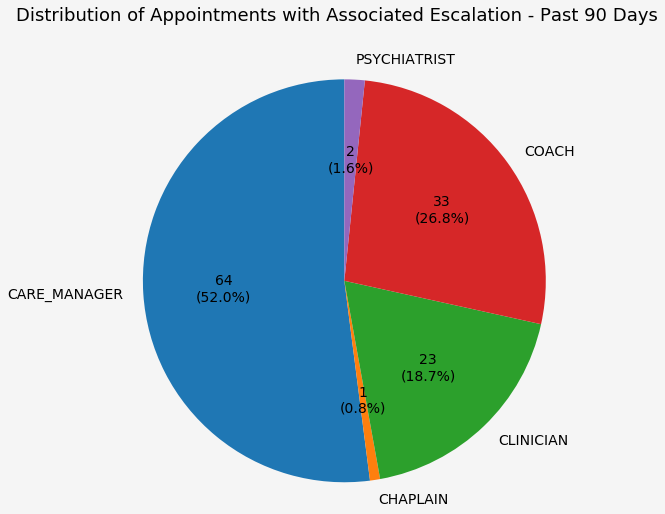

In [196]:
get_pie_chart(aptRole_dist_escAll_past90, 'Distribution of Appointments with Associated Escalation - Past 90 Days', 
              'aptRole_dist_escAll_past90_', '')

#### Summary

In [197]:
aptRole_dist_source = pd.concat({'All Appts':aptRole_dist, 
                              'All Appts - Past 90 Days':aptRole_dist_past90, 
                              'Appts with Escalation':aptRole_dist_escAll, 
                              'Appts with Escalation - Past 90 Days':aptRole_dist_escAll_past90}, names=['Appt Data', 'Provider Role'])
aptRole_dist_source

appt_count  appt_pct
Appt Data                            Provider Role                      
All Appts                            CARE_MANAGER         1107    0.3002
                                     CHAPLAIN               31    0.0084
                                     CLINICIAN            1293    0.3507
                                     COACH                 776    0.2105
                                     OTHER                  22    0.0060
                                     PEER                   11    0.0030
                                     PSYCHIATRIST          447    0.1212
All Appts - Past 90 Days             CARE_MANAGER          168    0.5545
                                     CHAPLAIN                2    0.0066
                                     CLINICIAN              47    0.1551
                                     COACH                  83    0.2739
                                     OTHER                   1    0.0033
                                     PSYCHIATRIST            2    0.0066
Appts with Escalation                CARE_MANAGER          329    0.1547
                                     CHAPLAIN               14    0.0066
                                     CLINICIAN            1004    0.4720
                                     COACH                 401    0.1885
                                     OTHER                  10    0.0047
                                     PEER                    6    0.0028
                                     PSYCHIATRIST          363    0.1707
Appts with Escalation - Past 90 Days CARE_MANAGER           64    0.5203
                                     CHAPLAIN                1    0.0081
                                     CLINICIAN              23    0.1870
                                     COACH                  33    0.2683
                                     PSYCHIATRIST            2    0.0163

In [198]:
aptRole_dist_source.groupby(level=0).sum()

appt_count  appt_pct
Appt Data                                                 
All Appts                                   3687       1.0
All Appts - Past 90 Days                     303       1.0
Appts with Escalation                       2127       1.0
Appts with Escalation - Past 90 Days         123       1.0

In [199]:
aptRole_dist_source.to_csv(CHART_PATH + 'aptRole_dist_source_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

### Escalation Appointment Distribution by Severity

#### Appointments With Mild Escalation

In [200]:
aptRole_dist_escMild = pd.concat([appointment_mild['support_role_id'].value_counts(0), 
                                  appointment_mild['support_role_id'].value_counts(1)], axis=1)
aptRole_dist_escMild.columns = ['appt_count', 'appt_pct']
aptRole_dist_escMild = aptRole_dist_escMild.sort_index()
aptRole_dist_escMild

appt_count  appt_pct
CARE_MANAGER         138    0.1941
CHAPLAIN               8    0.0113
CLINICIAN            149    0.2096
COACH                338    0.4754
OTHER                  8    0.0113
PSYCHIATRIST          70    0.0985

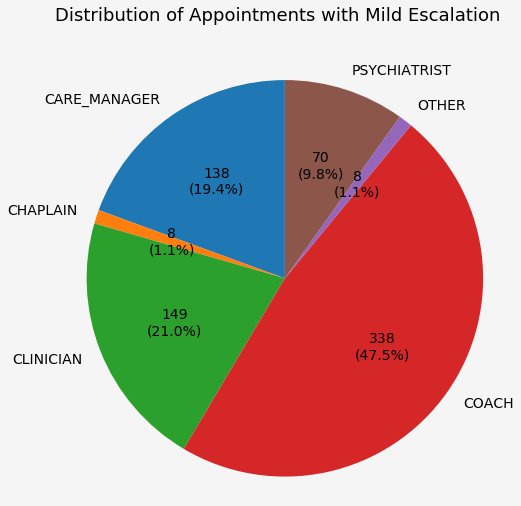

In [201]:
get_pie_chart(aptRole_dist_escMild, 'Distribution of Appointments with Mild Escalation', 
              'aptRole_dist_escMild_', '')

#### Appointments With Moderate Escalation

In [202]:
aptRole_dist_escModerate = pd.concat([appointment_moderate['support_role_id'].value_counts(0), 
                                  appointment_moderate['support_role_id'].value_counts(1)], axis=1)
aptRole_dist_escModerate.columns = ['appt_count', 'appt_pct']
aptRole_dist_escModerate = aptRole_dist_escModerate.sort_index()
aptRole_dist_escModerate

appt_count  appt_pct
CARE_MANAGER         182    0.1512
CHAPLAIN               5    0.0042
CLINICIAN            812    0.6744
COACH                 51    0.0424
OTHER                  2    0.0017
PEER                   4    0.0033
PSYCHIATRIST         148    0.1229

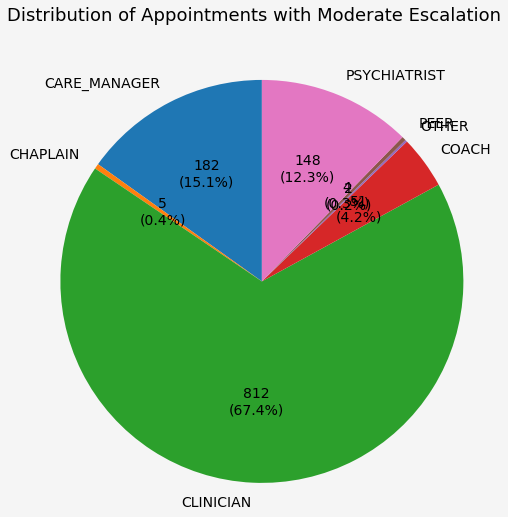

In [203]:
get_pie_chart(aptRole_dist_escModerate, 'Distribution of Appointments with Moderate Escalation', 
              'aptRole_dist_escModerate_', '')

#### Appointments With Severe Escalation

In [204]:
aptRole_dist_escSevere = pd.concat([appointment_severe['support_role_id'].value_counts(0), 
                                  appointment_severe['support_role_id'].value_counts(1)], axis=1)
aptRole_dist_escSevere.columns = ['appt_count', 'appt_pct']
aptRole_dist_escSevere = aptRole_dist_escSevere.sort_index()
aptRole_dist_escSevere

appt_count  appt_pct
CARE_MANAGER          11    0.0502
CHAPLAIN               1    0.0046
CLINICIAN             47    0.2146
COACH                 13    0.0594
PEER                   2    0.0091
PSYCHIATRIST         145    0.6621

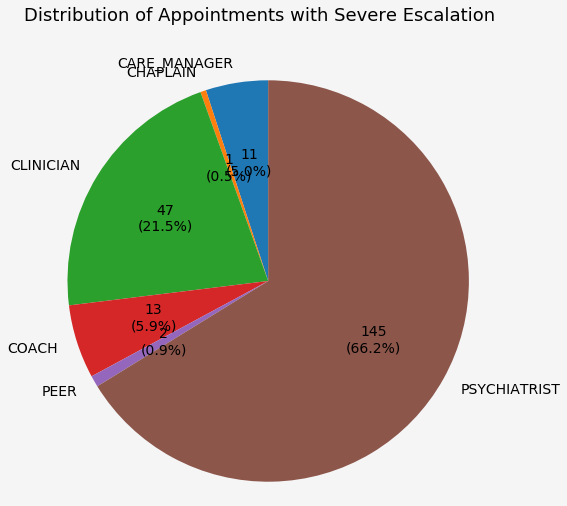

In [205]:
get_pie_chart(aptRole_dist_escSevere, 'Distribution of Appointments with Severe Escalation', 
              'aptRole_dist_escSevere_', '')

#### Summary

In [206]:
aptRole_dist_esc = pd.concat({'All':aptRole_dist_escAll, 
                              'Mild':aptRole_dist_escMild, 
                              'Moderate':aptRole_dist_escModerate, 
                              'Severe':aptRole_dist_escSevere}, names=['Escalation', 'Provider Role'])
aptRole_dist_esc

appt_count  appt_pct
Escalation Provider Role                      
All        CARE_MANAGER          329    0.1547
           CHAPLAIN               14    0.0066
           CLINICIAN            1004    0.4720
           COACH                 401    0.1885
           OTHER                  10    0.0047
           PEER                    6    0.0028
           PSYCHIATRIST          363    0.1707
Mild       CARE_MANAGER          138    0.1941
           CHAPLAIN                8    0.0113
           CLINICIAN             149    0.2096
           COACH                 338    0.4754
           OTHER                   8    0.0113
           PSYCHIATRIST           70    0.0985
Moderate   CARE_MANAGER          182    0.1512
           CHAPLAIN                5    0.0042
           CLINICIAN             812    0.6744
           COACH                  51    0.0424
           OTHER                   2    0.0017
           PEER                    4    0.0033
           PSYCHIATRIST          148    0.1229
Severe     CARE_MANAGER           11    0.0502
           CHAPLAIN                1    0.0046
           CLINICIAN              47    0.2146
           COACH                  13    0.0594
           PEER                    2    0.0091
           PSYCHIATRIST          145    0.6621

In [207]:
aptRole_dist_esc.to_csv(CHART_PATH + 'aptRole_dist_esc_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

In [208]:
aptRole_dist_esc_unstacked = aptRole_dist_esc.unstack().fillna(0)
aptRole_dist_esc_unstacked

appt_count                                                    \
Provider Role CARE_MANAGER CHAPLAIN CLINICIAN  COACH OTHER PEER PSYCHIATRIST   
Escalation                                                                     
All                  329.0     14.0    1004.0  401.0  10.0  6.0        363.0   
Mild                 138.0      8.0     149.0  338.0   8.0  0.0         70.0   
Moderate             182.0      5.0     812.0   51.0   2.0  4.0        148.0   
Severe                11.0      1.0      47.0   13.0   0.0  2.0        145.0   

                  appt_pct                                             \
Provider Role CARE_MANAGER CHAPLAIN CLINICIAN   COACH   OTHER    PEER   
Escalation                                                              
All                 0.1547   0.0066    0.4720  0.1885  0.0047  0.0028   
Mild                0.1941   0.0113    0.2096  0.4754  0.0113  0.0000   
Moderate            0.1512   0.0042    0.6744  0.0424  0.0017  0.0033   
Severe              0.0502   0.0046    0.2146  0.0594  0.0000  0.0091   

                            
Provider Role PSYCHIATRIST  
Escalation                  
All                 0.1707  
Mild                0.0985  
Moderate            0.1229  
Severe              0.6621

In [209]:
aptRole_dist_esc_unstacked.to_csv(CHART_PATH + 'aptRole_dist_esc_unstacked_' + str(datetime.datetime.now().date()).replace('-','') + '.csv')

### Escalation Appointment Time Series

In [210]:
# Time series data by escalation bracket, provider role

# Mild
instanceMild_aptRole_ts_data = pd.DataFrame(appointment_mild.groupby(['apt_year','apt_month','support_role_id']).count().appointment_id)
instanceMild_aptRole_ts_data = instanceMild_aptRole_ts_data.unstack().fillna(0).appointment_id
instanceMild_aptRole_ts_data.index.names = ['year','month']
instanceMild_aptRole_ts_data = instanceMild_aptRole_ts_data.merge(instance_esc_monthly_ts_data['mild'], 
                                                                  how='outer', 
                                                                  left_index=True, 
                                                                  right_index=True).fillna(0)
instanceMild_aptRole_ts_data = instanceMild_aptRole_ts_data.rename(columns={'mild':'ESCALATION'})

instanceMild_aptRole_weekly_ts_data = pd.DataFrame(appointment_mild.groupby(['apt_year_month_week', 'support_role_id']).count()).appointment_id
instanceMild_aptRole_weekly_ts_data = instanceMild_aptRole_weekly_ts_data.unstack().fillna(0)
instanceMild_aptRole_weekly_ts_data.index = pd.MultiIndex.from_arrays([instanceMild_aptRole_weekly_ts_data.index.year, 
                                                      instanceMild_aptRole_weekly_ts_data.index.month, 
                                                      instanceMild_aptRole_weekly_ts_data.index.day], 
                                                      names=['Year','Month','Week'])


# Moderate
instanceModerate_aptRole_ts_data = pd.DataFrame(appointment_moderate.groupby(['apt_year','apt_month','support_role_id']).count().appointment_id)
instanceModerate_aptRole_ts_data = instanceModerate_aptRole_ts_data.unstack().fillna(0).appointment_id
instanceModerate_aptRole_ts_data.index.names = ['year','month']
instanceModerate_aptRole_ts_data = instanceModerate_aptRole_ts_data.merge(instance_esc_monthly_ts_data['moderate'], 
                                                                  how='outer', 
                                                                  left_index=True, 
                                                                  right_index=True).fillna(0)
instanceModerate_aptRole_ts_data = instanceModerate_aptRole_ts_data.rename(columns={'moderate':'ESCALATION'})

instanceModerate_aptRole_weekly_ts_data = pd.DataFrame(appointment_moderate.groupby(['apt_year_month_week', 'support_role_id']).count()).appointment_id
instanceModerate_aptRole_weekly_ts_data = instanceModerate_aptRole_weekly_ts_data.unstack().fillna(0)
instanceModerate_aptRole_weekly_ts_data.index = pd.MultiIndex.from_arrays([instanceModerate_aptRole_weekly_ts_data.index.year, 
                                                      instanceModerate_aptRole_weekly_ts_data.index.month, 
                                                      instanceModerate_aptRole_weekly_ts_data.index.day], 
                                                      names=['Year','Month','Week'])


# Severe
instanceSevere_aptRole_ts_data = pd.DataFrame(appointment_severe.groupby(['apt_year','apt_month','support_role_id']).count().appointment_id)
instanceSevere_aptRole_ts_data = instanceSevere_aptRole_ts_data.unstack().fillna(0).appointment_id
instanceSevere_aptRole_ts_data.index.names = ['year','month']
instanceSevere_aptRole_ts_data = instanceSevere_aptRole_ts_data.merge(instance_esc_monthly_ts_data['severe'], 
                                                                  how='outer', 
                                                                  left_index=True, 
                                                                  right_index=True).fillna(0)
instanceSevere_aptRole_ts_data = instanceSevere_aptRole_ts_data.rename(columns={'severe':'ESCALATION'})

instanceSevere_aptRole_weekly_ts_data = pd.DataFrame(appointment_severe.groupby(['apt_year_month_week', 'support_role_id']).count()).appointment_id
instanceSevere_aptRole_weekly_ts_data = instanceSevere_aptRole_weekly_ts_data.unstack().fillna(0)
instanceSevere_aptRole_weekly_ts_data.index = pd.MultiIndex.from_arrays([instanceSevere_aptRole_weekly_ts_data.index.year, 
                                                      instanceSevere_aptRole_weekly_ts_data.index.month, 
                                                      instanceSevere_aptRole_weekly_ts_data.index.day], 
                                                      names=['Year','Month','Week'])

In [211]:
def get_escalation_appointments(esc_data,appt_data,cumulative=False):
    # Plot parameters
    bar_width = 0.4
    title_prefix = ''
    save_suffix = ''

    # Set appt_data column order for color/legend coherence
    if cumulative:
        title_prefix = 'Cumulative '
        save_suffix = 'cumulative_'
        esc_data = [item.cumsum() for item in esc_data]
        appt_data = [item.cumsum() for item in appt_data]
    support_roles = sorted(provider_support_role.support_role_id.unique())
    support_role_colors = ['#003f5c','#374c80','#7a5195','#bc5090','#ef5675','#ff764a','#ffa600']
    titles = ['Mild Escalation','Moderate Escalation','Severe Escalation']
    for i in range(len(appt_data)):
        for role in support_roles:
            if role not in appt_data[i].columns:
                appt_data[i][role] = 0.0
        appt_data[i] = appt_data[i][support_roles]

    # Get x-axis labels and range
    xlabels = get_ts_xlabels(index=appt_data[np.argmax([len(df) for df in appt_data])].index, time='monthly')
    xmax = max([len(df) for df in appt_data])
    appt_ymax = max([df.sum(axis=1).max() for df in appt_data])
    esc_ymax = max([df.max()for df in esc_data])

    # Plot
    suptitle = title_prefix + 'Number of Booked Appointments per Month by Escalation and Provider Role'
    fig, axes = plt.subplots(3,1,figsize=(16,20), facecolor='whitesmoke')
    fig.suptitle(suptitle, fontsize=20, y=0.92)
    plt.grid(True, linestyle='--')

    for appt,esc,ax,title in zip(appt_data,esc_data,axes,titles):

        ax_temp = ax.twinx()
        ax_temp.set_ylabel('Escalation Count', fontsize=14)
        ax_temp.set_ylim(0,max(appt_ymax,esc_ymax)+5)
        esc.plot(ax=ax_temp, kind='bar', width=bar_width, color='grey', alpha=0.5, position=0)

        appt.plot(ax=ax, kind='bar', width=bar_width, stacked=True, color=support_role_colors, position=1)
        ax.set_title(title, fontsize=18)
        ax.set_xlabel('Date', fontsize=14)
        ax.set_xticks(np.arange(xmax))
        ax.set_xticklabels(xlabels, rotation=0)
        ax.set_xlim(-1,xmax)
        ax.set_ylabel('Appointment Count', fontsize=14)
        ax.set_ylim(0,appt_ymax+5)
        
    name = 'esc_apptRole_dist_monthly_' + save_suffix
    save_figure(fig,FIGURE_PATH,name)

In [212]:
esc_data = [instanceMild_aptRole_ts_data['ESCALATION'],instanceModerate_aptRole_ts_data['ESCALATION'],instanceSevere_aptRole_ts_data['ESCALATION']]
appt_data = [instanceMild_aptRole_ts_data,instanceModerate_aptRole_ts_data,instanceSevere_aptRole_ts_data]

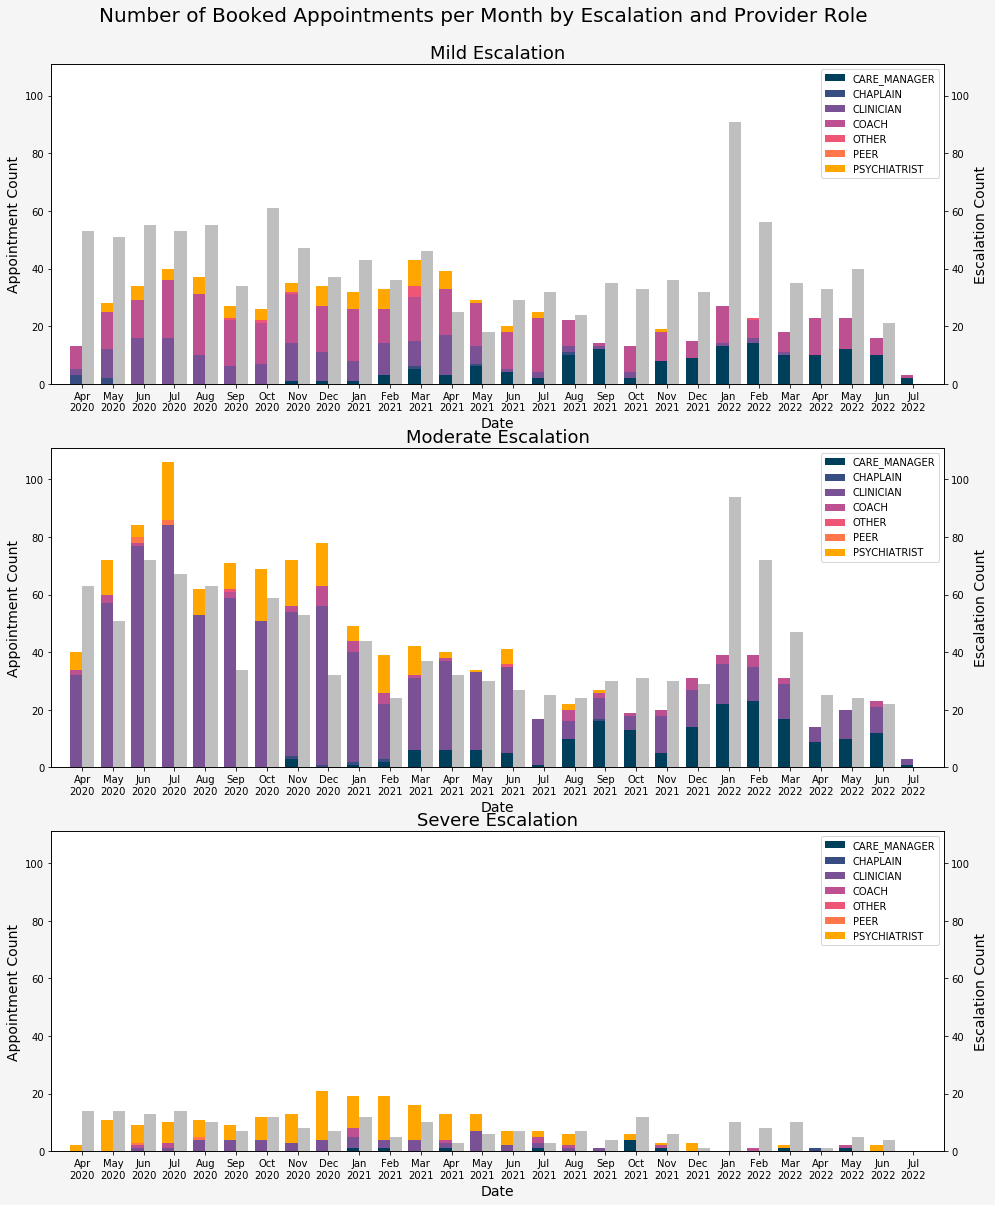

In [213]:
get_escalation_appointments(esc_data,appt_data,cumulative=False)

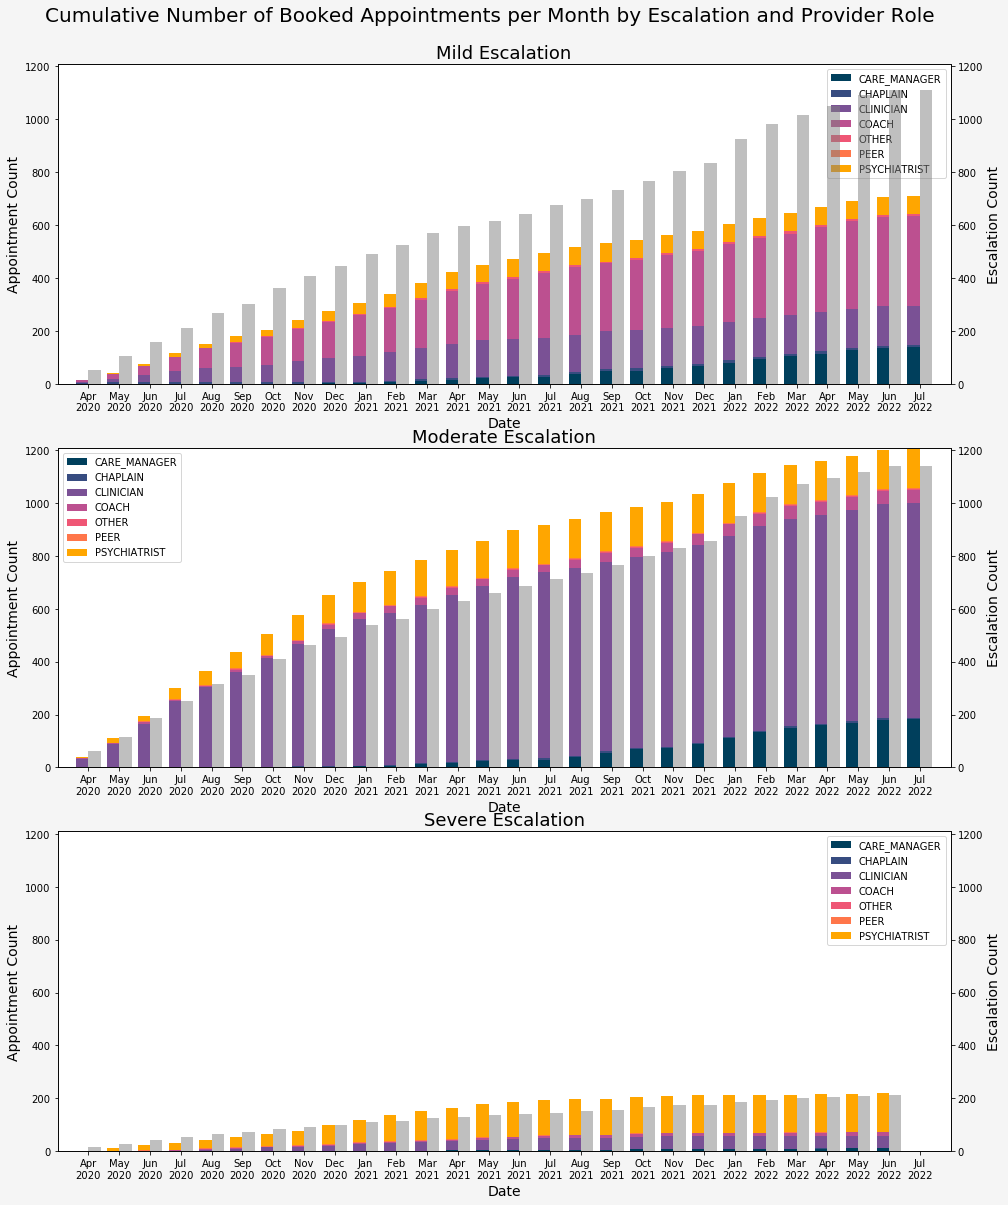

In [214]:
get_escalation_appointments(esc_data,appt_data,cumulative=True)

In [215]:
# TODO - 04/26/2022:
# availability (also email mark about historical data) 
# covid data second y-axis on escalation distribution figures
# covid data correlation/regression with escalation (total, by escalation severity), appt, user, etc.

# NEW - 05/19/2022:
# try graphing ratio instead
# try a heatmap visualization instead of stacked bars - just as above - months along x, roles along y, color for count

In [216]:
aptRole_ts_data.tail()

support_role_id  CARE_MANAGER  CHAPLAIN  CLINICIAN  COACH  OTHER  PEER  \
year month                                                               
2022 3                  110.0       0.0       26.0   36.0    0.0   0.0   
     4                   57.0       2.0       16.0   33.0    0.0   0.0   
     5                   57.0       0.0       17.0   35.0    0.0   0.0   
     6                   58.0       0.0       17.0   14.0    1.0   0.0   
     7                    8.0       0.0        3.0    2.0    0.0   0.0   

support_role_id  PSYCHIATRIST  
year month                     
2022 3                    1.0  
     4                    0.0  
     5                    0.0  
     6                    2.0  
     7                    0.0

In [217]:
aptRole_avail_ts_data.tail()

support_role_id  CARE_MANAGER  CHAPLAIN  CLINICIAN  COACH  OTHER  PEER  \
year month                                                               
2022 2                    0.0      48.0        0.0    0.0   47.0   0.0   
     3                    0.0       0.0        0.0    0.0   78.0   0.0   
     6                    1.0      10.0        0.0    6.0    4.0   0.0   
     7                  129.0      80.0       20.0  102.0   64.0   0.0   
     8                   79.0      50.0       18.0   87.0   40.0   0.0   

support_role_id  PSYCHIATRIST  
year month                     
2022 2                    1.0  
     3                    1.0  
     6                    1.0  
     7                    0.0  
     8                    0.0

# TEMPTEMPTEMPTEMPTEMPTEMPTEMPTEMPTEMPTEMPTEMPTEMP 
* (DONE - 02/02/2022) all unique account id's on Cobalt that have attempted an assessment, scheduled an appointment, or viewed content
* (DONE - 02/02/2022) all unique account id's having completed the full assessment sequence and received an escalation - this makes the most sense given the next two metrics (moderate and severe counts/pcts)
* (DONE - 02/02/2022) all unique appointment id's on Cobalt from account id's that have received an escalation

In [218]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   ITALICS = '\033[3m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [219]:
attempt_cols = ['PHQ4_attempts','PHQ9_attempts','GAD7_attempts','PCPTSD_attempts']
instance_attempts = account_instance[account_instance[attempt_cols].sum(axis=1) > 0]

instance_attempts_account_ids = set(instance_attempts['account_id'].unique())
appointment_account_ids = set(appointment['account_id'].unique())
activity_tracking_account_ids = set(activity_tracking[(activity_tracking['activity_type_id']=='CONTENT') & 
                                                  (activity_tracking['activity_action_id']=='VIEW')]['account_id'].unique())
active_account_ids = instance_attempts_account_ids.union(appointment_account_ids,activity_tracking_account_ids)

In [220]:
instance_escalation = account_instance[account_instance['instance_complete']==1]
instance_escalation_moderate = instance_escalation[instance_escalation['escalation']=='moderate']
instance_escalation_severe = instance_escalation[instance_escalation['escalation']=='severe']

instance_escalation_account_ids = instance_escalation['account_id'].unique()
instance_escalation_moderate_account_ids = instance_escalation_moderate['account_id'].unique()
instance_escalation_severe_account_ids = instance_escalation_severe['account_id'].unique()

mod_pct_acct = (len(instance_escalation_moderate_account_ids)/len(instance_escalation_account_ids))*100
mod_pct_esc = (len(instance_escalation_moderate)/len(instance_escalation))*100
sev_pct_acct = (len(instance_escalation_severe_account_ids)/len(instance_escalation_account_ids))*100
sev_pct_esc = (len(instance_escalation_severe)/len(instance_escalation))*100

In [221]:
appointment_escalation = appointment[appointment['account_id'].isin(instance_escalation_account_ids)]
appt_acct_pct = (len(appointment_escalation.account_id.unique())/len(instance_escalation_account_ids))*100

In [222]:
# Active Accounts
print(color.BOLD + 'Active Accounts:' + color.END)
print(color.BOLD + '{:d} '.format(len(active_account_ids)) + color.END + 'unique, active accounts accessed mental health and well-being resources on the Cobalt platform')
print(color.BOLD + '\t{:d} '.format(len(instance_attempts_account_ids)) + color.END + 'distinct accounts attempted assessments')
print(color.BOLD + '\t{:d} '.format(len(appointment_account_ids)) + color.END + 'distinct accounts booked' + color.BOLD + ' {:d} '.format(len(appointment)) + color.END + 'appointments')
print(color.BOLD + '\t{:d} '.format(len(activity_tracking_account_ids)) + color.END + 'distinct accounts engaged with content')
print()

# Assessments and Escalations
print(color.BOLD + 'Assessments and Escalations:' + color.END)
print(color.BLUE+color.BOLD + '{:d} '.format(len(instance_escalation_account_ids)) + color.END+color.END + 
      'unique accounts completed mental health assessments, resulting in' + 
      color.BLUE+color.BOLD +' {:d} '.format(len(instance_escalation)) + color.END+color.END + 'distinct escalations')

print(color.BOLD + '\tModerate Escalation:' + color.END)
print('\t' + color.YELLOW+color.BOLD + '{:d}({:2.2f}%) '.format(len(instance_escalation_moderate_account_ids),mod_pct_acct) + color.END+color.END + 
      'unique accounts met moderate criteria, resulting in' + 
      color.YELLOW+color.BOLD +' {:d}({:2.2f}%) '.format(len(instance_escalation_moderate),mod_pct_esc) + color.END+color.END + 'moderate escalations')

print(color.BOLD + '\tSevere Escalation:' + color.END)
print('\t' + color.RED+color.BOLD + '{:d}({:2.2f}%) '.format(len(instance_escalation_severe_account_ids),sev_pct_acct) + color.END+color.END + 
      'unique accounts met severe criteria, resulting in' + 
      color.RED+color.BOLD +' {:d}({:2.2f}%) '.format(len(instance_escalation_severe),sev_pct_esc) + color.END+color.END + 'severe escalations')
print()

# Appointments
print(color.BOLD + 'Appointments:' + color.END)
print(color.BOLD + '{:d}/{:d}({:2.2f})% '.format(len(appointment_escalation.account_id.unique()),len(instance_escalation_account_ids),appt_acct_pct) + color.END + 
      'accounts with completed mental health assessments booked' + color.BOLD + ' {:d} '.format(len(appointment_escalation)) + color.END + 
      'appointments with a trained mental health professional')

Active Accounts:
12549 unique, active accounts accessed mental health and well-being resources on the Cobalt platform
	7877 distinct accounts attempted assessments
	2348 distinct accounts booked 3687 appointments
	4922 distinct accounts engaged with content

Assessments and Escalations:
2422 unique accounts completed mental health assessments, resulting in 2465 distinct escalations
	Moderate Escalation:
	1123(46.37%) unique accounts met moderate criteria, resulting in 1141(46.29%) moderate escalations
	Severe Escalation:
	212(8.75%) unique accounts met severe criteria, resulting in 213(8.64%) severe escalations

Appointments:
1093/2422(45.13)% accounts with completed mental health assessments booked 2127 appointments with a trained mental health professional


# Unused / Deprecated Code

In [223]:
"""
#### Sankey Diagram ####
# To get nodes from multi-index
list(itertools.chain.from_iterable(instance_flow.index.levels[0:]))
# To get flow sequence from multi-index
[' '.join(col).strip() for col in instance_flow.index.values]

#### Sankey Diagram - OLD method to adjust phq4 link data ####
# Get instance flow data
instance_subset,instance_flow = get_instance_flow(subset_cols, group_cols, agg_dict)
flow_data_p1 = instance_flow[instance_flow.index.isin(['no_symptoms'], level=0)].droplevel([1,2,3])
flow_data_p2 = instance_flow[~instance_flow.index.isin(['no_symptoms','inconclusive'], level=0)]

# Get sankey data
nodes_all,links_all = get_sankey_data(instance_flow)
nodes_p1,links_p1 = get_sankey_data(flow_data_p1)
nodes_p2,links_p2 = get_sankey_data(flow_data_p2)

# Adjust PHQ4 data with no_symptoms to point directly to escalation: mild
links_p1.loc[links_p1['target']!=1, 'target'] = nodes_all.loc[nodes_all['label']=='escalation: mild', 'idx'].values[0]

# Set final node and link data
nodes = nodes_all
links = pd.concat([links_p1,links_p2])

"""

"\n#### Sankey Diagram ####\n# To get nodes from multi-index\nlist(itertools.chain.from_iterable(instance_flow.index.levels[0:]))\n# To get flow sequence from multi-index\n[' '.join(col).strip() for col in instance_flow.index.values]\n\n#### Sankey Diagram - OLD method to adjust phq4 link data ####\n# Get instance flow data\ninstance_subset,instance_flow = get_instance_flow(subset_cols, group_cols, agg_dict)\nflow_data_p1 = instance_flow[instance_flow.index.isin(['no_symptoms'], level=0)].droplevel([1,2,3])\nflow_data_p2 = instance_flow[~instance_flow.index.isin(['no_symptoms','inconclusive'], level=0)]\n\n# Get sankey data\nnodes_all,links_all = get_sankey_data(instance_flow)\nnodes_p1,links_p1 = get_sankey_data(flow_data_p1)\nnodes_p2,links_p2 = get_sankey_data(flow_data_p2)\n\n# Adjust PHQ4 data with no_symptoms to point directly to escalation: mild\nlinks_p1.loc[links_p1['target']!=1, 'target'] = nodes_all.loc[nodes_all['label']=='escalation: mild', 'idx'].values[0]\n\n# Set final 

In [224]:
"""
for bar,data in zip(ax.patches[::3],instance_esc_monthly_ts_data.values):
    total_height = data.sum()
    mild = data[0]
    moderate = data[1]
    severe = data[2]
    
    text_x = bar.get_x()+bar.get_width()/2
    text_y = total_height+text_pad
    text = str(int(total_height)) + ', (' + str("{:.1f}".format(float((mild/total_height)*100))) + '% mild)'
    ax.text(text_x, text_y, text, rotation=0, va='top', ha='center', color='black', fontsize=10, fontweight='bold')
"""

'\nfor bar,data in zip(ax.patches[::3],instance_esc_monthly_ts_data.values):\n    total_height = data.sum()\n    mild = data[0]\n    moderate = data[1]\n    severe = data[2]\n    \n    text_x = bar.get_x()+bar.get_width()/2\n    text_y = total_height+text_pad\n    text = str(int(total_height)) + \', (\' + str("{:.1f}".format(float((mild/total_height)*100))) + \'% mild)\'\n    ax.text(text_x, text_y, text, rotation=0, va=\'top\', ha=\'center\', color=\'black\', fontsize=10, fontweight=\'bold\')\n'

In [225]:
"""
data[0].plot(ax=ax[0], kind='bar', stacked=True)
ax[0].set_title('Mild Escalation', fontsize=18)
ax[0].set_xlabel('Date', fontsize=14)
ax[0].set_xticks(np.arange(xmax))
ax[0].set_xticklabels(xlabels, rotation=90)
ax[0].set_ylabel('Appointment Count', fontsize=14)
ax[0].set_xlim(-1,xmax)
#ax[0].legend(instanceMild_aptRole_ts_data.columns)

instanceModerate_aptRole_ts_data.plot(ax=ax[1], kind='bar', stacked=True)
ax[1].set_title('Moderate Escalation', fontsize=18)
ax[1].set_xlabel('Date', fontsize=14)
ax[1].set_xticks(np.arange(xmax))
ax[1].set_xticklabels(xlabels, rotation=90)
ax[1].set_ylabel('Appointment Count', fontsize=14)
ax[1].set_xlim(-1,xmax)
#ax[1].legend(instanceModerate_aptRole_ts_data.columns)

instanceSevere_aptRole_ts_data.plot(ax=ax[2], kind='bar', stacked=True)
ax[2].set_title('Severe Escalation', fontsize=18)
ax[2].set_xlabel('Date', fontsize=14)
ax[2].set_xticks(np.arange(xmax))
ax[2].set_xticklabels(xlabels, rotation=90)
ax[2].set_ylabel('Appointment Count', fontsize=14)
ax[2].set_xlim(-1,xmax)
#ax[2].legend((instanceSevere_aptRole_ts_data.columns)
"""

"\ndata[0].plot(ax=ax[0], kind='bar', stacked=True)\nax[0].set_title('Mild Escalation', fontsize=18)\nax[0].set_xlabel('Date', fontsize=14)\nax[0].set_xticks(np.arange(xmax))\nax[0].set_xticklabels(xlabels, rotation=90)\nax[0].set_ylabel('Appointment Count', fontsize=14)\nax[0].set_xlim(-1,xmax)\n#ax[0].legend(instanceMild_aptRole_ts_data.columns)\n\ninstanceModerate_aptRole_ts_data.plot(ax=ax[1], kind='bar', stacked=True)\nax[1].set_title('Moderate Escalation', fontsize=18)\nax[1].set_xlabel('Date', fontsize=14)\nax[1].set_xticks(np.arange(xmax))\nax[1].set_xticklabels(xlabels, rotation=90)\nax[1].set_ylabel('Appointment Count', fontsize=14)\nax[1].set_xlim(-1,xmax)\n#ax[1].legend(instanceModerate_aptRole_ts_data.columns)\n\ninstanceSevere_aptRole_ts_data.plot(ax=ax[2], kind='bar', stacked=True)\nax[2].set_title('Severe Escalation', fontsize=18)\nax[2].set_xlabel('Date', fontsize=14)\nax[2].set_xticks(np.arange(xmax))\nax[2].set_xticklabels(xlabels, rotation=90)\nax[2].set_ylabel('App

In [226]:
"""
# Exploring time between account creation and escalation
tdelta = acct_esc_time[['acct_esc_tdelta','year']]
tdelta.groupby(['year']).describe()
tdelta.groupby(['year']).apply(lambda x: x[np.abs(stats.zscore(x['acct_esc_tdelta'].dt.days)) < 1]).droplevel(level=0).groupby(['year']).describe()

"""

"\n# Exploring time between account creation and escalation\ntdelta = acct_esc_time[['acct_esc_tdelta','year']]\ntdelta.groupby(['year']).describe()\ntdelta.groupby(['year']).apply(lambda x: x[np.abs(stats.zscore(x['acct_esc_tdelta'].dt.days)) < 1]).droplevel(level=0).groupby(['year']).describe()\n\n"